In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from datetime import datetime
import nltk

# Basic sentiment analysis of reviews
nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

/root/venv/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [74]:
!pip3 install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 39.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Load the file

In [2]:
df_rent = pd.read_json("/work/renttherunway_final_data.json", lines=True)
df_mod = df_rent.copy()

# created a copy of the dataset

Dataset: You will be using the RentTheRunway dataset, which contains ratings of products, product information and users. 


In [3]:
sns.set_palette("muted")  
# sns.set_style('white')
sns.set(rc={'figure.figsize': (12, 8)})  

### About the dataset

In [4]:
df_mod.shape

(192544, 15)

In [5]:
df_mod.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date'],
      dtype='object')

In [6]:
df_mod.head()

fit  user_id bust size  item_id  weight  rating     rented for  \
0  fit   420272       34d  2260466  137lbs    10.0       vacation   
1  fit   273551       34b   153475  132lbs    10.0          other   
2  fit   360448       NaN  1063761     NaN    10.0          party   
3  fit   909926       34c   126335  135lbs     8.0  formal affair   
4  fit   151944       34b   616682  145lbs    10.0        wedding   

                                         review_text          body type  \
0  An adorable romper! Belt and zipper were a lit...          hourglass   
1  I rented this dress for a photo shoot. The the...  straight & narrow   
2  This hugged in all the right places! It was a ...                NaN   
3  I rented this for my company's black tie award...               pear   
4  I have always been petite in my upper body and...           athletic   

                                      review_summary category height  size  \
0                               So many compliments!   romper  5' 8"    14   
1                            I felt so glamourous!!!     gown  5' 6"    12   
2  It was a great time to celebrate the (almost) ...   sheath  5' 4"     4   
3   Dress arrived on time and in perfect condition.     dress  5' 5"     8   
4                    Was in love with this dress !!!     gown  5' 9"    12   

     age         review_date  
0   28.0      April 20, 2016  
1   36.0       June 18, 2013  
2  116.0   December 14, 2015  
3   34.0   February 12, 2014  
4   27.0  September 26, 2016

In [7]:
# in column name replace white space with '_'
df_mod.columns = df_rent.columns.str.replace(' ', '_')


In [8]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust_size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented_for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body_type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [9]:
print("\nUnique users:", df_mod['user_id'].nunique())
print("Unique items:", df_mod['item_id'].nunique())
print("Total transactions:", len(df_mod))


Unique users: 105571
Unique items: 5850
Total transactions: 192544


Number of users in the dataset are 105571 although on the dataset website it is 105508.

### Functions

In [10]:
# Filling missing weights
def fill_missing_weight(row):
    if pd.isnull(row['weight']):
        return df_mod[(df_mod['category'] == row['category']) & (df_mod['body_type'] == row['body_type'])]['weight'].mean()
    return row['weight']

# Filling missing heights
def fill_missing_height(row):
    if pd.isnull(row['height']):
        return df_mod[(df_mod['category'] == row['category']) & (df_mod['body_type'] == row['body_type'])]['height'].mean()
    return row['height']

# Function to fill missing values 
def fill_missing_values(row, lookup, column_name):
    if pd.isnull(row[column_name]):
        return lookup.get((row['category'], row['body_type']), row[column_name])
    return row[column_name]
    
# Function to convert weight string to numerical format.
def extract_weight(value):
    if pd.isna(value):
        return np.nan

    # Find numeric part using regular expression
    match = re.search(r'(\d+)', str(value))
    if match:
        return int(match.group(1))
    return np.nan

# Function to convert height string from feet and inches to inches in numerical format.
def convert_height(value):
    if pd.isna(value):
        return np.nan

    # Extract feet and inches using regex
    match = re.search(r'[-]?(\d+)\'\s*(\d+)"?', str(value))

    if match:
        feet = int(match.group(1))
        inches = int(match.group(2))

        # Calculate total inches
        total_inches = feet * 12 + inches
        return total_inches

    return np.nan

# Function to plot univariate plots for each column in dataset
def plot_univariate(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        
        if df[column].dtype == 'object':  # Categorical columns
            sns.countplot(data=df, y=column, order=df[column].value_counts().index)
            plt.title(f"Count of {column}")
        else:  # Numerical columns
            sns.histplot(data=df, x=column, kde=True, bins=20)
            plt.title(f"Distribution of {column}")
        
        plt.show()


## Data Cleaning

#### Duplicates

In [11]:
print(f"\nDuplicate records: {df_mod.duplicated().sum()}")


Duplicate records: 189


In [12]:
# Filtering and displaying only the duplicated data 
duplicated_data = df_mod[df_mod.duplicated()]
duplicated_data

fit  user_id bust_size  item_id  weight  rating     rented_for  \
639       fit    61928       34c  1384766  135lbs    10.0          party   
31362     fit   521538       36d  1459957  140lbs    10.0  formal affair   
33397     fit   662905      32dd  1707988  134lbs    10.0        wedding   
36232     fit   491875       NaN  1707988     NaN    10.0          party   
37164     fit   389952       34b  1459957  120lbs    10.0           date   
...       ...      ...       ...      ...     ...     ...            ...   
188553    fit   213210       34d  1707988     NaN    10.0        wedding   
189032  small   994049       32a  1384766  128lbs     4.0        wedding   
189895    fit   932177       36b  1459957  150lbs    10.0  formal affair   
189970    fit   204984       34b  1522253  119lbs     8.0       everyday   
190946    fit   221624       32b   789011  120lbs    10.0          party   

                                              review_text  body_type  \
639     This dress runs very tight in the waist.  Also...       pear   
31362   Flawless experience with this first time renta...  full bust   
33397   Wore this to an indoor/outdoor Spring wedding....        NaN   
36232    Comfortable, classy, and unique.  A great find.         NaN   
37164   This dress fit like a glove. I wore it for my ...       pear   
...                                                   ...        ...   
188553  I got so many compliments! The color is so vib...   athletic   
189032  I got my usual size, a 2, and it mostly fit ex...   athletic   
189895  I was worried about the length but luckily it ...       pear   
189970  Dress is great and super comfy, but it runs su...  hourglass   
190946  Threw on this dress for work (with tights- it'...     petite   

                                           review_summary category height  \
639     I rented this dress for a black & white party....   sheath  5' 4"   
31362                                   Loved this dress!    dress  5' 2"   
33397            Beautiful, comfortable and easy dress!      dress  5' 6"   
36232                                      Gorgeous dress    dress  5' 4"   
37164                          Perfect little black dress    dress  5' 4"   
...                                                   ...      ...    ...   
188553                            Beautiful and Wearable!    dress  5' 7"   
189032  Good for the Barbie figures. Odd fit for the r...   sheath  5' 4"   
189895                                          Fun dress    dress  5' 6"   
189970  Wore this for my fiance's dirty 30 bday during...    dress  5' 6"   
190946                           Easy-to-wear sassy dress    dress  5' 6"   

        size   age         review_date  
639       12  34.0  September 20, 2016  
31362     24  45.0    November 9, 2015  
33397      8  37.0        June 1, 2017  
36232      8  31.0       July 24, 2017  
37164      8  56.0    October 21, 2015  
...      ...   ...                 ...  
188553    20  28.0      August 7, 2017  
189032     4  38.0     October 5, 2017  
189895    20  53.0   February 15, 2017  
189970     8  35.0        June 9, 2015  
190946     4  27.0    December 5, 2017  

[189 rows x 15 columns]

Any pattern in dupicates ?

In [13]:
# Checking for patterns in duplicated data
category_counts = duplicated_data['category'].value_counts()
date_counts = pd.to_datetime(duplicated_data['review_date']).dt.date.value_counts()

print("Duplicate Records by Category:")
print(category_counts)
print("\nDuplicate Records by Review Date:")
print(date_counts)

Duplicate Records by Category:
dress     132
sheath     52
gown        4
shift       1
Name: category, dtype: int64

Duplicate Records by Review Date:
2017-10-05    3
2016-06-21    3
2017-06-06    3
2015-04-14    2
2017-07-25    2
             ..
2016-03-25    1
2017-10-10    1
2015-09-10    1
2015-04-15    1
2014-08-14    1
Name: review_date, Length: 165, dtype: int64


69.2 percent of duplicated data = dresses category

In [14]:
category_counts = (duplicated_data['category'].value_counts(normalize=True) * 100).round(2)
date_counts = (pd.to_datetime(duplicated_data['review_date']).dt.date.value_counts(normalize=True) * 100).round(2)

print("Duplicate Records by Category (in %):")
print(category_counts)

Duplicate Records by Category (in %):
dress     69.84
sheath    27.51
gown       2.12
shift      0.53
Name: category, dtype: float64


### Keeping only the first occurrence of duplicates and removing others



In [15]:
df_mod = df_mod[~df_mod.duplicated(keep='first')]

#### Type Casting

In [16]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192355 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192355 non-null  object 
 1   user_id         192355 non-null  int64  
 2   bust_size       173963 non-null  object 
 3   item_id         192355 non-null  int64  
 4   weight          162400 non-null  object 
 5   rating          192274 non-null  float64
 6   rented_for      192345 non-null  object 
 7   review_text     192355 non-null  object 
 8   body_type       177730 non-null  object 
 9   review_summary  192355 non-null  object 
 10  category        192355 non-null  object 
 11  height          191680 non-null  object 
 12  size            192355 non-null  int64  
 13  age             191395 non-null  float64
 14  review_date     192355 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 23.5+ MB


In [17]:
df_mod['review_date'] = pd.to_datetime(df_mod['review_date'])

#### Missing Values

In [18]:
# Count missing values
print(df_rent.isnull().sum())

# Percentage of missing values
df_mod.isnull().sum() / len(df_rent) * 100


fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64


fit                0.000000
user_id            0.000000
bust_size          9.552102
item_id            0.000000
weight            15.557483
rating             0.042068
rented_for         0.005194
review_text        0.000000
body_type          7.595666
review_summary     0.000000
category           0.000000
height             0.350569
size               0.000000
age                0.498587
review_date        0.000000
dtype: float64

In [19]:
df_mod['weight'] = df_mod['weight'].apply(extract_weight)
df_mod['height'] = df_mod['height'].apply(convert_height)

In [20]:
# Group by 'category' and 'body_type' and calculate mean for weight and height
grouped_stats = df_mod.groupby(['category', 'body_type']).agg({'weight': 'mean', 'height': 'mean'}).reset_index()

# Create a dictionary for faster lookup
weight_lookup = grouped_stats.set_index(['category', 'body_type'])['weight'].to_dict()
height_lookup = grouped_stats.set_index(['category', 'body_type'])['height'].to_dict()

# Apply the optimized function
df_mod['weight'] = df_mod.apply(lambda row: fill_missing_values(row, weight_lookup, 'weight'), axis=1)
df_mod['height'] = df_mod.apply(lambda row: fill_missing_values(row, height_lookup, 'height'), axis=1)

In [21]:
# Fill missing values
df_mod.fillna(df_mod.median(numeric_only=True), inplace=True)  # Numerical columns

df_mod.fillna(df_mod.mode().iloc[0], inplace=True)  # Categorical columns

# Add month-year column
df_mod['month_year'] = df_mod['review_date'].dt.to_period('M')

/tmp/ipykernel_2121/2024405193.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_mod.fillna(df_mod.mode().iloc[0], inplace=True)  # Categorical columns


## Univariate Analysis

In [22]:
# plot_univariate(df_mod)

### Fit Feedback Distribution

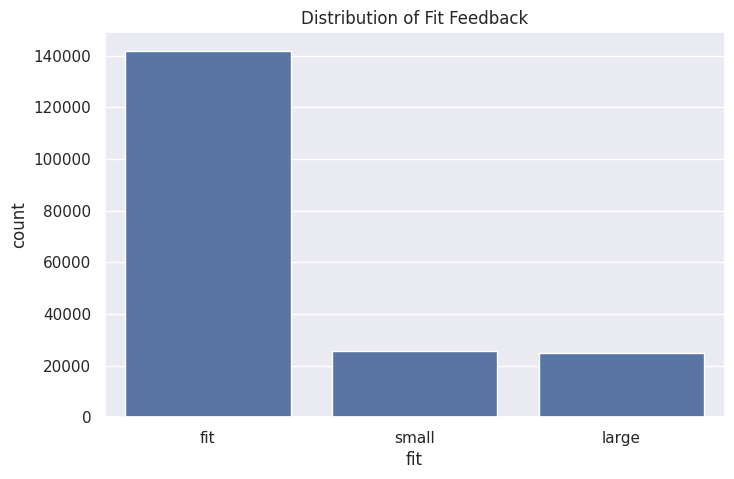

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x='fit', data=df_mod, order=df_mod['fit'].value_counts().index)
plt.title('Distribution of Fit Feedback')
plt.show()

### Top 10 Most Rented Categories

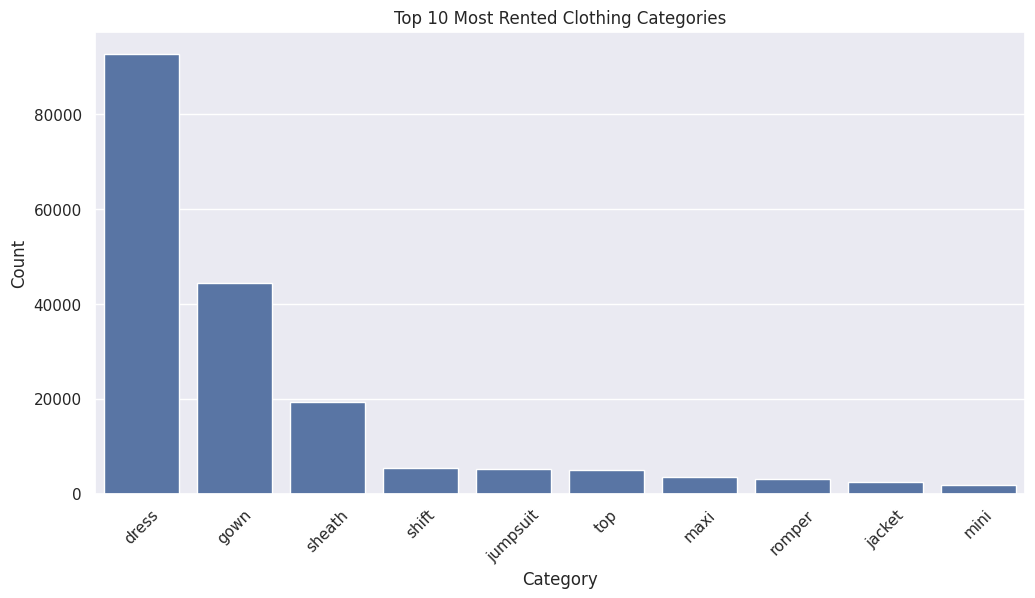

In [24]:
# Get the top 10 most rented categories
top_categories = df_mod['category'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values)

plt.title('Top 10 Most Rented Clothing Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  

plt.show()


### Top 10 Most Rented Reason

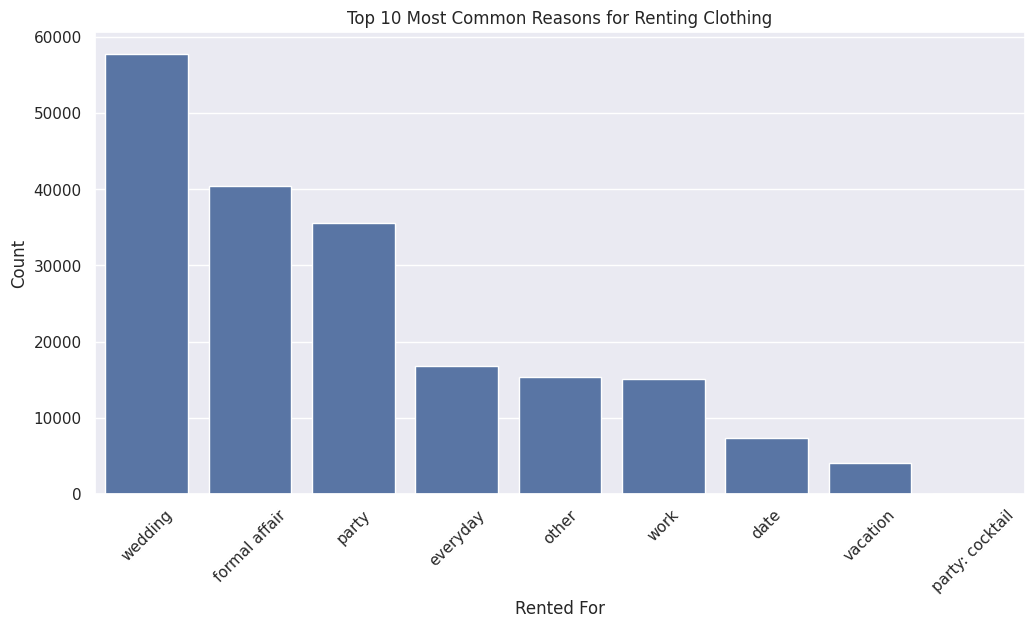

In [25]:
top_rented_for = df_mod['rented_for'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_rented_for.index, y=top_rented_for.values)

plt.title('Top 10 Most Common Reasons for Renting Clothing')
plt.xlabel('Rented For', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)  

plt.show()

### Size Distribution

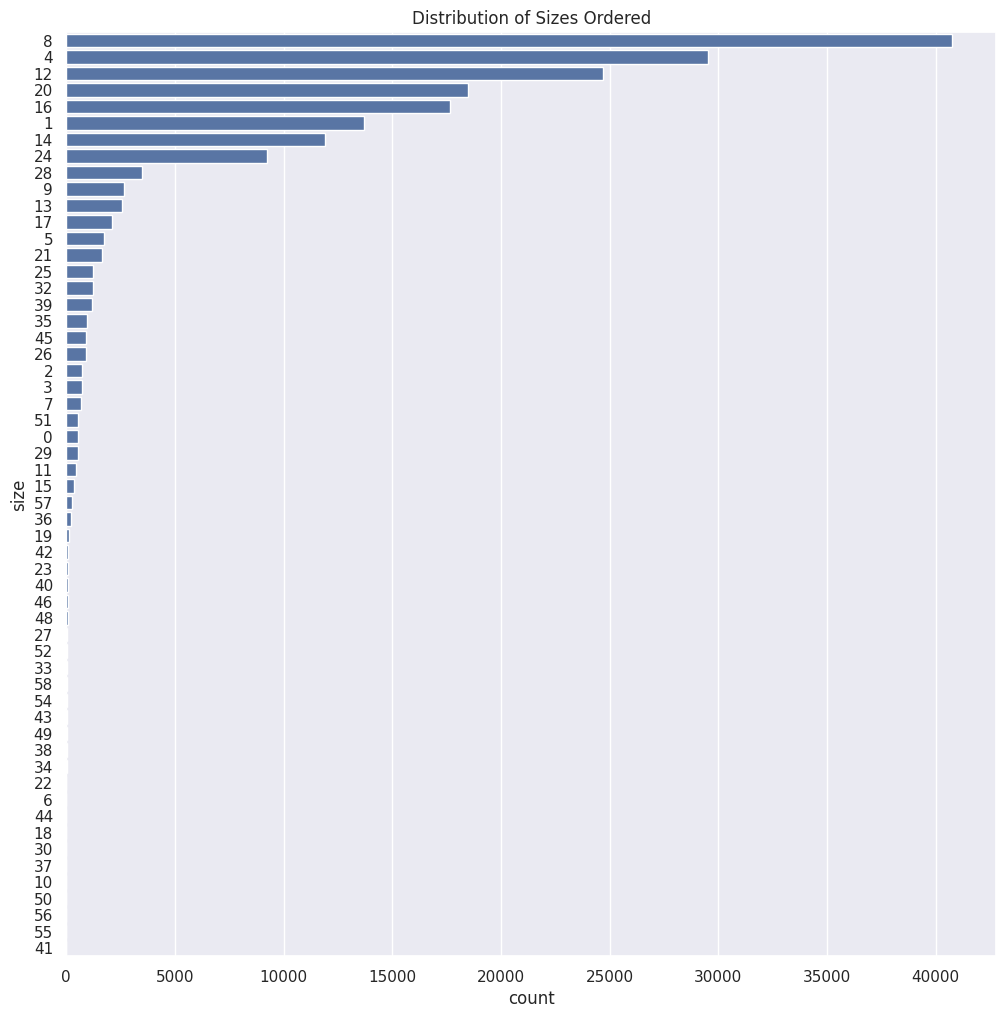

In [26]:
plt.figure(figsize=(12,12))
sns.countplot(y='size', data=df_mod, order=df_mod['size'].value_counts().index)
plt.title('Distribution of Sizes Ordered')
plt.show()


## Correlation Analysis

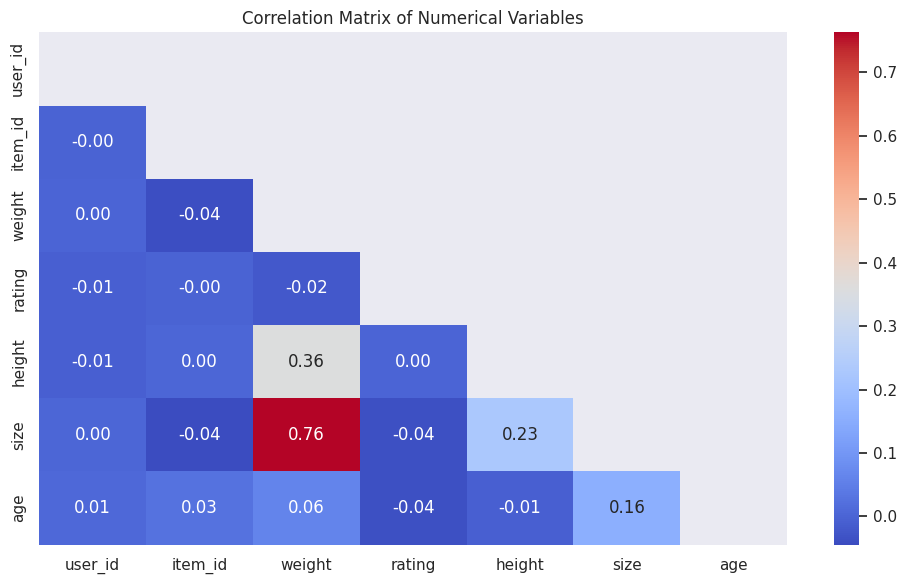

In [27]:
# Correlation matrix of numerical variables
numerical_df = df_mod.select_dtypes(include=[np.number])
if not numerical_df.empty and numerical_df.shape[1] > 1:
    plt.figure(figsize=(10, 6))
    correlation_matrix = numerical_df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()

## User Behavior Analysis

In [28]:
# Number of transactions per user
user_transaction_counts = df_mod['user_id'].value_counts()
print(f"\nUser transaction statistics:")
print(f"Mean transactions per user: {user_transaction_counts.mean():.2f}")
print(f"Median transactions per user: {user_transaction_counts.median():.2f}")
print(f"Max transactions per user: {user_transaction_counts.max()}")


User transaction statistics:
Mean transactions per user: 1.82
Median transactions per user: 1.00
Max transactions per user: 435


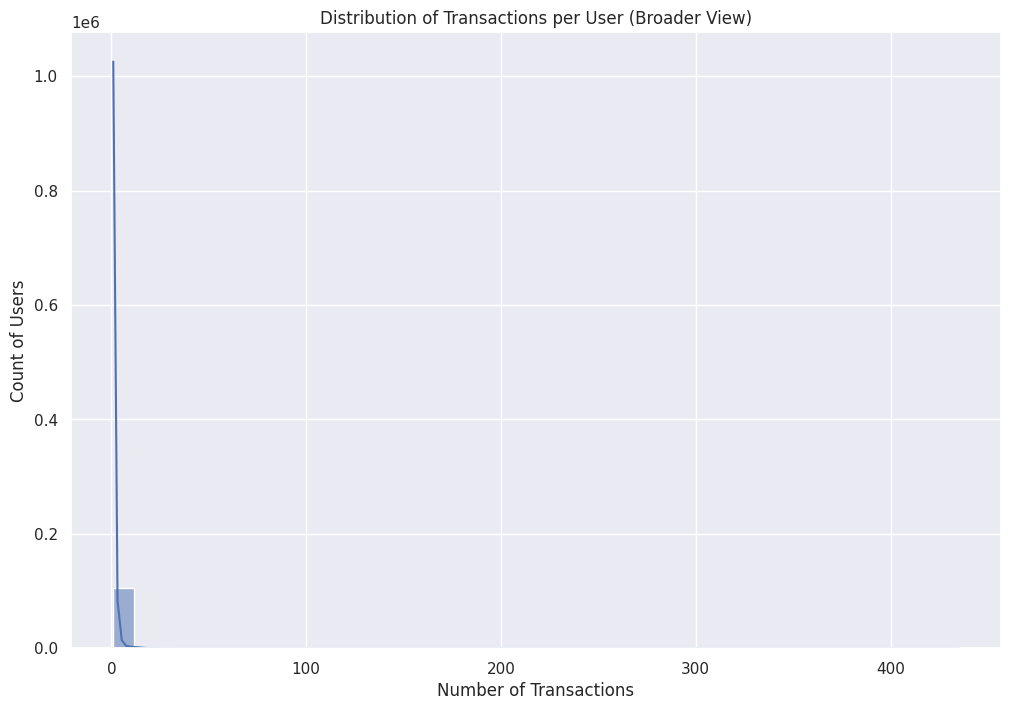

In [29]:
sns.histplot(user_transaction_counts, bins=40 , kde=True)
plt.title('Distribution of Transactions per User (Broader View)')
plt.xlabel('Number of Transactions')
plt.ylabel('Count of Users')
plt.show()

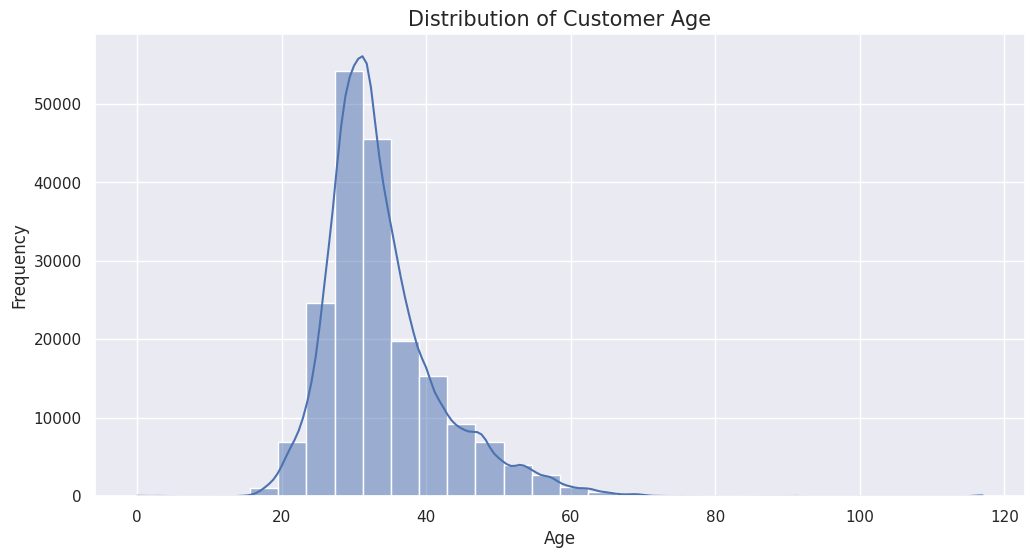

In [30]:
# Analyze age distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_mod['age'].dropna(), bins=30, kde=True)
plt.title('Distribution of Customer Age', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

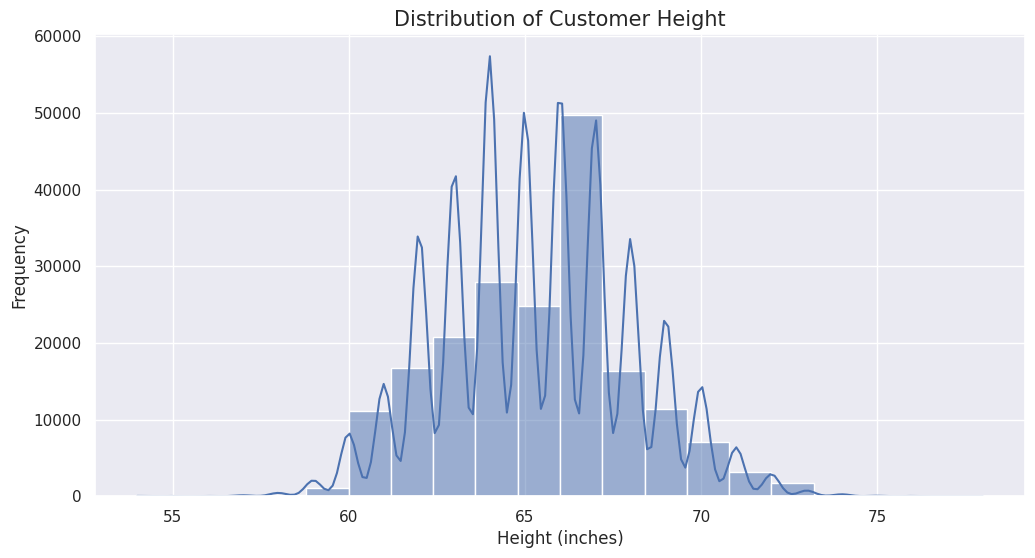

In [31]:
# Plot height distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_mod['height'].dropna(), bins=20, kde=True)
plt.title('Distribution of Customer Height', fontsize=15)
plt.xlabel('Height (inches)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

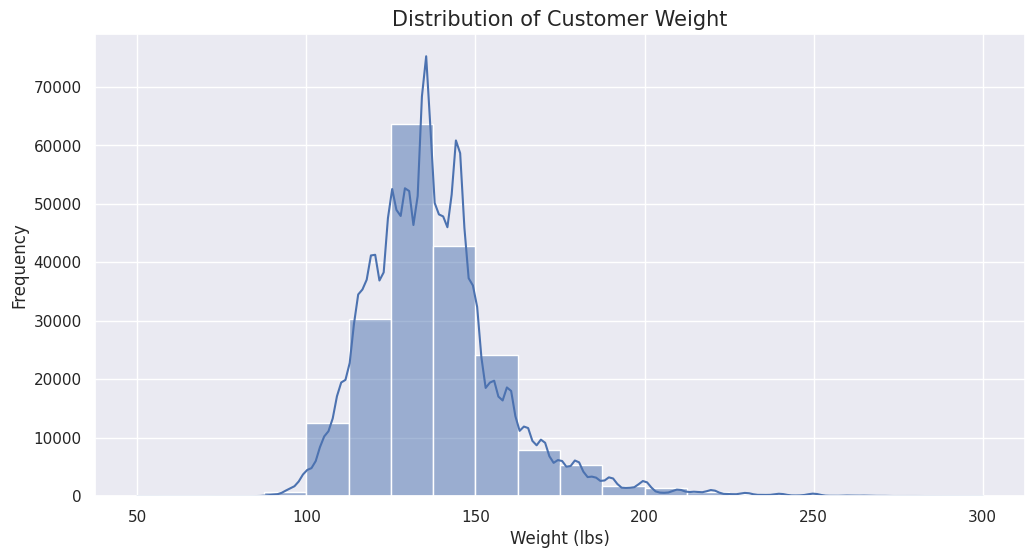

In [32]:
plt.figure(figsize=(12, 6))
sns.histplot(df_mod['weight'].dropna(), bins=20, kde=True)
plt.title('Distribution of Customer Weight', fontsize=15)
plt.xlabel('Weight (lbs)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

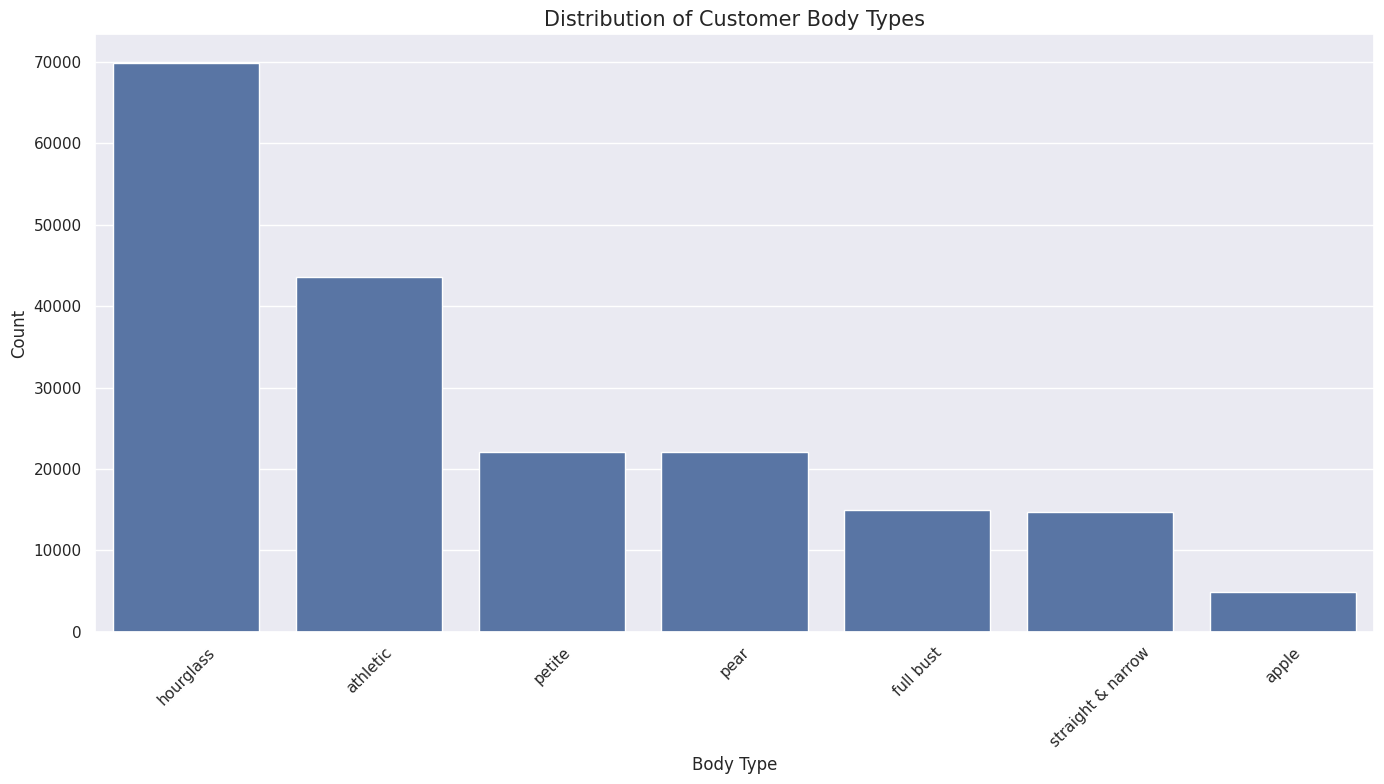

In [33]:
# Analyze body type distribution
body_type_counts = df_mod['body_type'].value_counts()
plt.figure(figsize=(14, 8))
sns.barplot(x=body_type_counts.index, y=body_type_counts.values)
plt.title('Distribution of Customer Body Types', fontsize=15)
plt.xlabel('Body Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

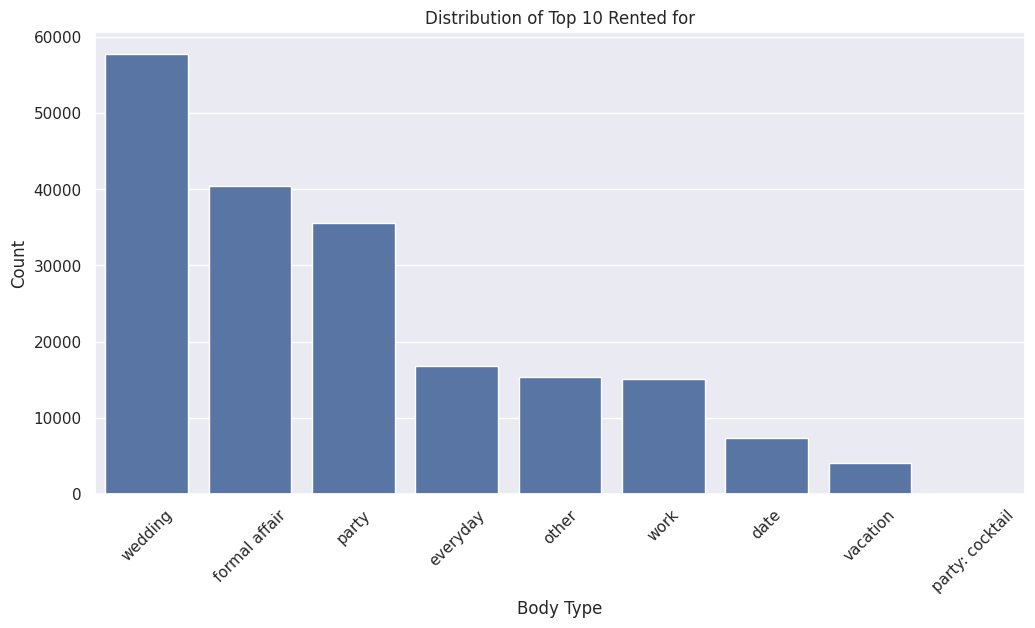

In [34]:
body_type_counts = df_mod['rented_for'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=body_type_counts.index, y=body_type_counts.values)
plt.title('Distribution of Top 10 Rented for')
plt.xlabel('Body Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

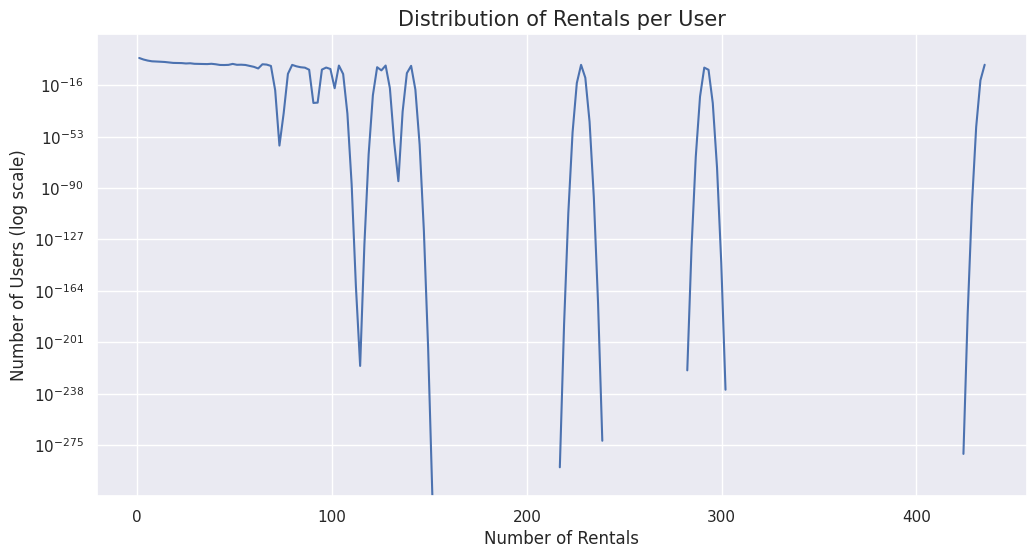

Average rentals per user: 1.82
Median rentals per user: 1.0
Maximum rentals by a single user: 435


In [35]:
rentals_per_user = df_mod['user_id'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(rentals_per_user, kde=True, log_scale=(False, True))
plt.title('Distribution of Rentals per User', fontsize=15)
plt.xlabel('Number of Rentals', fontsize=12)
plt.ylabel('Number of Users (log scale)', fontsize=12)
plt.show()

# Add statistics about user engagement
print(f"Average rentals per user: {rentals_per_user.mean():.2f}")
print(f"Median rentals per user: {rentals_per_user.median()}")
print(f"Maximum rentals by a single user: {rentals_per_user.max()}")


### Body Type vs. Category

/tmp/ipykernel_2121/2815547282.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1600x1000 with 0 Axes>

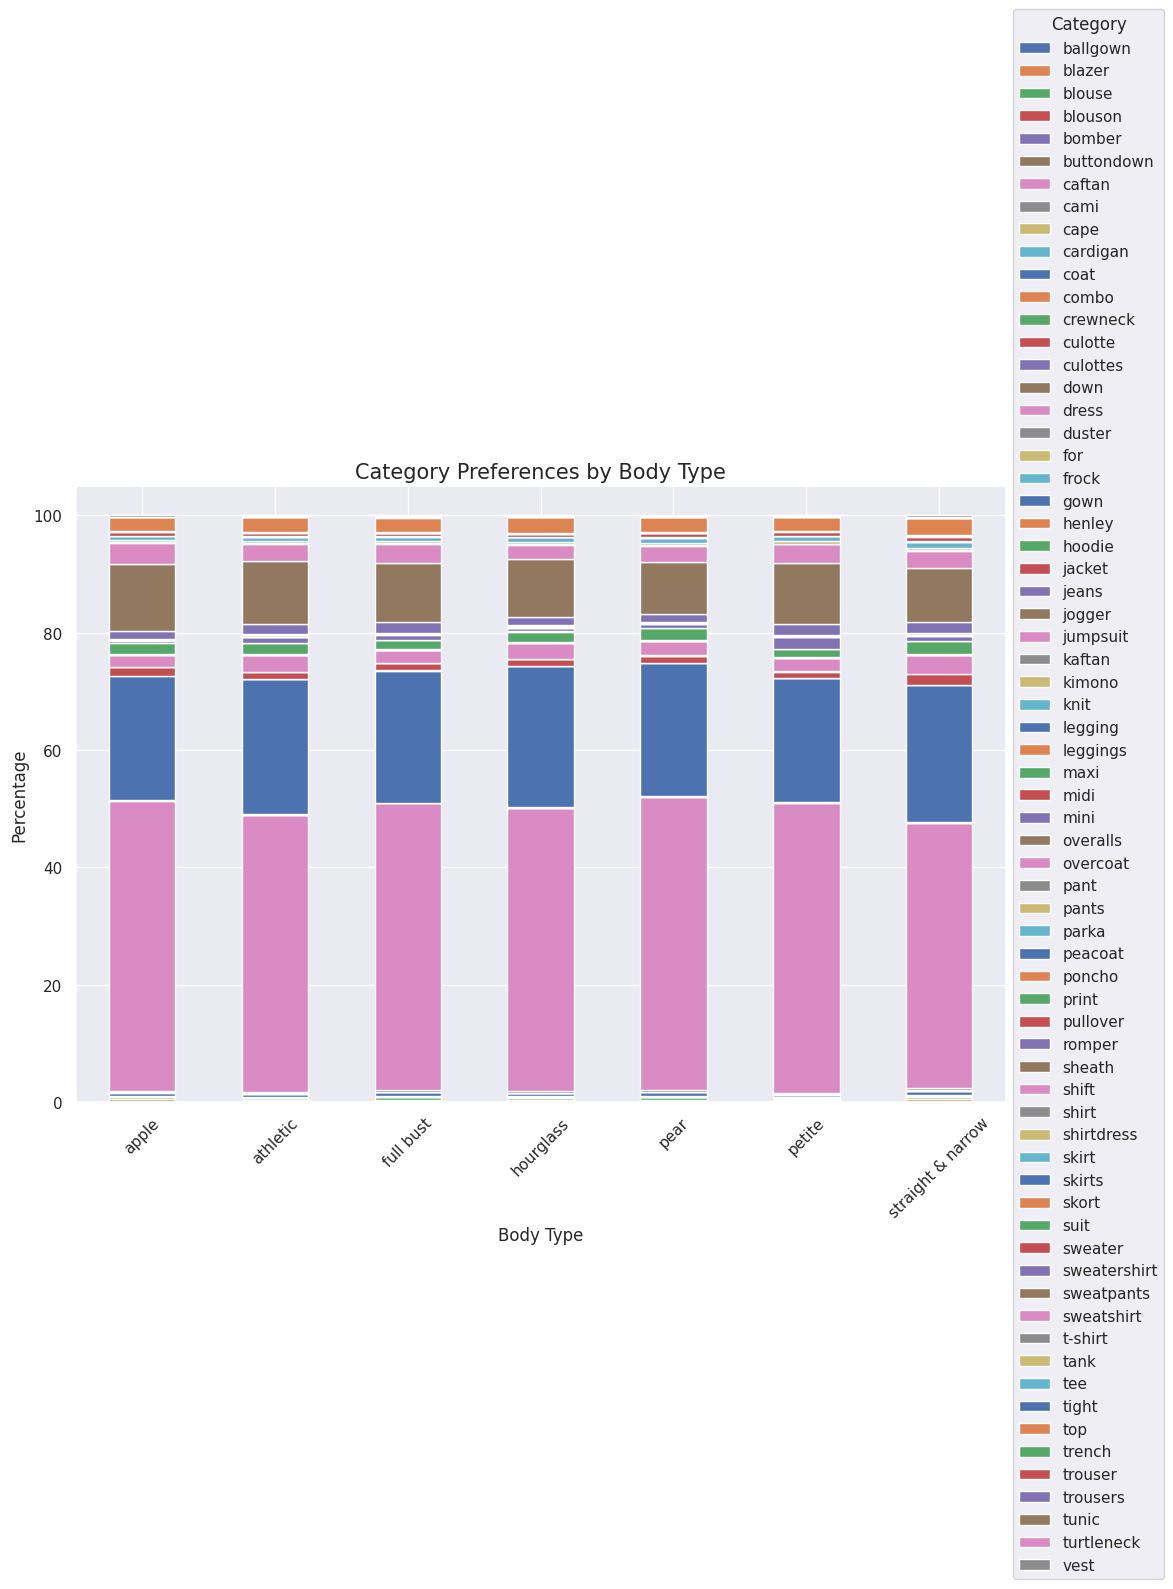

In [36]:
# Body type vs. category preference
body_category = pd.crosstab(df_mod['body_type'], df_mod['category'])
body_category_pct = body_category.div(body_category.sum(axis=1), axis=0) * 100

plt.figure(figsize=(16, 10))
body_category_pct.plot(kind='bar', stacked=True)
plt.title('Category Preferences by Body Type', fontsize=15)
plt.xlabel('Body Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Category', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x900 with 0 Axes>

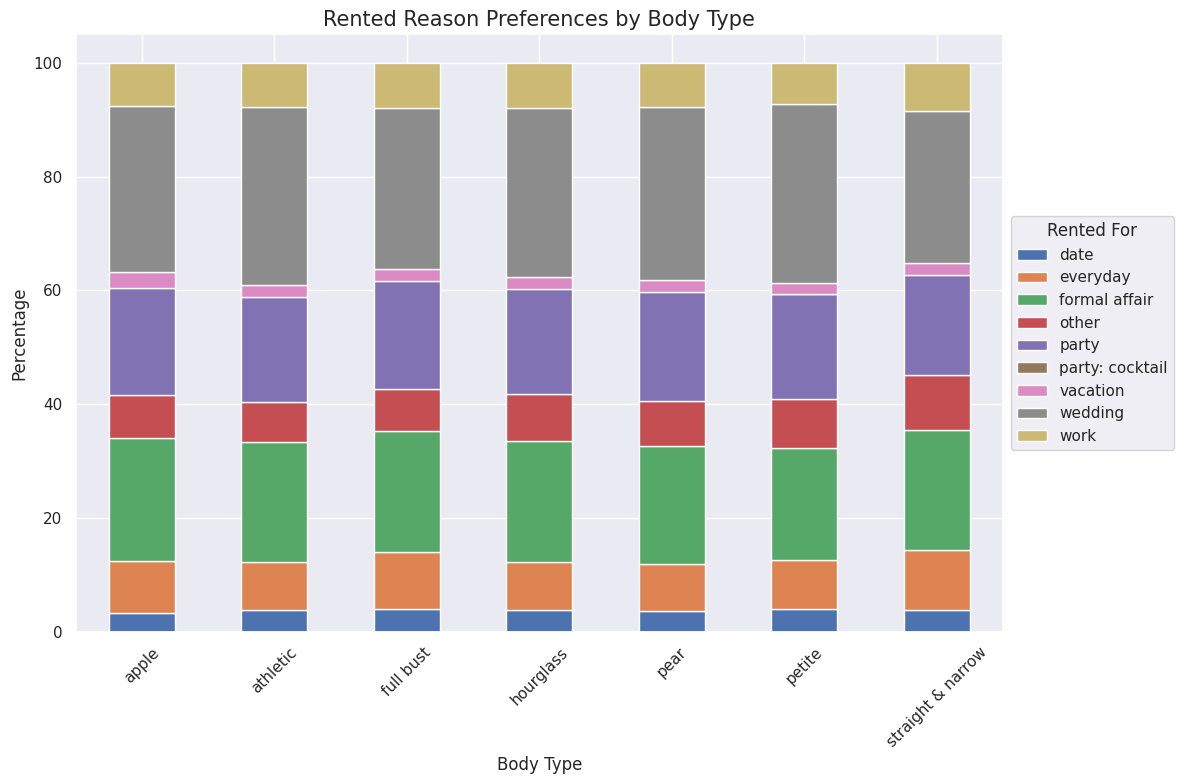

In [37]:
# Body type vs. rented reason
body_category = pd.crosstab(df_mod['body_type'], df_mod['rented_for'])
body_category_pct = body_category.div(body_category.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 9))
body_category_pct.plot(kind='bar', stacked=True)
plt.title('Rented Reason Preferences by Body Type', fontsize=15)
plt.xlabel('Body Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Rented For', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Age Group V/S Rented Reason

<Figure size 1600x1000 with 0 Axes>

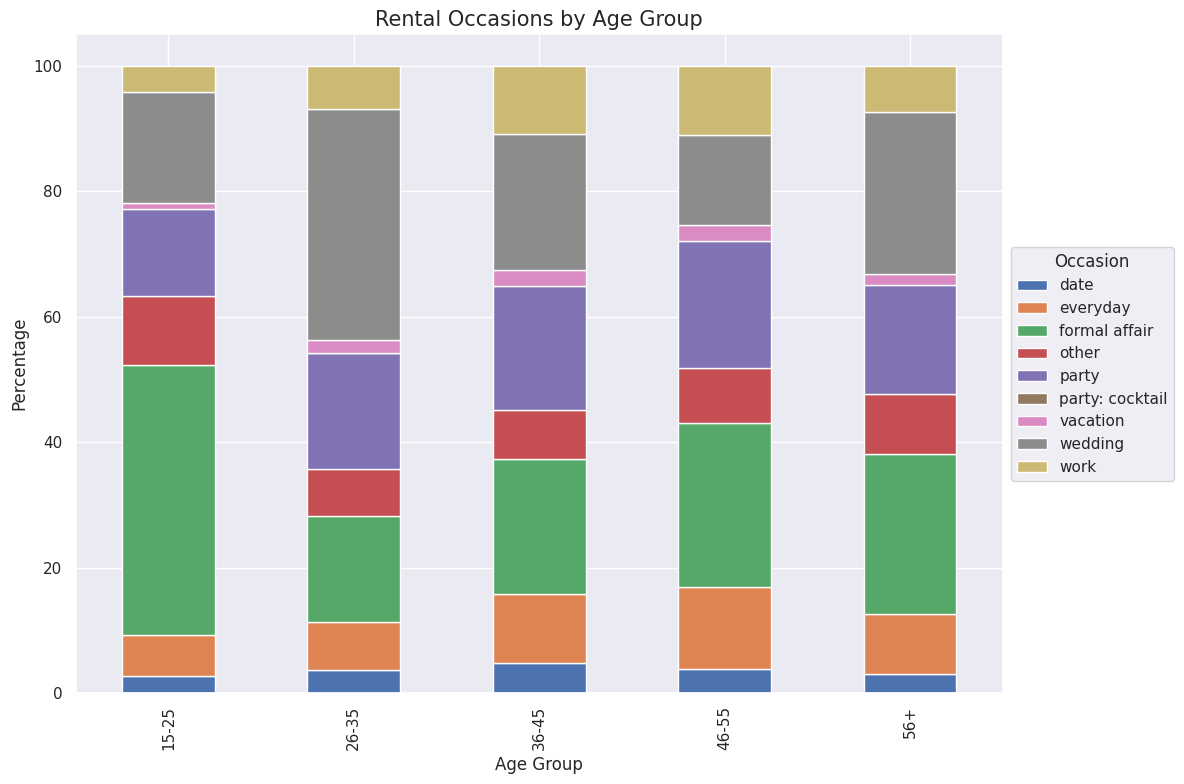

In [38]:
# Age group vs. rental occasion
df_mod['age_group'] = pd.cut(df_mod['age'], bins=[15, 25, 35, 45, 55, 100], 
                         labels=['15-25', '26-35', '36-45', '46-55', '56+'])
age_occasion = pd.crosstab(df_mod['age_group'], df_mod['rented_for'])
age_occasion_pct = age_occasion.div(age_occasion.sum(axis=1), axis=0) * 100

plt.figure(figsize=(16, 10))
age_occasion_pct.plot(kind='bar', stacked=True)
plt.title('Rental Occasions by Age Group', fontsize=15)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Occasion', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Age Group and Rating

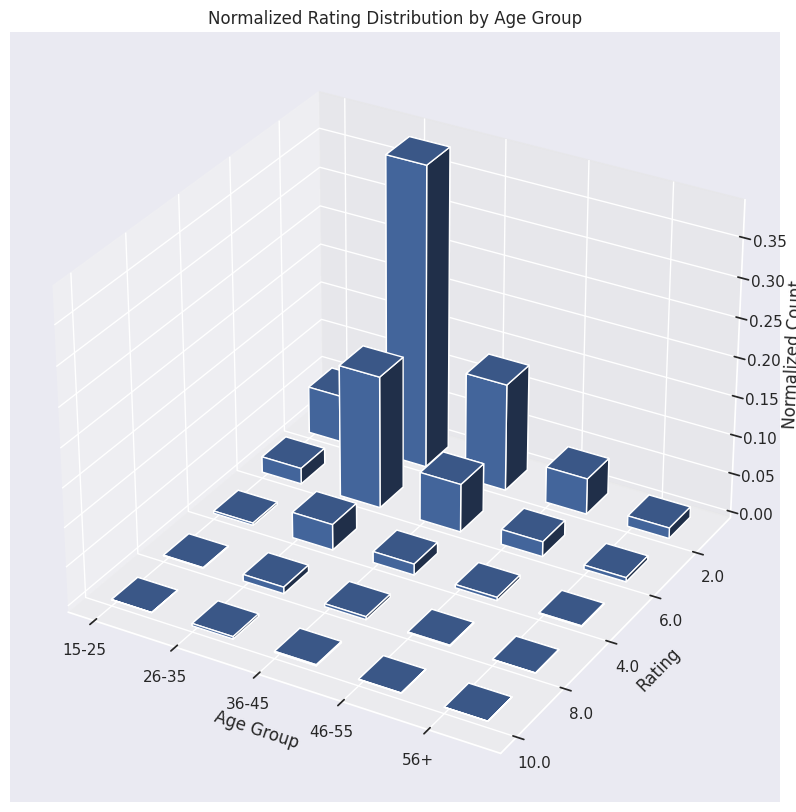

In [39]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

ratings = df_mod['rating'].unique()
age_groups = ['15-25', '26-35', '36-45', '46-55', '56+']
x_pos = range(len(age_groups))
y_pos = range(len(ratings))
x_labels, y_labels = np.meshgrid(x_pos, y_pos)

# Calculate normalized counts
age_rating_counts = pd.crosstab(df_mod['age_group'], df_mod['rating'])
age_rating_counts = age_rating_counts.div(age_rating_counts.sum().sum())
z_values = age_rating_counts.T.values.flatten()

ax.bar3d(x_labels.flatten(), y_labels.flatten(), np.zeros_like(z_values), 
         dx=0.5, dy=0.5, dz=z_values, shade=True)

ax.set_xticks(x_pos)
ax.set_yticks(y_pos)
ax.set_xticklabels(age_groups)
ax.set_yticklabels(ratings)
ax.set_xlabel('Age Group')
ax.set_ylabel('Rating')
ax.set_zlabel('Normalized Count')
ax.set_title('Normalized Rating Distribution by Age Group')
plt.show()

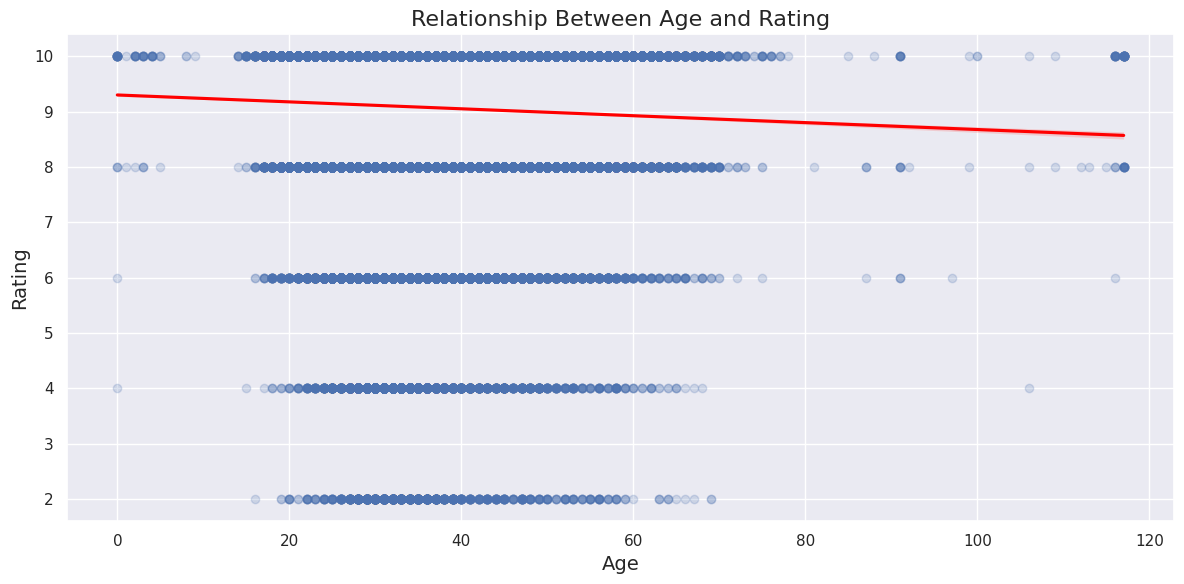

Average Rating by Age Group:
15-25: 9.31 (n=16361)
26-35: 9.09 (n=115912)
36-45: 9.02 (n=42218)
46-55: 9.07 (n=13740)
56-65: 9.09 (n=3553)
66+: 9.16 (n=416)


In [40]:
plt.figure(figsize=(12, 6))
sns.regplot(x='age', y='rating', data=df_mod, scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
plt.title('Relationship Between Age and Rating', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.tight_layout()
plt.show()

# Calculate average rating by age group
age_groups = pd.cut(df_mod['age'], bins=[15, 25, 35, 45, 55, 65, 100], 
                    labels=['15-25', '26-35', '36-45', '46-55', '56-65', '66+'])
avg_rating_by_age = df_mod.groupby(age_groups)['rating'].agg(['mean', 'count']).reset_index()
avg_rating_by_age.columns = ['Age Group', 'Average Rating', 'Count']
print("Average Rating by Age Group:")
for _, row in avg_rating_by_age.iterrows():
    print(f"{row['Age Group']}: {row['Average Rating']:.2f} (n={int(row['Count'])})")


### Weight and Rating

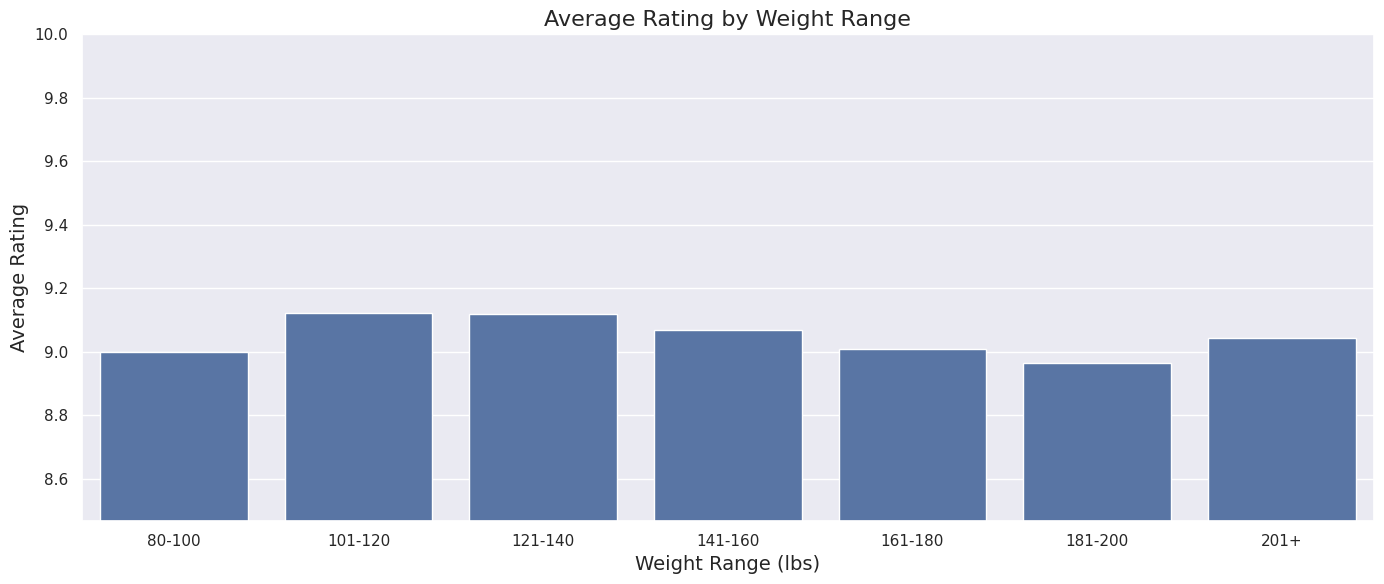

In [41]:
# Create weight brackets
weight_brackets = pd.cut(df_mod['weight'], 
                        bins=[80, 100, 120, 140, 160, 180, 200, 300],
                        labels=['80-100', '101-120', '121-140', '141-160', 
                                '161-180', '181-200', '201+'])


# Calculate average rating by weight group
avg_rating_by_weight = df_mod.groupby(weight_brackets)['rating'].mean().reset_index()
avg_rating_by_weight.columns = ['Weight Range', 'Average Rating']

plt.figure(figsize=(14, 6))
sns.barplot(x='Weight Range', y='Average Rating', data=avg_rating_by_weight)
plt.title('Average Rating by Weight Range', fontsize=16)
plt.xlabel('Weight Range (lbs)', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.ylim(min(avg_rating_by_weight['Average Rating'])-0.5, 10)
plt.tight_layout()
plt.show()


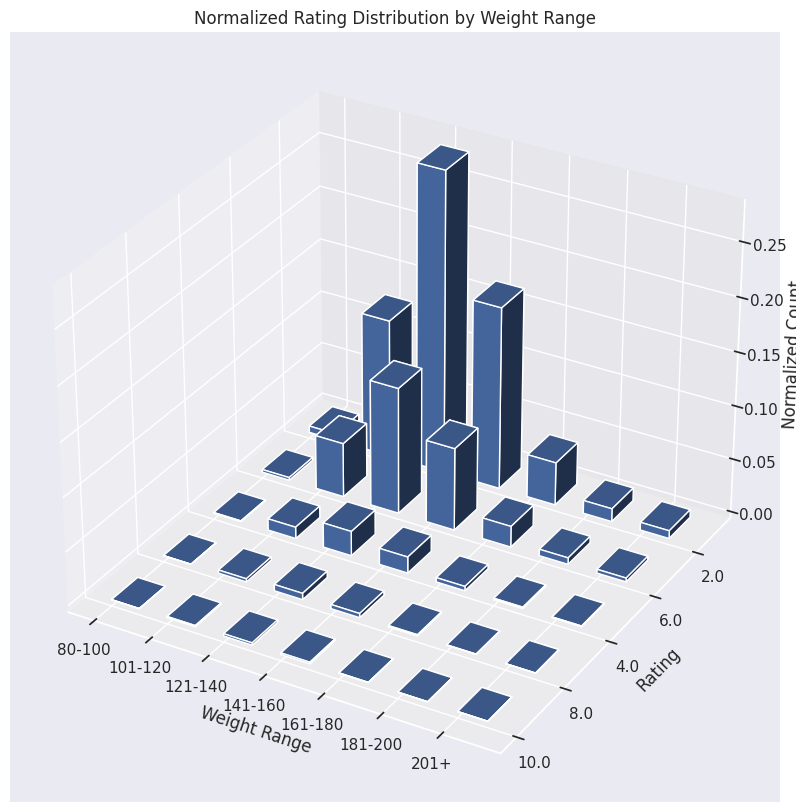

In [42]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

ratings = df_mod['rating'].unique()
weight_groups = ['80-100', '101-120', '121-140', '141-160', '161-180', '181-200', '201+']
x_pos = range(len(weight_groups))
y_pos = range(len(ratings))
x_labels, y_labels = np.meshgrid(x_pos, y_pos)

# Normalized counts
weight_rating_counts = pd.crosstab(weight_brackets, df_mod['rating'])
weight_rating_counts = weight_rating_counts.div(weight_rating_counts.sum().sum())
z_values = weight_rating_counts.T.values.flatten()

ax.bar3d(x_labels.flatten(), y_labels.flatten(), np.zeros_like(z_values), 
         dx=0.5, dy=0.5, dz=z_values, shade=True)

ax.set_xticks(x_pos)
ax.set_yticks(y_pos)
ax.set_xticklabels(weight_groups)
ax.set_yticklabels(ratings)
ax.set_xlabel('Weight Range')
ax.set_ylabel('Rating')
ax.set_zlabel('Normalized Count')
ax.set_title('Normalized Rating Distribution by Weight Range')
plt.show()

### Body Type V/S Age Group V/S Category

In [43]:
# Create a multivariate bubble chart: body type, age group, and category
body_age_category = df_mod.groupby(['body_type', 'age_group', 'category']).size().reset_index(name='count')

# Filter to top body types, age groups, and categories 
top_body_types = df_mod['body_type'].value_counts().head(5).index
top_categories = df_mod['category'].value_counts().head(5).index
filtered_data = body_age_category[
    (body_age_category['body_type'].isin(top_body_types)) & 
    (body_age_category['category'].isin(top_categories)) &
    (body_age_category['age_group'].notna())
]

# Create bubble chart
import plotly.express as px

fig = px.scatter(
    filtered_data, 
    x='body_type', 
    y='age_group',
    size='count', 
    color='category',
    hover_name='category',
    size_max=60,
    title='Rental Patterns by Body Type, Age Group, and Category'
)

fig.update_layout(
    xaxis_title='Body Type',
    yaxis_title='Age Group',
    legend_title='Category'
)
fig.show()


In [44]:
# Create a multivariate bubble chart: rented reason, age group, and category
body_age_category = df_mod.groupby(['rented_for', 'age_group', 'category']).size().reset_index(name='count')

# Filter to top body types, age groups, and categories 
top_body_types = df_mod['rented_for'].value_counts().head(5).index
top_categories = df_mod['category'].value_counts().head(5).index
filtered_data = body_age_category[
    (body_age_category['rented_for'].isin(top_body_types)) & 
    (body_age_category['category'].isin(top_categories)) &
    (body_age_category['age_group'].notna())
]

# Create bubble chart 
import plotly.express as px

fig = px.scatter(
    filtered_data, 
    x='rented_for', 
    y='age_group',
    size='count', 
    color='category',
    hover_name='category',
    size_max=60,
    title='Rental Patterns by Rented Reason, Age Group, and Category'
)

fig.update_layout(
    xaxis_title='Rented Reason',
    yaxis_title='Age Group',
    legend_title='Category'
)
fig.show()


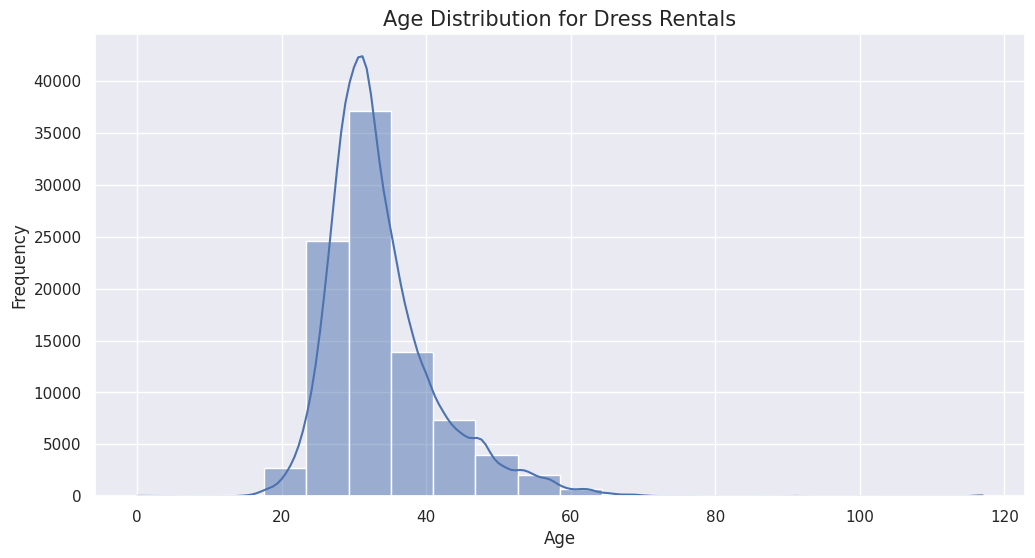

In [45]:
# Filter for dress category
dress_data = df_mod[df_mod['category'] == 'dress']

# Age distribution for dress rentals
plt.figure(figsize=(12, 6))
sns.histplot(dress_data['age'].dropna(), bins=20, kde=True)
plt.title('Age Distribution for Dress Rentals', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


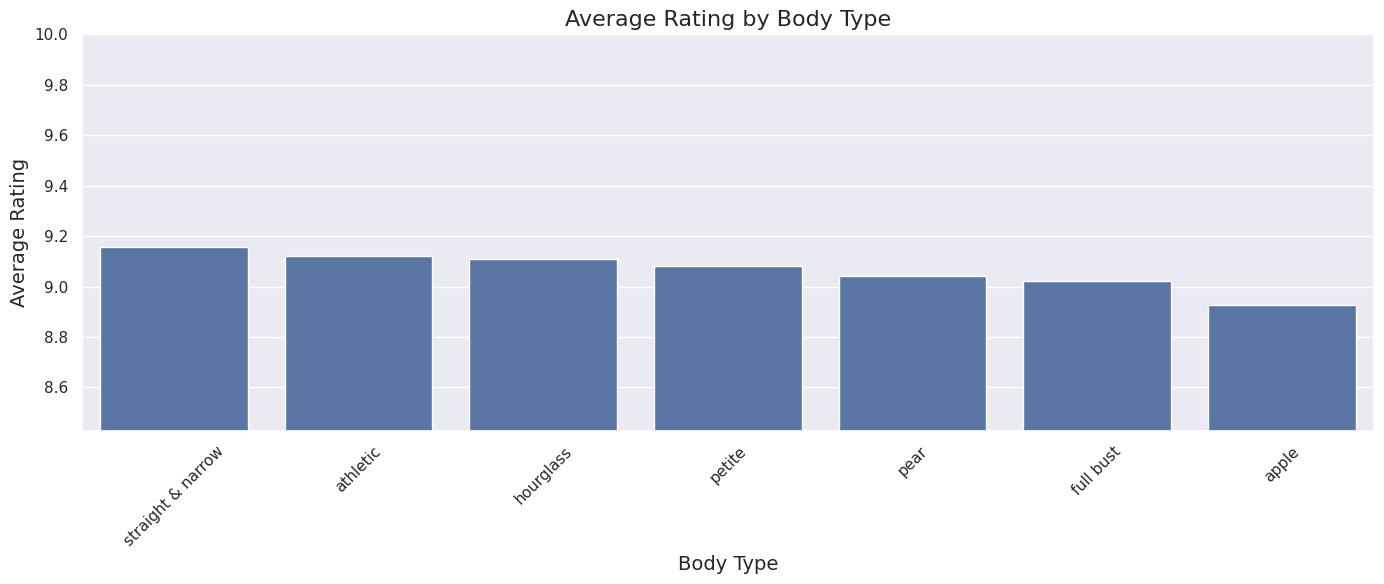

Average Rating by Body Type:
straight & narrow: 9.16 (n=14727)
athletic: 9.12 (n=43631)
hourglass: 9.11 (n=69915)
petite: 9.08 (n=22113)
pear: 9.04 (n=22105)
full bust: 9.02 (n=14993)
apple: 8.93 (n=4871)


In [46]:
# Get top body types
top_body_types = df_mod['body_type'].value_counts().head(10).index

# Filter data for top body types
df_top_body = df_mod[df_mod['body_type'].isin(top_body_types)]

# Calculate average rating by body type
avg_rating_by_body = df_top_body.groupby('body_type')['rating'].agg(['mean', 'count']).reset_index()
avg_rating_by_body.columns = ['Body Type', 'Average Rating', 'Count']
avg_rating_by_body = avg_rating_by_body.sort_values('Average Rating', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='Body Type', y='Average Rating', data=avg_rating_by_body)
plt.title('Average Rating by Body Type', fontsize=16)
plt.xlabel('Body Type', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.ylim(min(avg_rating_by_body['Average Rating'])-0.5, 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Average Rating by Body Type:")
for _, row in avg_rating_by_body.iterrows():
    print(f"{row['Body Type']}: {row['Average Rating']:.2f} (n={int(row['Count'])})")


## Product Analysis

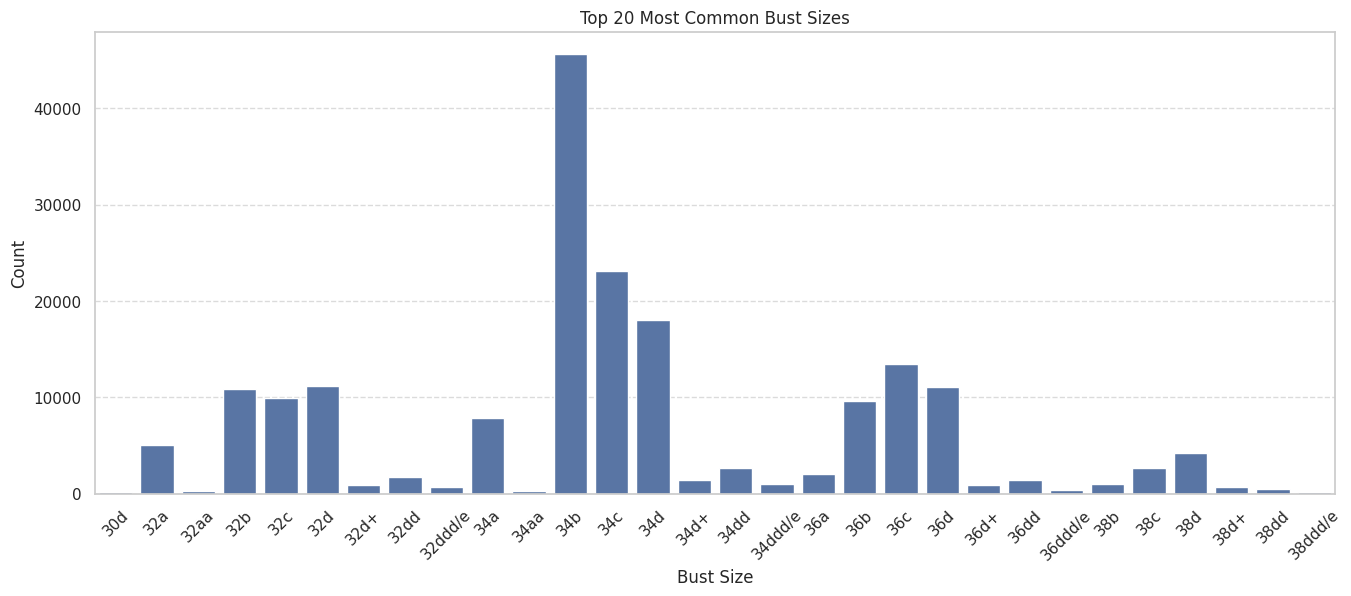

In [47]:
bust_size_counts = df_mod['bust_size'].value_counts().nlargest(30).sort_index()

sns.barplot(x=bust_size_counts.index, y=bust_size_counts.values)

plt.title('Top 20 Most Common Bust Sizes')
plt.xlabel('Bust Size')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  

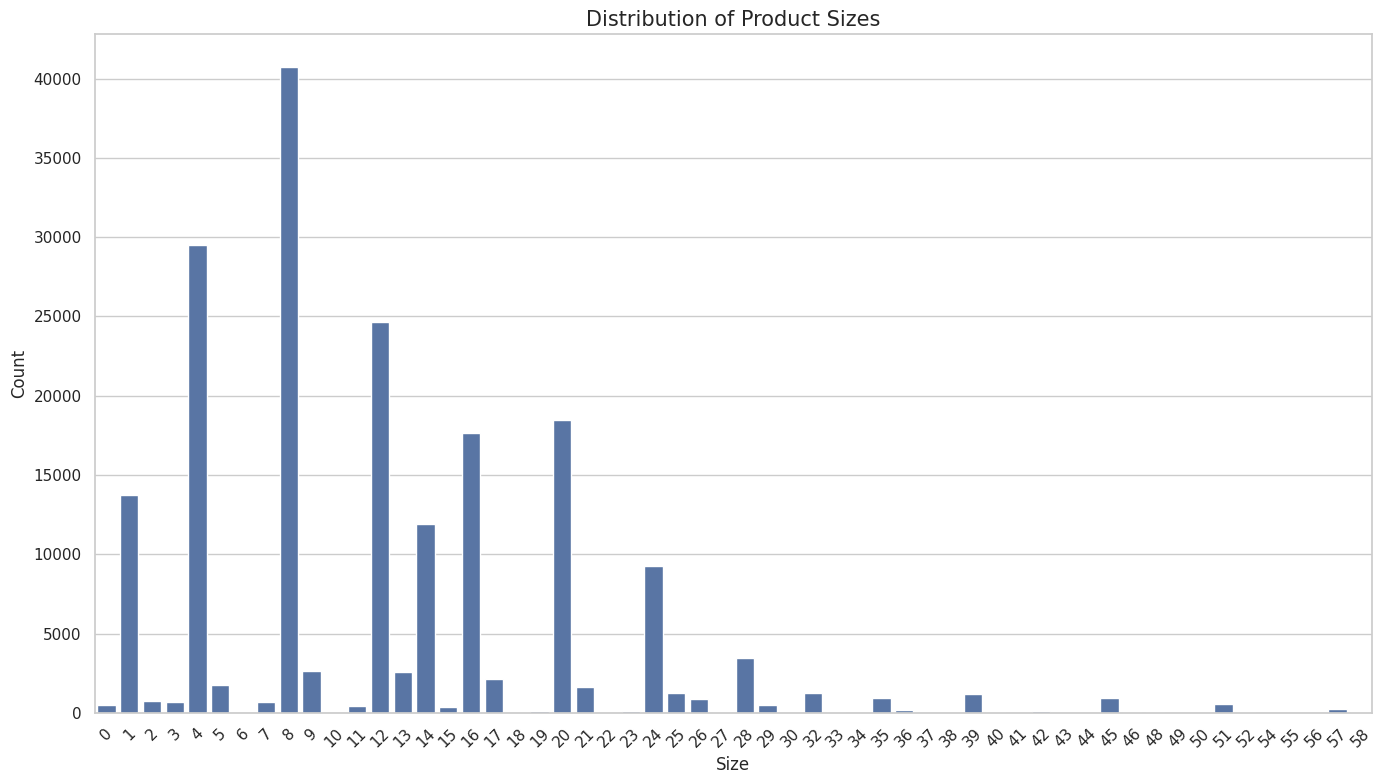

In [48]:
# Analyze size distribution
size_counts = df_mod['size'].value_counts().sort_index()
plt.figure(figsize=(14, 8))
sns.barplot(x=size_counts.index.astype(str), y=size_counts.values)
plt.title('Distribution of Product Sizes', fontsize=15)
plt.xlabel('Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

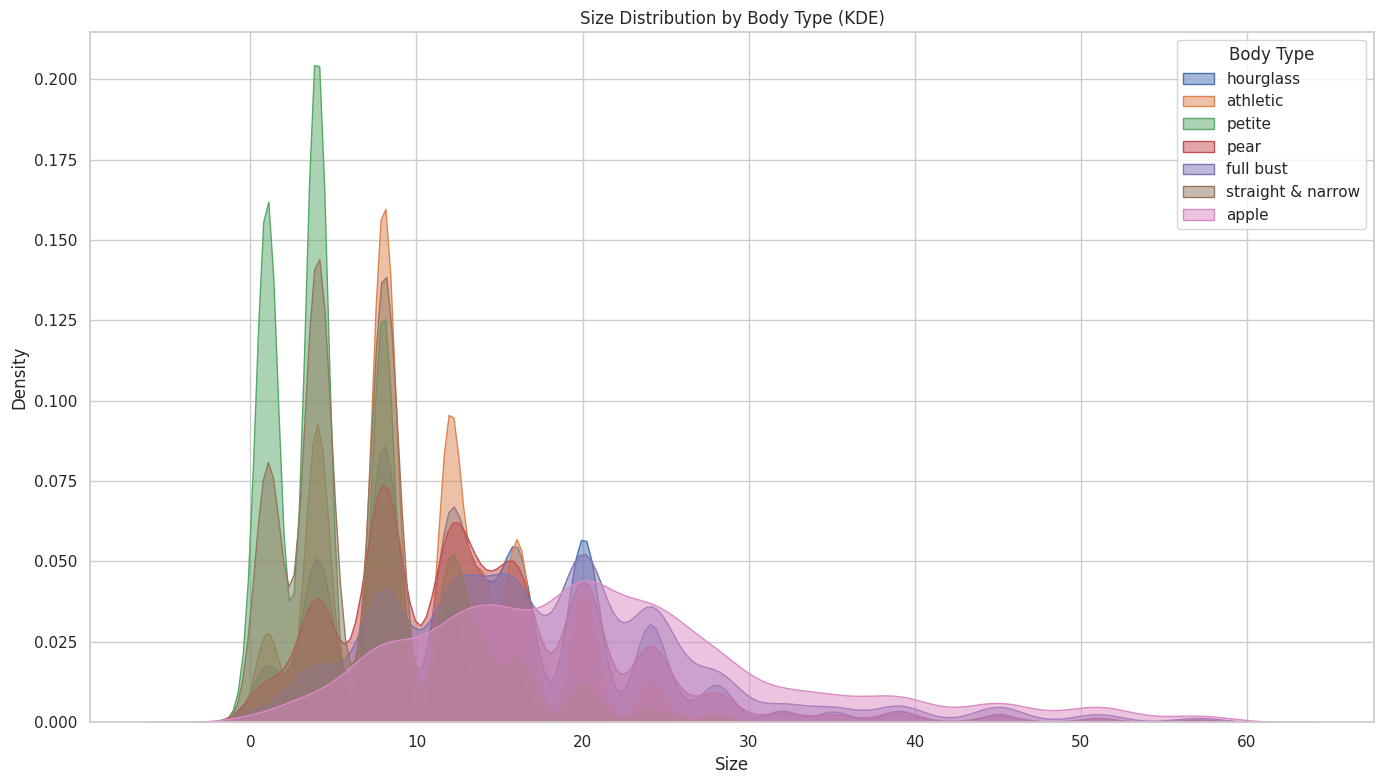

In [49]:
df_mod['size_numeric'] = pd.to_numeric(df_mod['size'])
size_col = 'size_numeric'

# Create KDE plot for top body types
plt.figure(figsize=(14, 8))
for bt in top_body_types:
    subset = df_mod[df_mod['body_type'] == bt]
    sns.kdeplot(subset[size_col], label=bt, fill=True, alpha=0.5)

plt.title('Size Distribution by Body Type (KDE)')
plt.xlabel('Size')
plt.ylabel('Density')
plt.legend(title='Body Type')
plt.tight_layout()
plt.show()

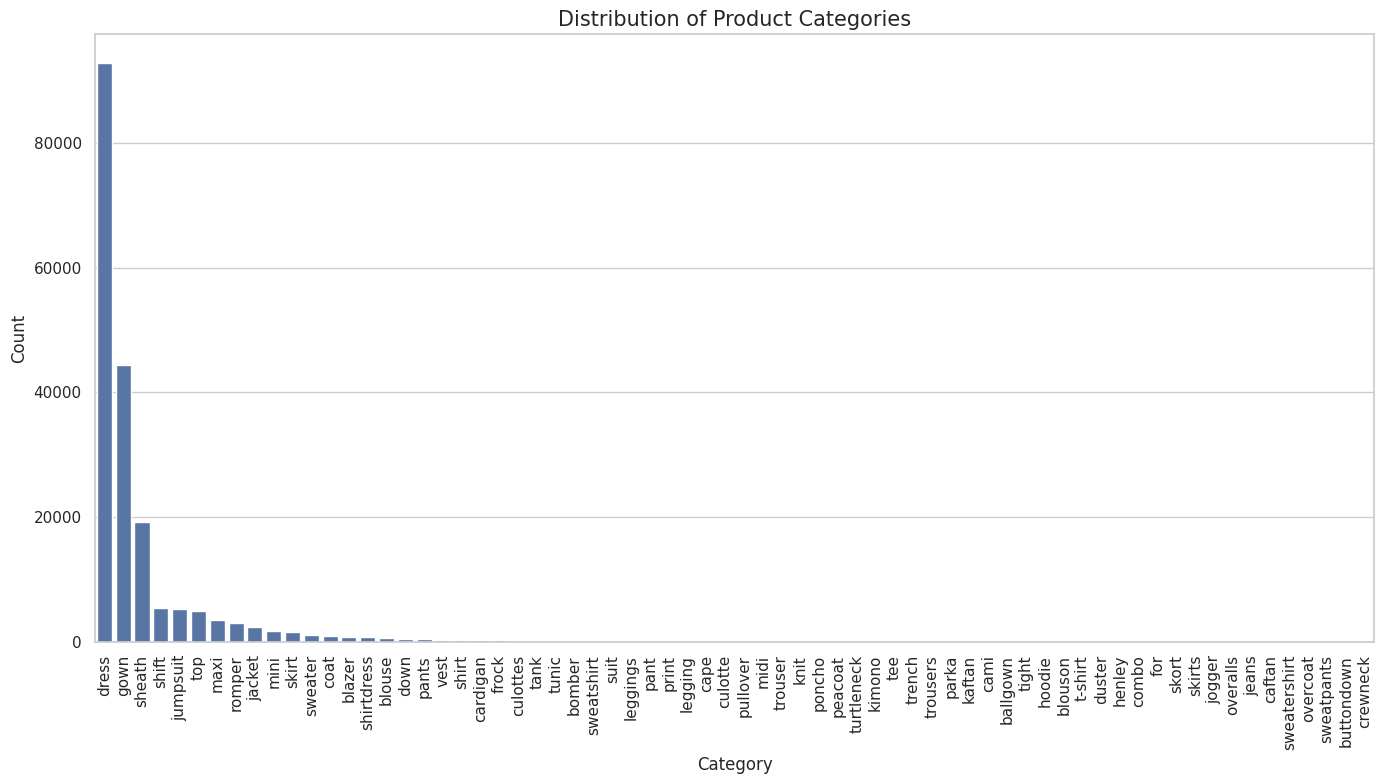

In [50]:
# Analyze category distribution
category_counts = df_mod['category'].value_counts()
plt.figure(figsize=(14, 8))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribution of Product Categories', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Top 20 Most Popular Items by Rental Count

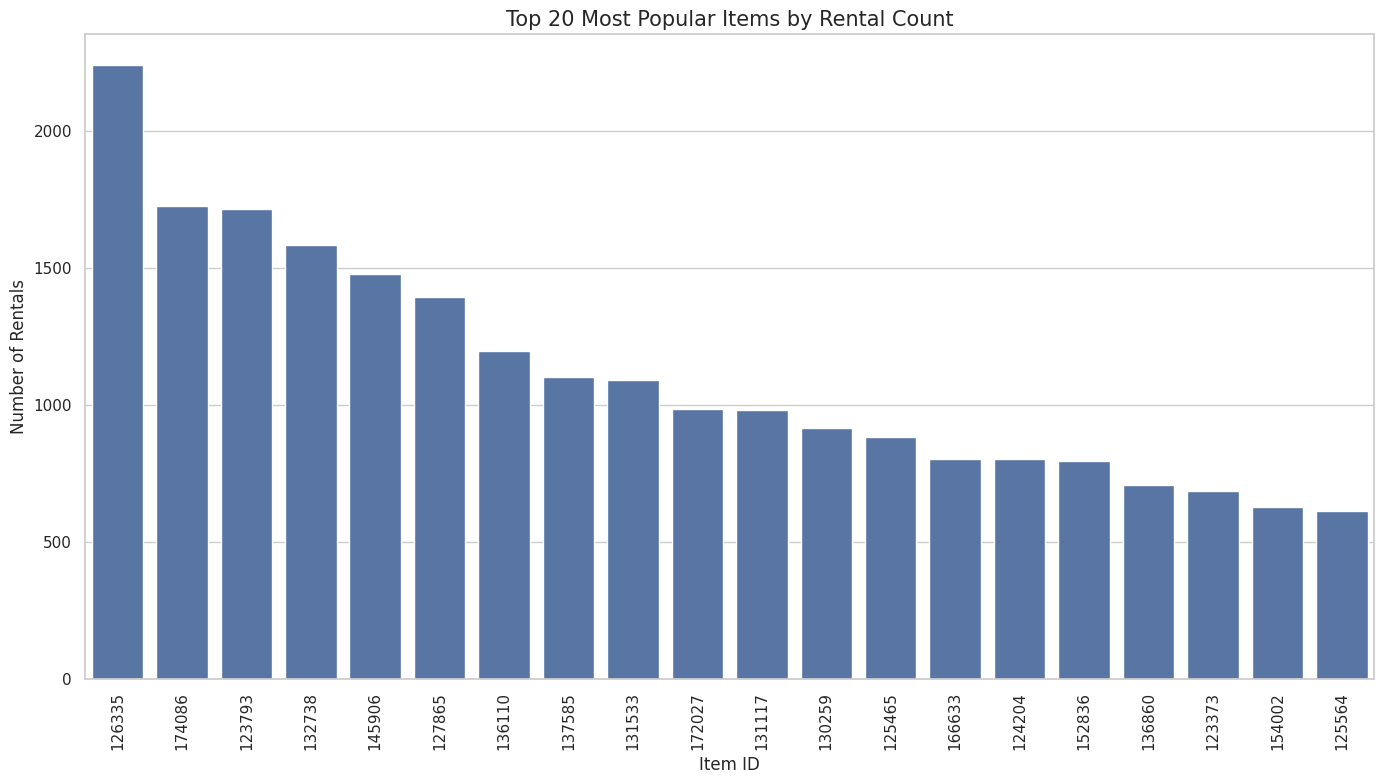

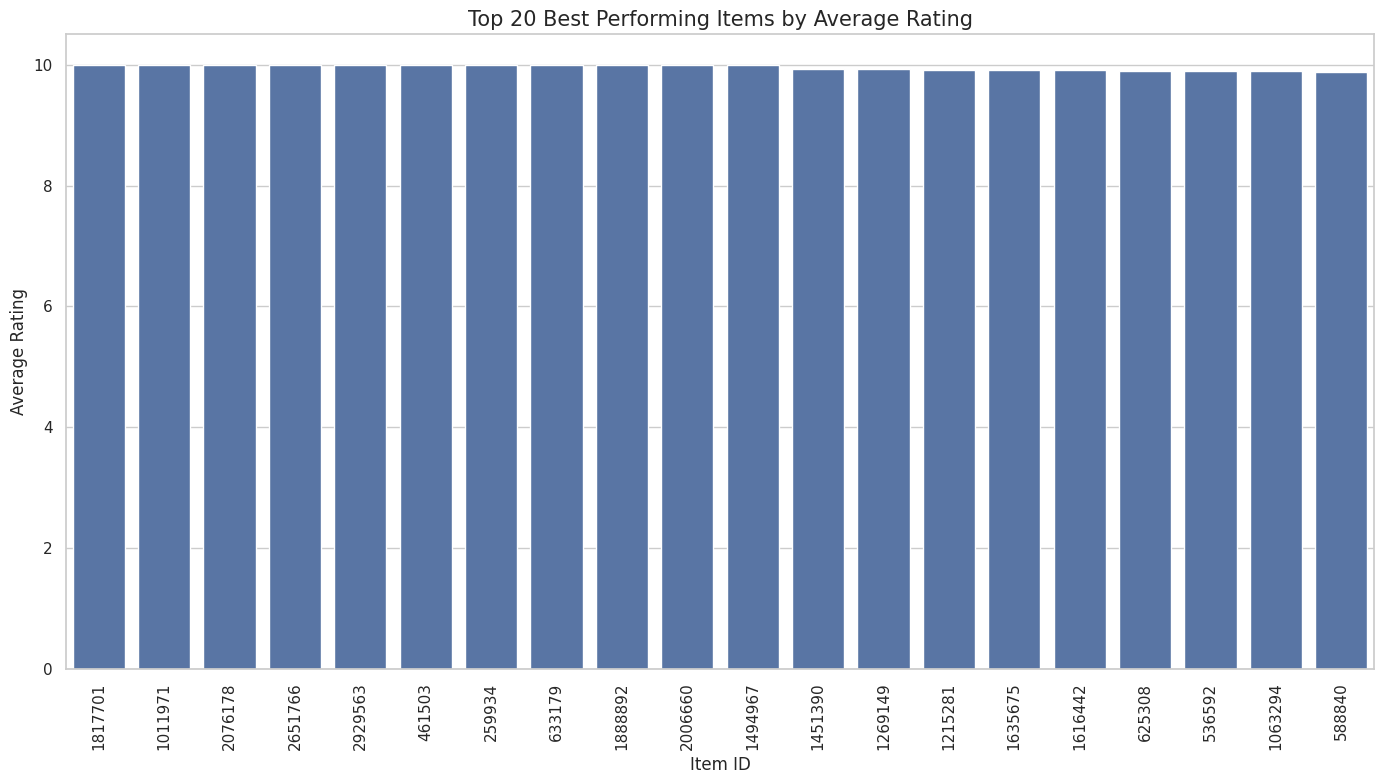

In [51]:
# Most popular items (by rental count)
item_popularity = df_mod['item_id'].value_counts().head(20)
plt.figure(figsize=(14, 8))
sns.barplot(x=item_popularity.index.astype(str), y=item_popularity.values)
plt.title('Top 20 Most Popular Items by Rental Count', fontsize=15)
plt.xlabel('Item ID', fontsize=12)
plt.ylabel('Number of Rentals', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Item performance (average rating)
item_performance = df_mod.groupby('item_id')['rating'].agg(['mean', 'count']).sort_values(by='count', ascending=False)
item_performance = item_performance[item_performance['count'] > 10]  # Filter for items with >10 rentals
top_performing_items = item_performance.sort_values(by='mean', ascending=False).head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_performing_items.index.astype(str), y=top_performing_items['mean'])
plt.title('Top 20 Best Performing Items by Average Rating', fontsize=15)
plt.xlabel('Item ID', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Top 20 most popular and best performing items

/tmp/ipykernel_2121/3769136781.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




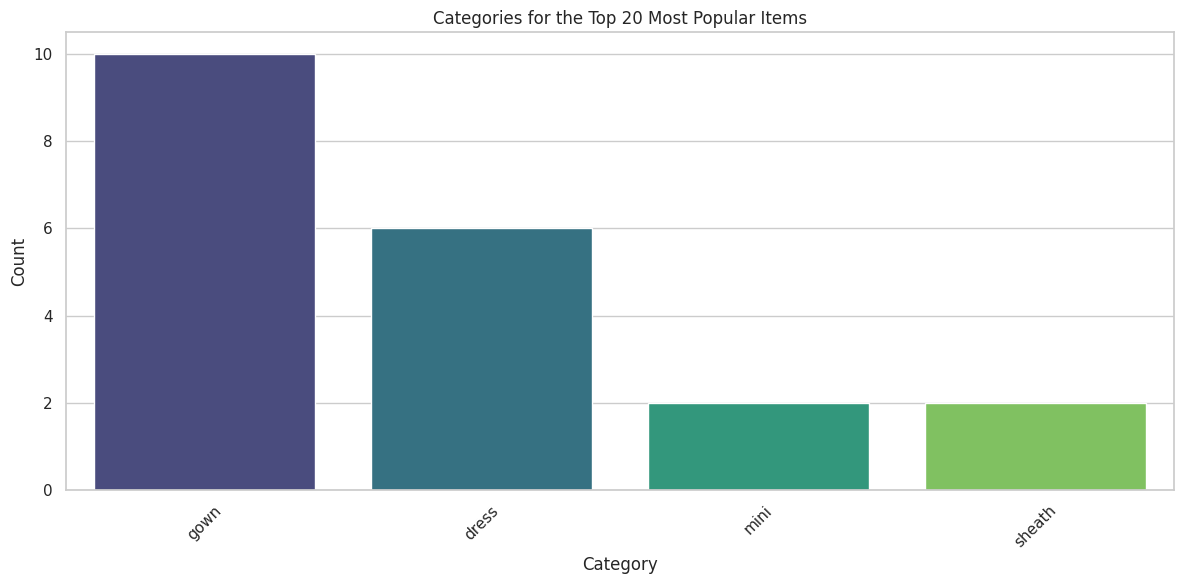

/tmp/ipykernel_2121/3769136781.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




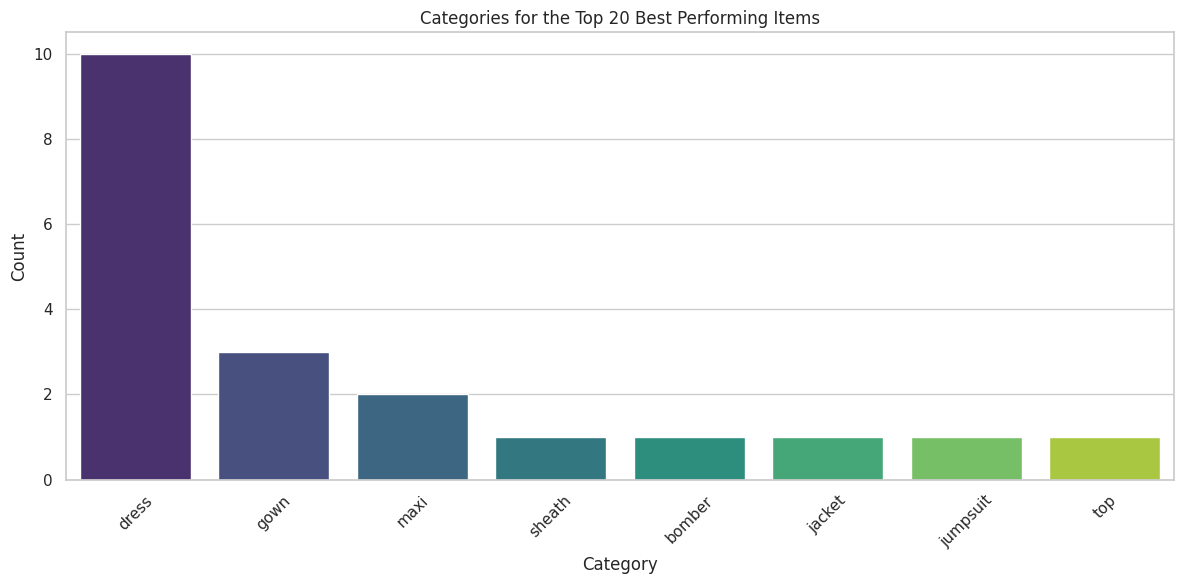

In [52]:
# Get the category for the most popular items
popular_item_categories = df_mod[df_mod['item_id'].isin(item_popularity.index)][['item_id', 'category']].drop_duplicates()
popular_category_counts = popular_item_categories['category'].value_counts()

# Get the category for the top-performing items
top_item_categories = df_mod[df_mod['item_id'].isin(top_performing_items.index)][['item_id', 'category']].drop_duplicates()
top_category_counts = top_item_categories['category'].value_counts()

# Plot for most popular items
plt.figure(figsize=(12, 6))
sns.barplot(x=popular_category_counts.index, y=popular_category_counts.values, palette='viridis')
plt.title('Categories for the Top 20 Most Popular Items')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for top-performing items
plt.figure(figsize=(12, 6))
sns.barplot(x=top_category_counts.index, y=top_category_counts.values, palette='viridis')
plt.title('Categories for the Top 20 Best Performing Items')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Category Popularity over time

<Figure size 1600x800 with 0 Axes>

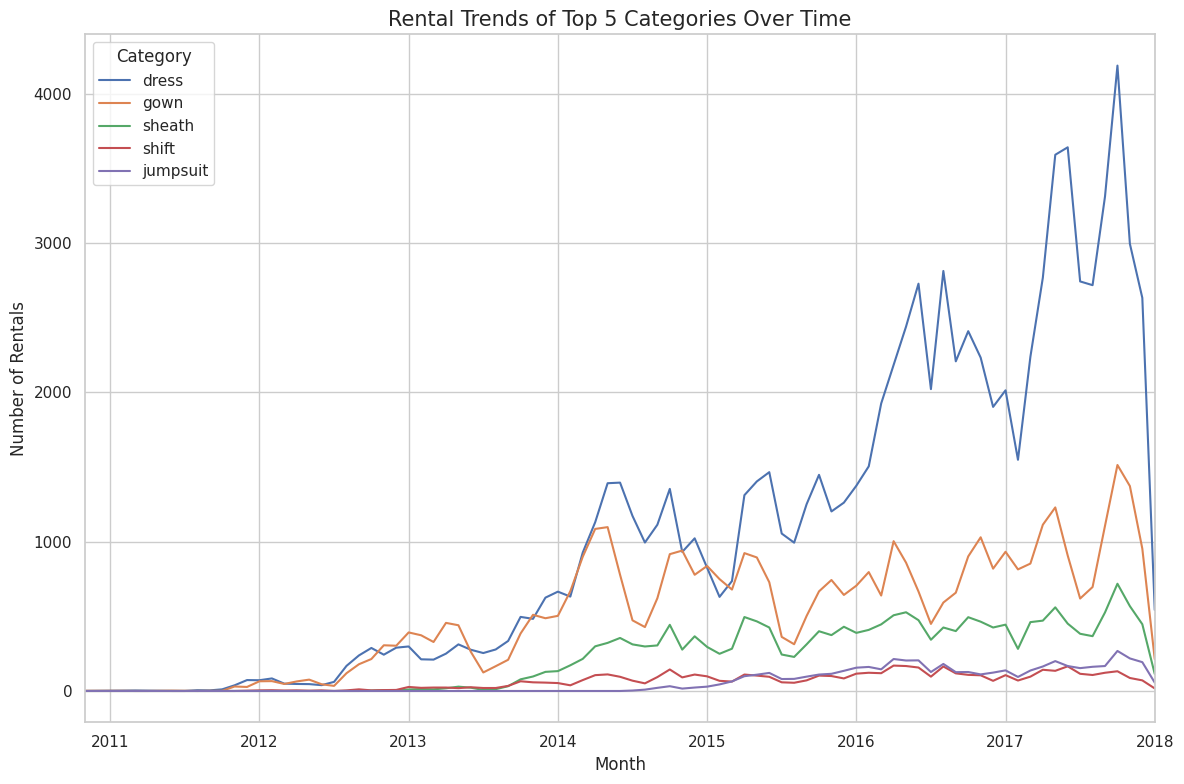

In [53]:
# Category popularity over time
df_mod['review_date'] = pd.to_datetime(df_mod['review_date'])
df_mod['year_month'] = df_mod['review_date'].dt.to_period('M')
category_time = pd.crosstab(df_mod['year_month'], df_mod['category'])

# Select top 5 categories
top_categories = df_mod['category'].value_counts().head(5).index
category_time_top = category_time[top_categories]

plt.figure(figsize=(16, 8))
category_time_top.plot(kind='line')
plt.title('Rental Trends of Top 5 Categories Over Time', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Rentals', fontsize=12)
plt.legend(title='Category')
plt.tight_layout()
plt.show()


### Top 15 Categories - Average rating 

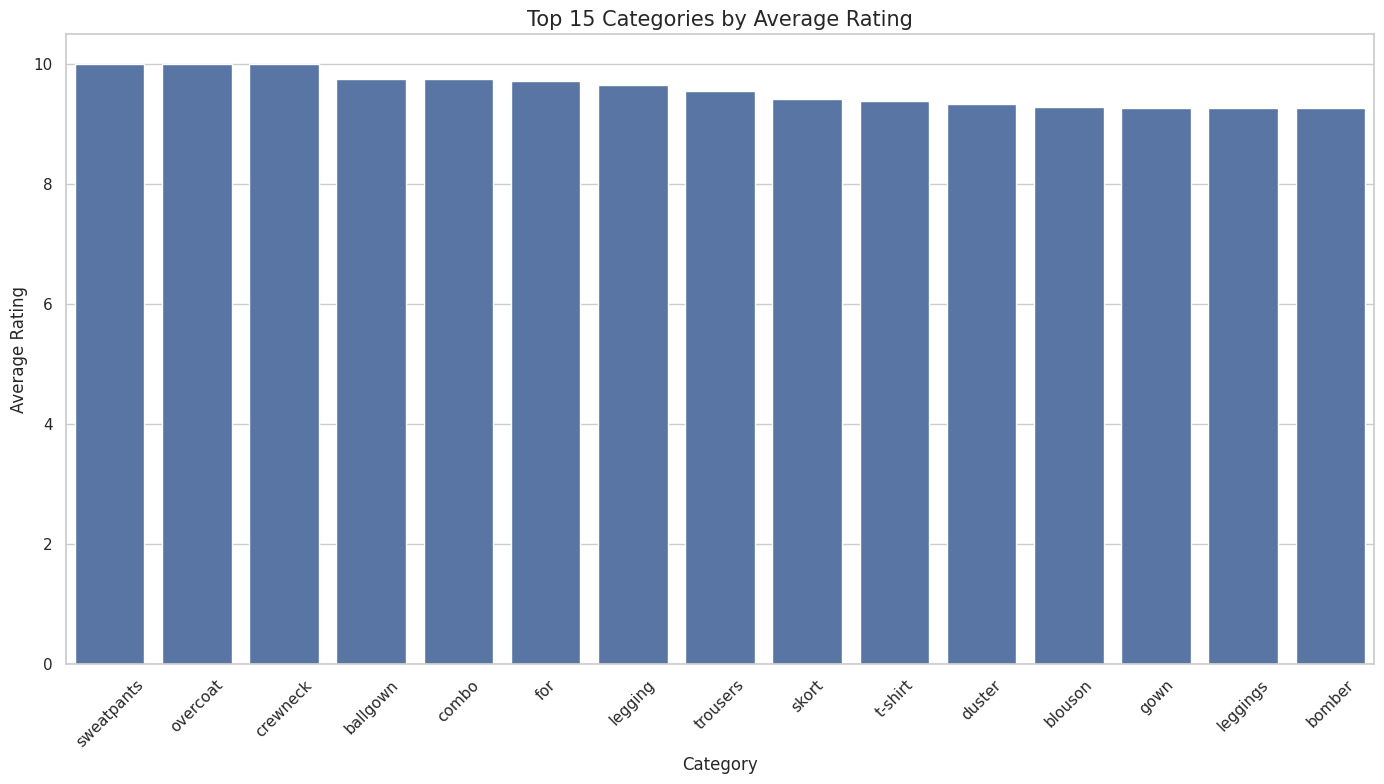

In [54]:
# Average rating by category
category_ratings = df_mod.groupby('category')['rating'].agg(['mean', 'count']).reset_index()
category_ratings = category_ratings.sort_values('mean', ascending=False)

# Top categories by average rating
plt.figure(figsize=(14, 8))
sns.barplot(x='category', y='mean', data=category_ratings.head(15))
plt.title('Top 15 Categories by Average Rating', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 15 Categories by Rental Frequency

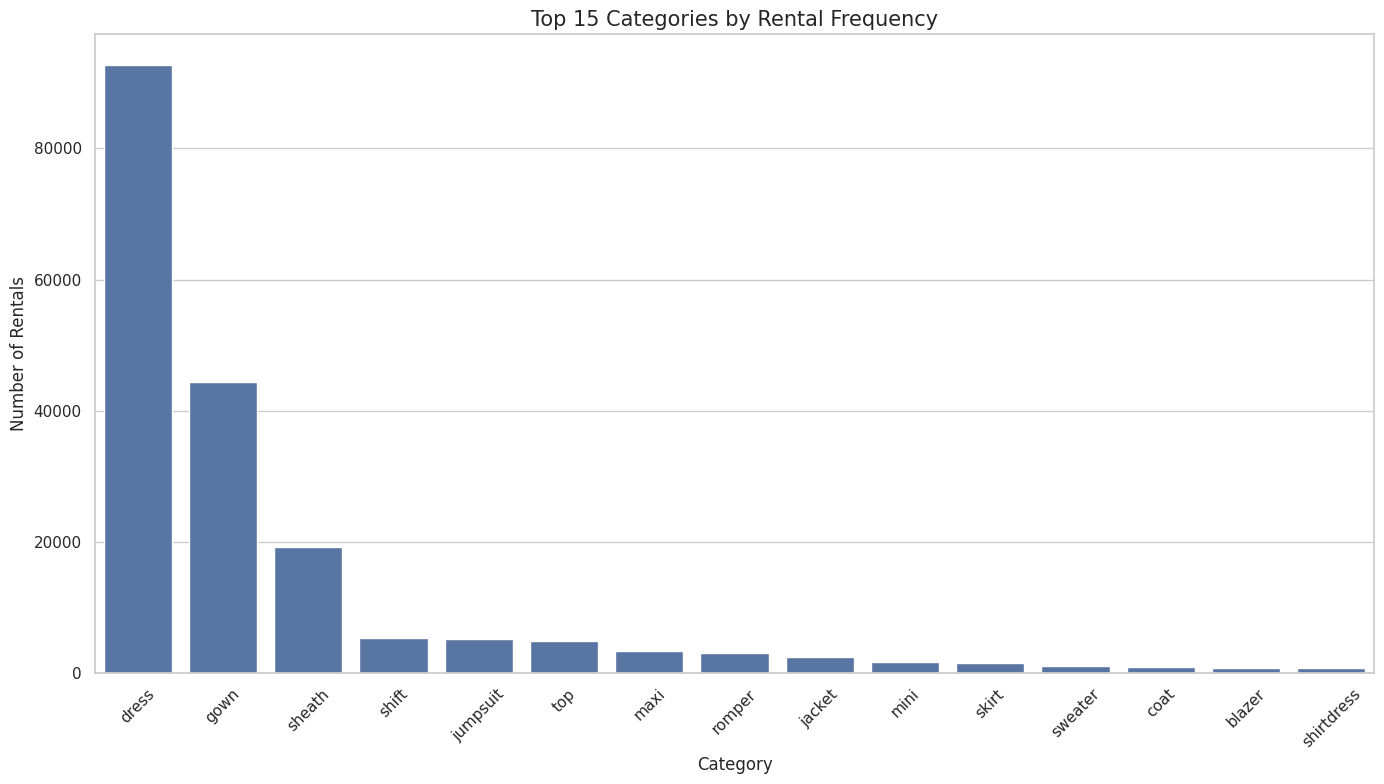

In [55]:
# Calculate rental popularity by category
category_popularity = df_mod.groupby('category').size().reset_index(name='rental_count')
category_popularity = category_popularity.sort_values('rental_count', ascending=False)

# Top categories by rental count
plt.figure(figsize=(14, 8))
sns.barplot(x='category', y='rental_count', data=category_popularity.head(15))
plt.title('Top 15 Categories by Rental Frequency', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Rentals', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 15 categories overall

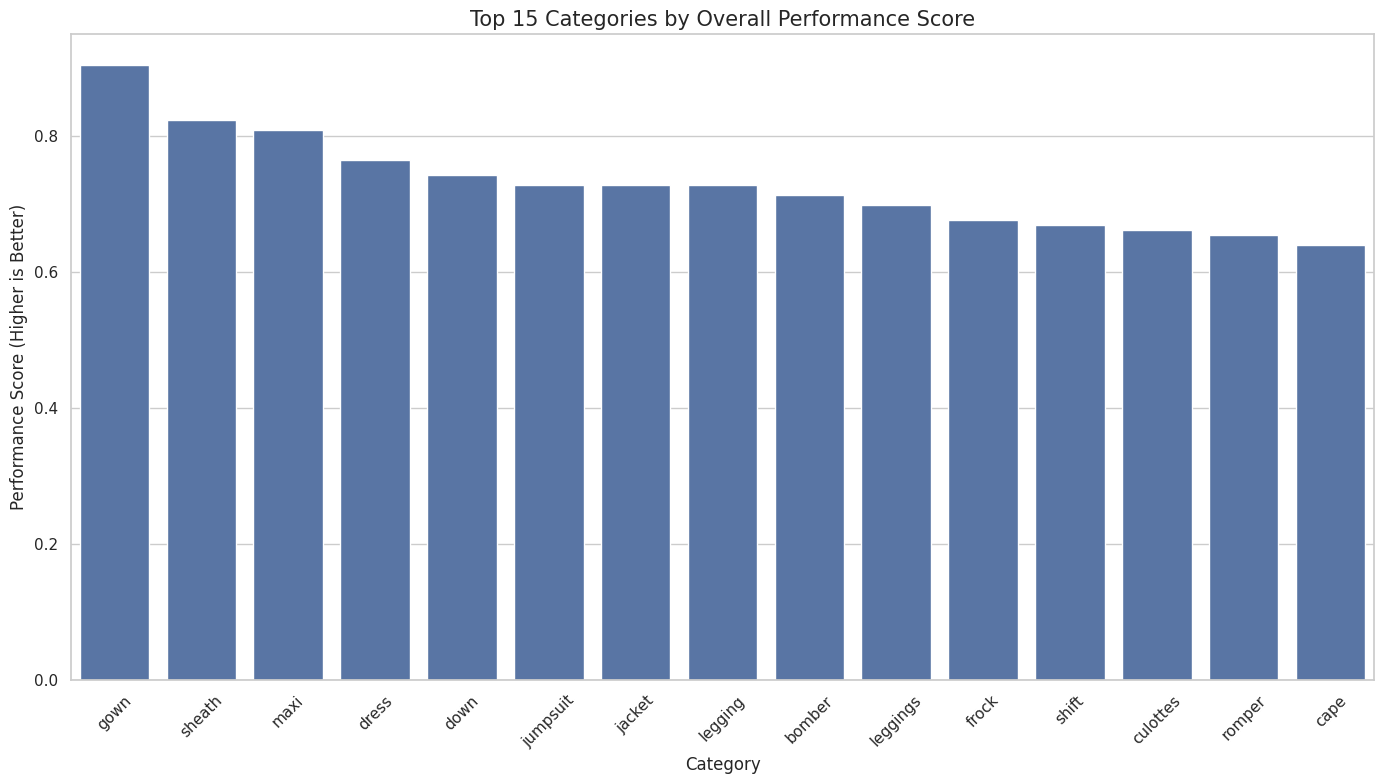

In [56]:
# Analyze relationship between product attributes and business metrics
category_metrics = df_mod.groupby('category').agg({
    'rating': 'mean',
    'item_id': 'count'
}).reset_index()
category_metrics.columns = ['category', 'avg_rating', 'rental_count']

# Calculate a composite performance score
category_metrics['rating_percentile'] = category_metrics['avg_rating'].rank(pct=True)
category_metrics['count_percentile'] = category_metrics['rental_count'].rank(pct=True)
category_metrics['performance_score'] = (category_metrics['rating_percentile'] + 
                                        category_metrics['count_percentile']) / 2

# Top performing categories
top_performers = category_metrics.sort_values('performance_score', ascending=False).head(15)
plt.figure(figsize=(14, 8))
sns.barplot(x='category', y='performance_score', data=top_performers)
plt.title('Top 15 Categories by Overall Performance Score', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Performance Score (Higher is Better)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Fit Feedback Distribution by Bust Size

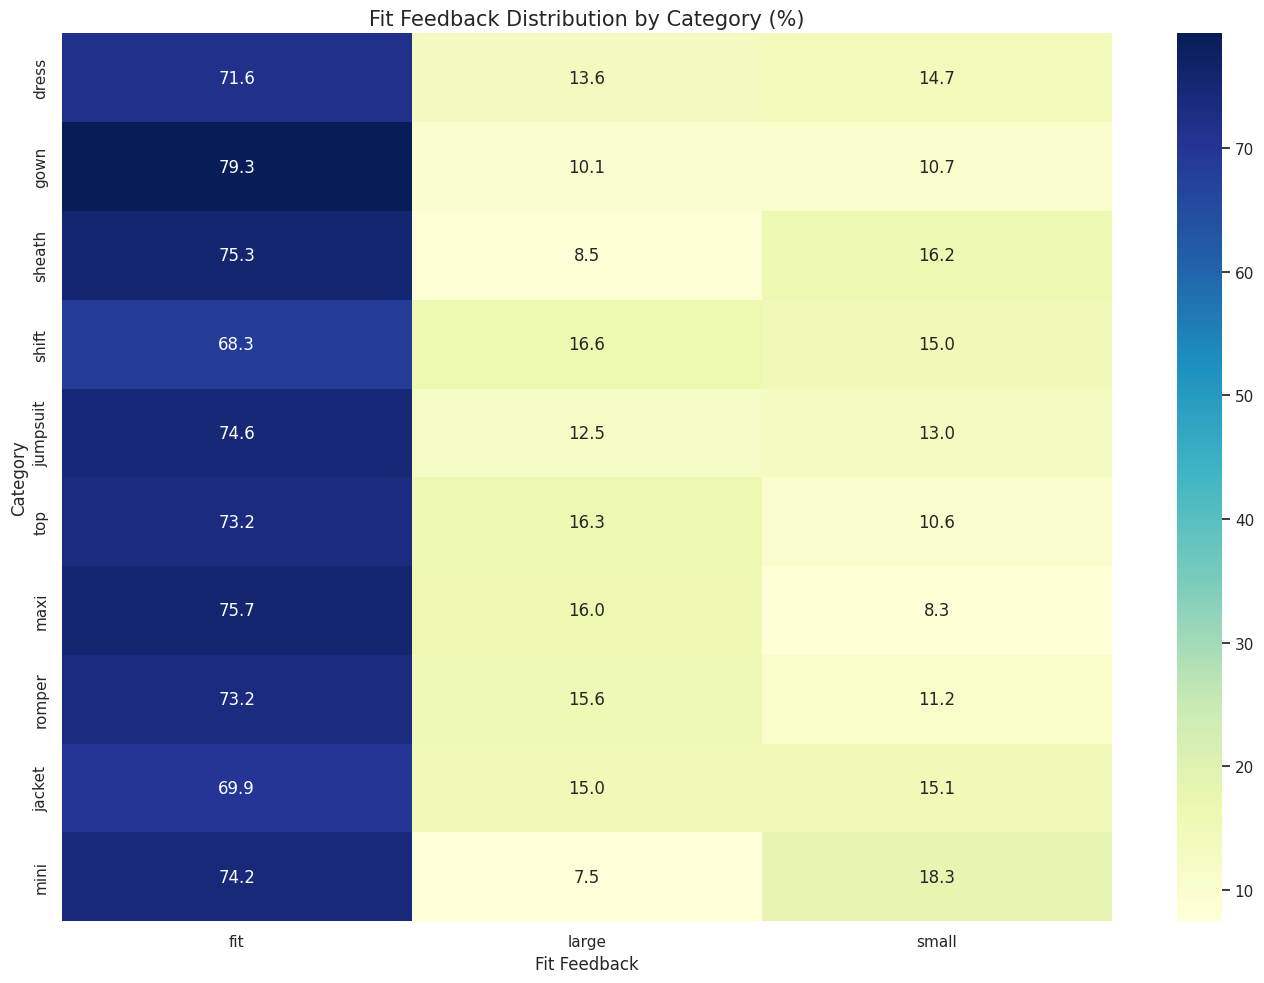

In [57]:
# Analyze fit feedback by category
category_fit = pd.crosstab(df_mod['category'], df_mod['fit'])
category_fit_pct = category_fit.div(category_fit.sum(axis=1), axis=0) * 100

top_categories = df_mod['category'].value_counts().head(10).index
filtered_fit = category_fit_pct.loc[top_categories]

# Create heatmap of fit feedback by category
plt.figure(figsize=(14, 10))
sns.heatmap(filtered_fit, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Fit Feedback Distribution by Category (%)', fontsize=15)
plt.xlabel('Fit Feedback', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze fit issues by measurements
# bust_fit = pd.crosstab(df_mod['bust_size'], df_mod['fit'])
# bust_fit_pct = bust_fit.div(bust_fit.sum(axis=1), axis=0) * 100

# plt.figure(figsize=(14, 10))
# sns.heatmap(bust_fit_pct, annot=True, fmt='.1f', cmap='YlGnBu')
# plt.title('Fit Feedback Distribution by Bust Size (%)')
# plt.xlabel('Fit Feedback')
# plt.ylabel('Bust Size', fontsize=12)
# plt.tight_layout()
# plt.show()


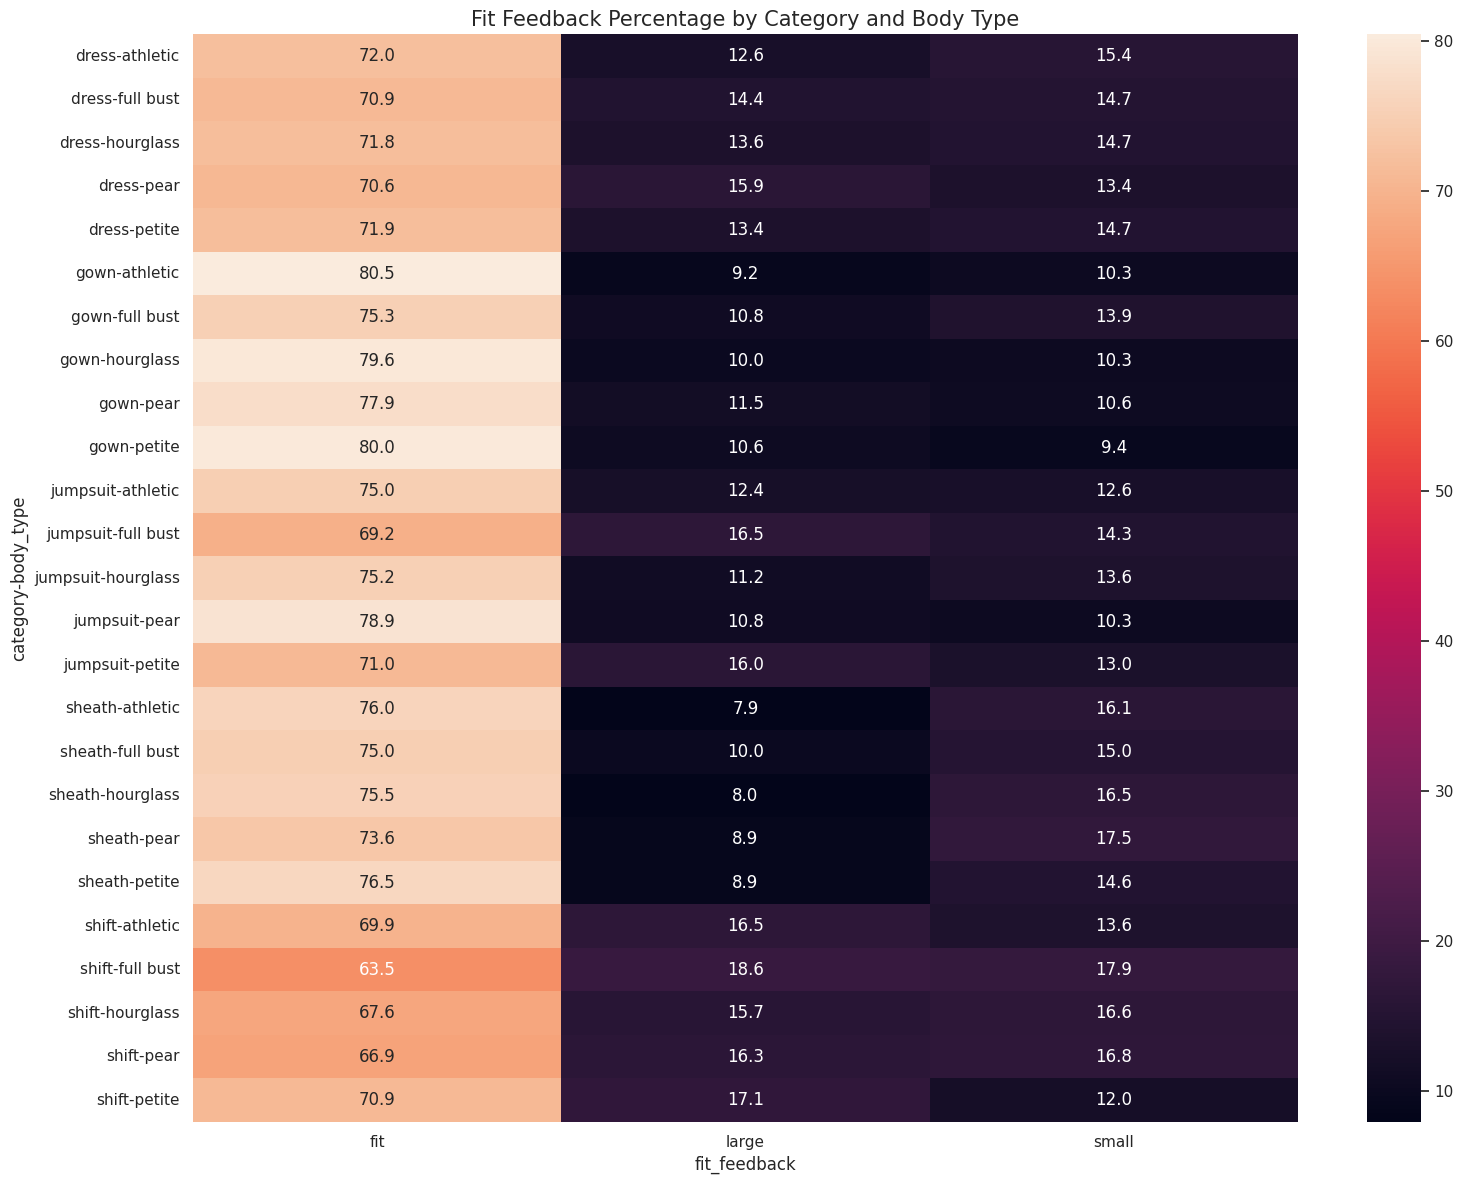

In [58]:
category_body_fit = pd.crosstab([df_mod['category'], df_mod['body_type']], df_mod['fit'])
category_body_fit_pct = category_body_fit.div(category_body_fit.sum(axis=1), axis=0) * 100

# Select top categories and body types 
top_categories = df_mod['category'].value_counts().head(5).index
top_body_types = df_mod['body_type'].value_counts().head(5).index

filtered_data = category_body_fit_pct.loc[
    (category_body_fit_pct.index.get_level_values('category').isin(top_categories)) &
    (category_body_fit_pct.index.get_level_values('body_type').isin(top_body_types))
]

# Reshape heatmap
filtered_data_reset = filtered_data.reset_index()
melted_data = pd.melt(filtered_data_reset, 
                      id_vars=['category', 'body_type'], 
                      value_vars=filtered_data.columns,
                      var_name='fit_feedback', 
                      value_name='percentage')

# Create heatmap 
heatmap_data = melted_data.pivot_table(
    index=['category', 'body_type'], 
    columns='fit_feedback', 
    values='percentage'
)

plt.figure(figsize=(16, 12))
sns.heatmap(heatmap_data, annot=True, fmt='.1f')
plt.title('Fit Feedback Percentage by Category and Body Type', fontsize=15)
plt.tight_layout()
plt.show()

## Fit Feedback Analysis

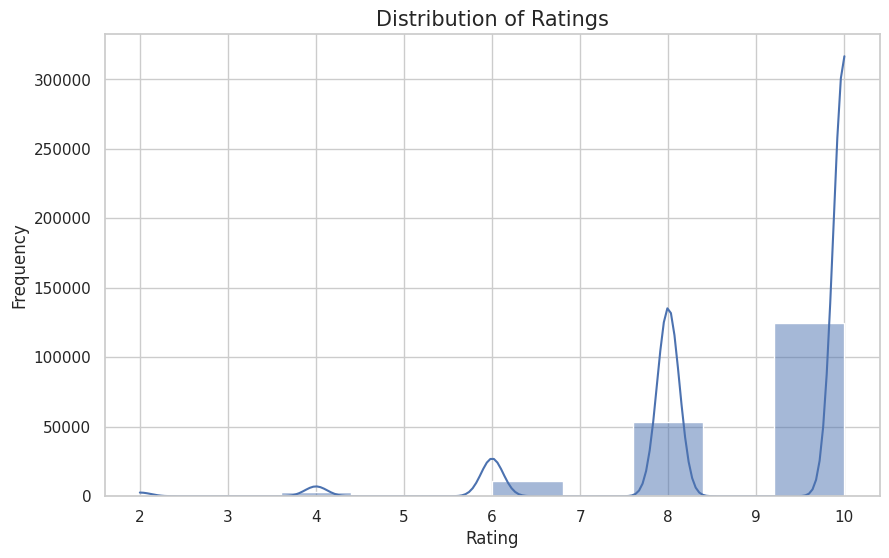

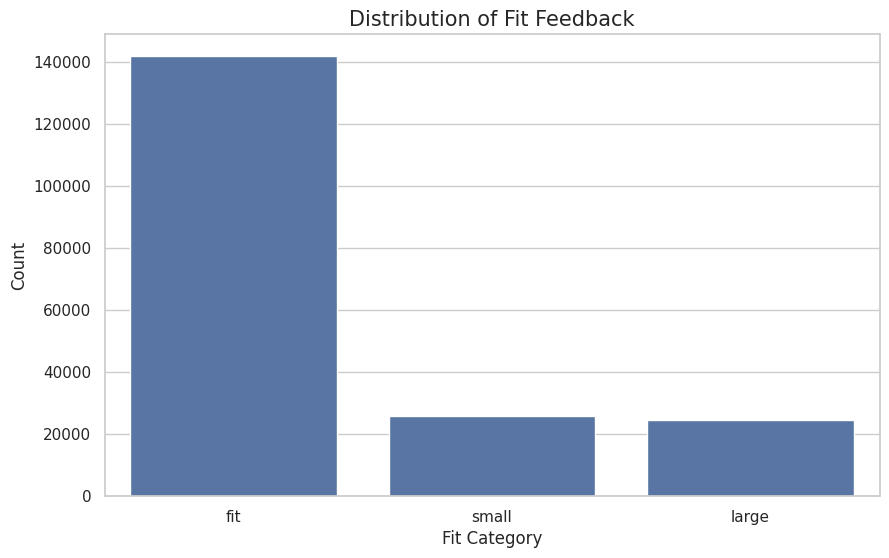

Fit feedback distribution (%):
fit: 73.77%
small: 13.39%
large: 12.84%


In [59]:
# Analyze rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_mod['rating'].dropna(), bins=10, kde=True)
plt.title('Distribution of Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Analyze fit feedback distribution
fit_counts = df_mod['fit'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=fit_counts.index, y=fit_counts.values)
plt.title('Distribution of Fit Feedback', fontsize=15)
plt.xlabel('Fit Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Calculate percentage distribution of fit feedback
fit_percentage = df_mod['fit'].value_counts(normalize=True) * 100
print("Fit feedback distribution (%):")
for category, percentage in fit_percentage.items():
    print(f"{category}: {percentage:.2f}%")


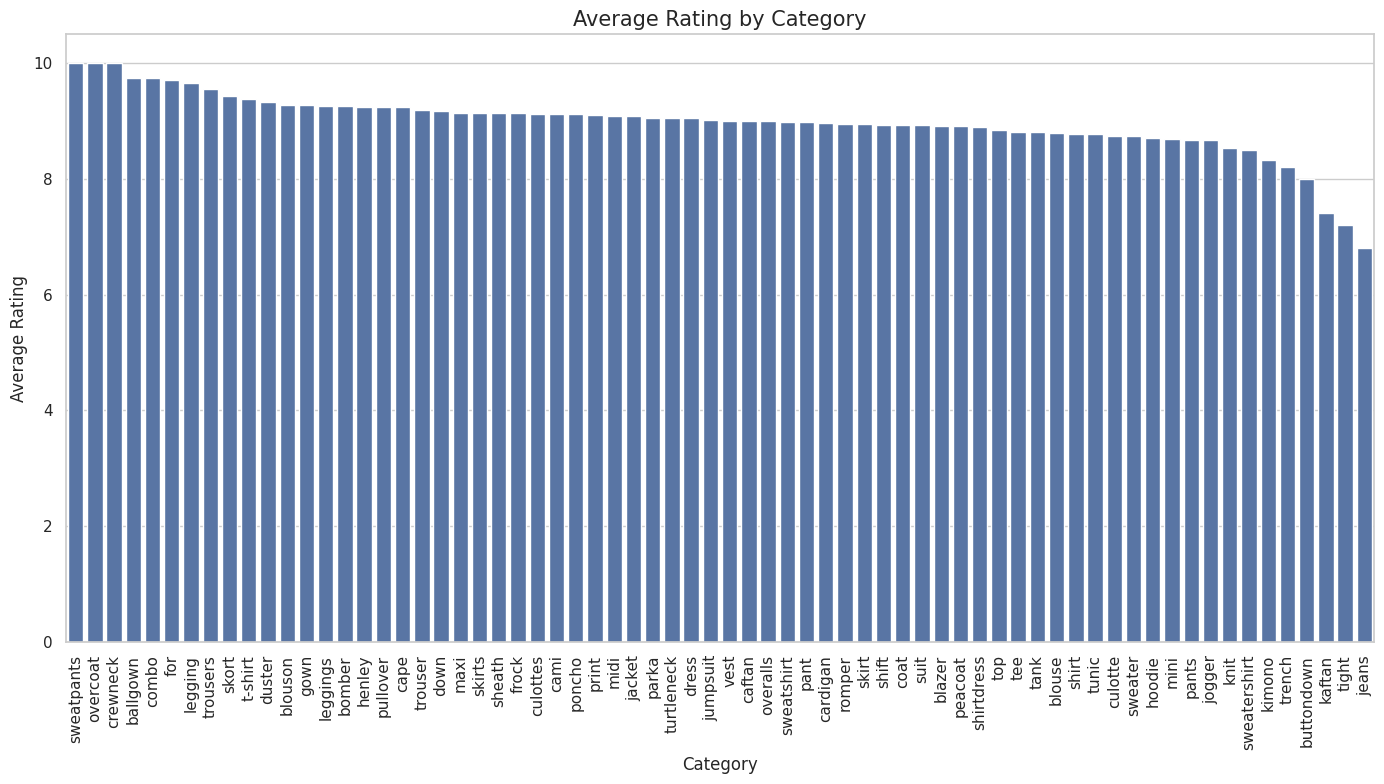

<Figure size 2000x800 with 0 Axes>

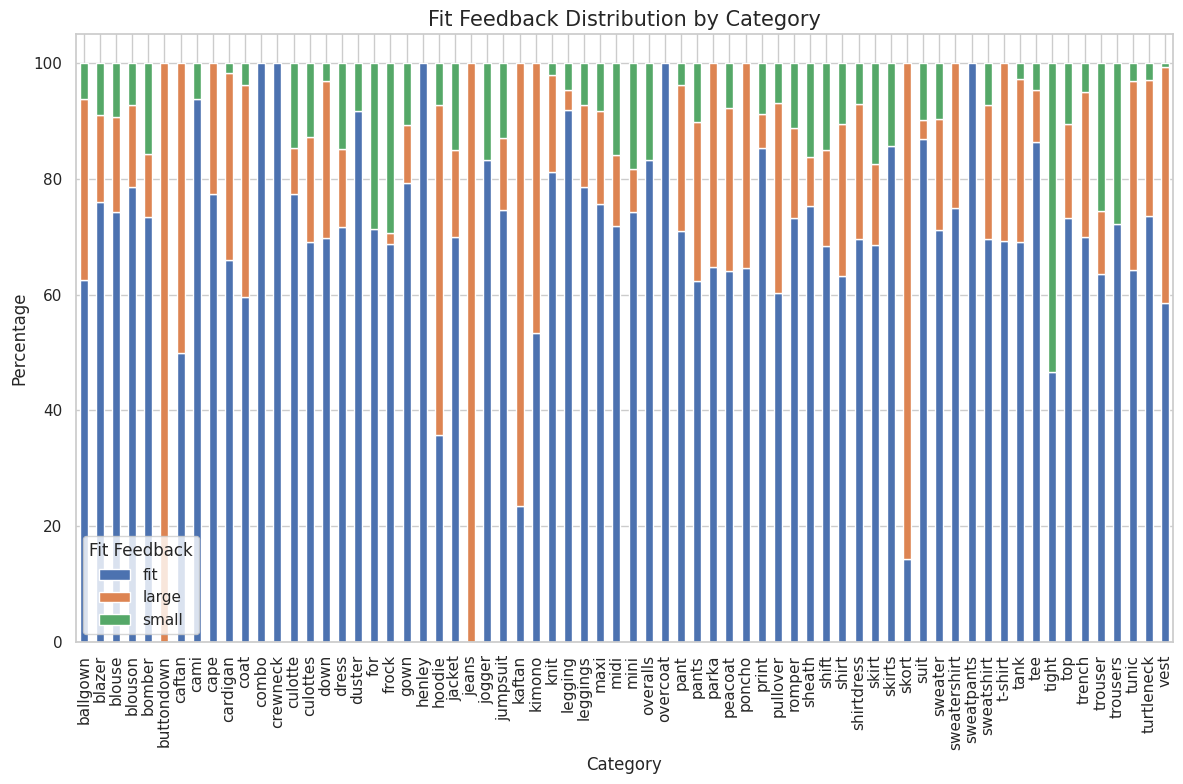

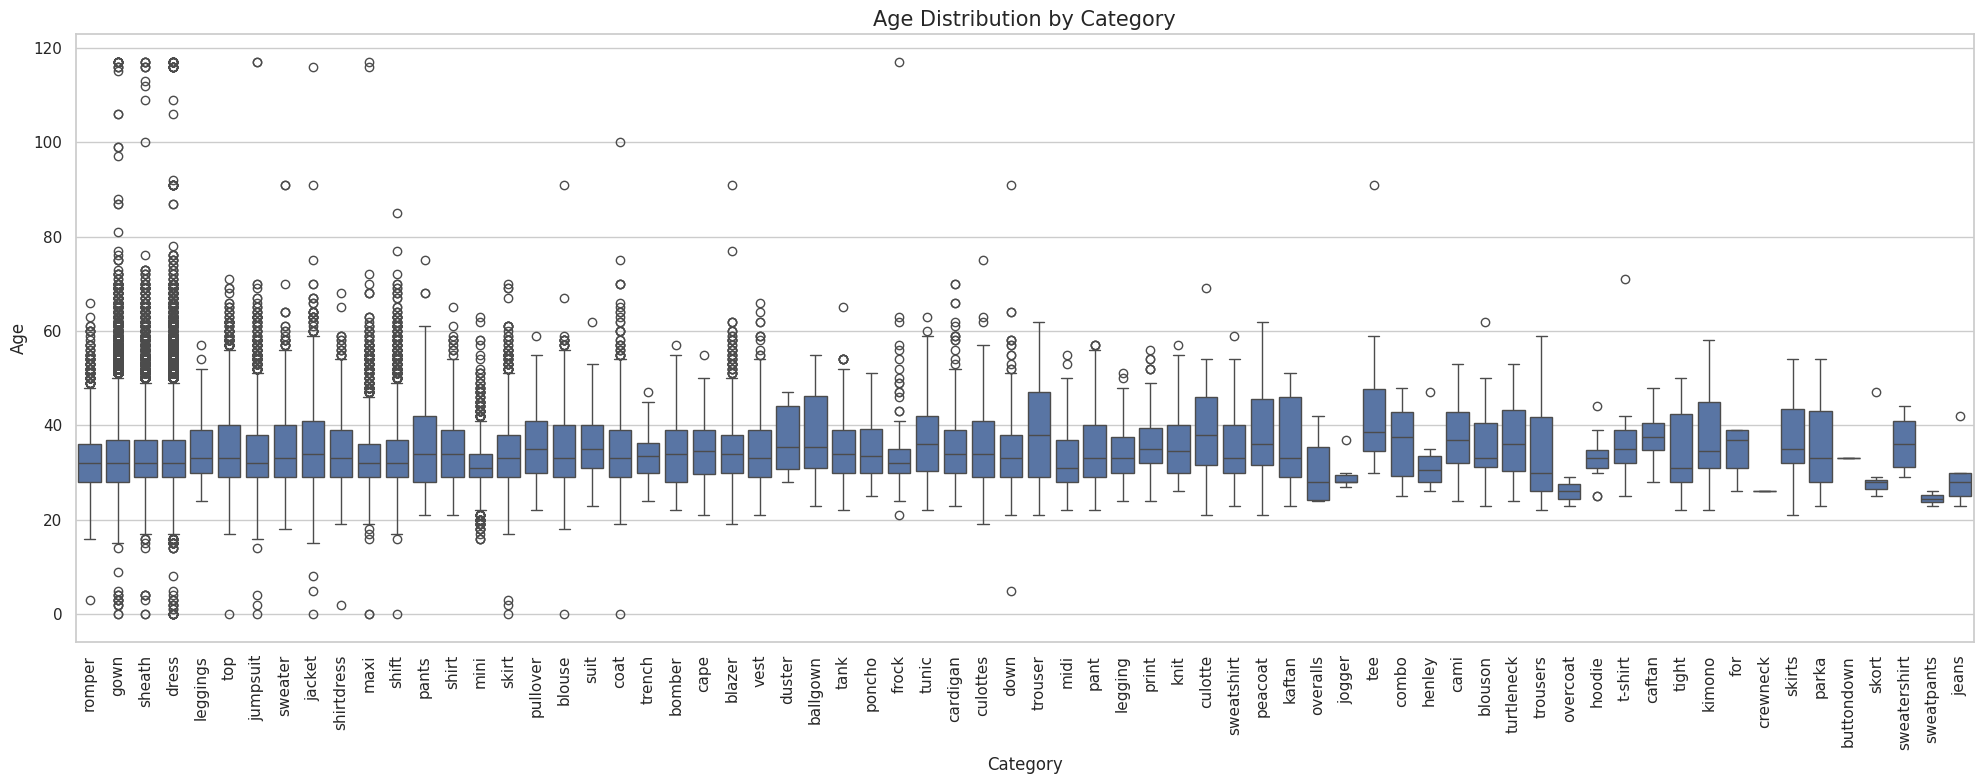

In [60]:
# Compare average ratings across categories
category_ratings = df_mod.groupby('category')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=category_ratings.index, y=category_ratings.values)
plt.title('Average Rating by Category', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Compare fit feedback distribution across categories
category_fit = pd.crosstab(df_mod['category'], df_mod['fit'])
category_fit_pct = category_fit.div(category_fit.sum(axis=1), axis=0) * 100

plt.figure(figsize=(20, 8))
category_fit_pct.plot(kind='bar', stacked=True)
plt.title('Fit Feedback Distribution by Category', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Fit Feedback')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Compare age distribution across categories
plt.figure(figsize=(20, 8))
sns.boxplot(x='category', y='age', data=df_mod)
plt.title('Age Distribution by Category', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

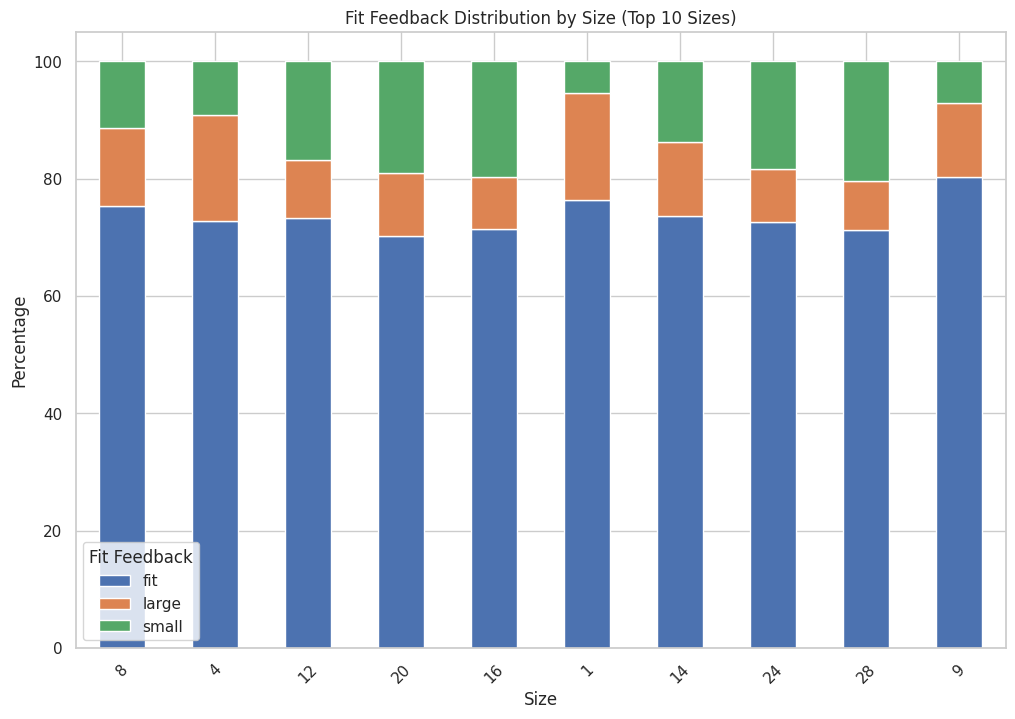

<Figure size 1400x800 with 0 Axes>

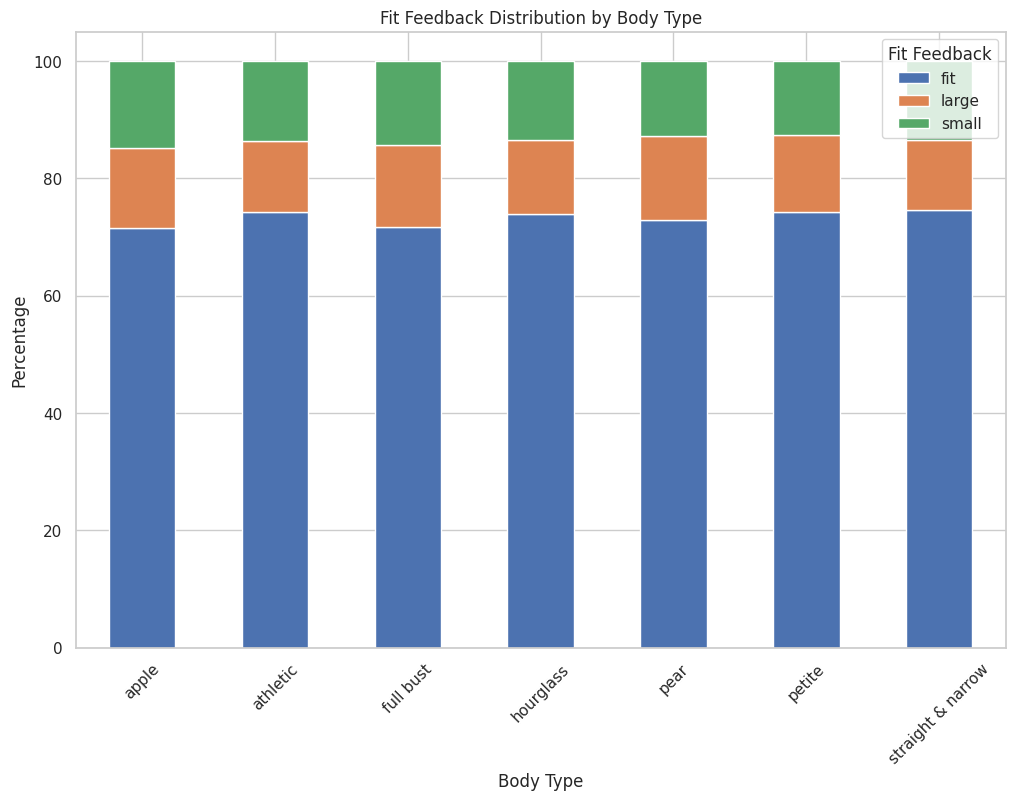

In [61]:
# Fit feedback analysis by size
# Fit feedback distribution by size
plt.figure(figsize=(14, 8))
fit_by_size = pd.crosstab(df_mod['size'], df_mod['fit'])
fit_by_size_pct = fit_by_size.div(fit_by_size.sum(axis=1), axis=0) * 100

# Select top sizes by frequency
top_sizes = df_mod['size'].value_counts().head(10).index
fit_by_size_pct_filtered = fit_by_size_pct.loc[top_sizes]

fit_by_size_pct_filtered.plot(kind='bar', stacked=True)
plt.title('Fit Feedback Distribution by Size (Top 10 Sizes)')
plt.xlabel('Size')
plt.ylabel('Percentage')
plt.legend(title='Fit Feedback')
plt.xticks(rotation=45)
plt.show()

# Fit feedback by body type
# Get top body types
top_body_types = df_mod['body_type'].value_counts().head(8).index
df_filtered = df_mod[df_mod['body_type'].isin(top_body_types)]

# Create crosstab and calculate percentages
fit_by_body = pd.crosstab(df_filtered['body_type'], df_filtered['fit'])
fit_by_body_pct = fit_by_body.div(fit_by_body.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
fit_by_body_pct.plot(kind='bar', stacked=True)
plt.title('Fit Feedback Distribution by Body Type')
plt.xlabel('Body Type')
plt.ylabel('Percentage')
plt.legend(title='Fit Feedback')
plt.xticks(rotation=45)
plt.show()


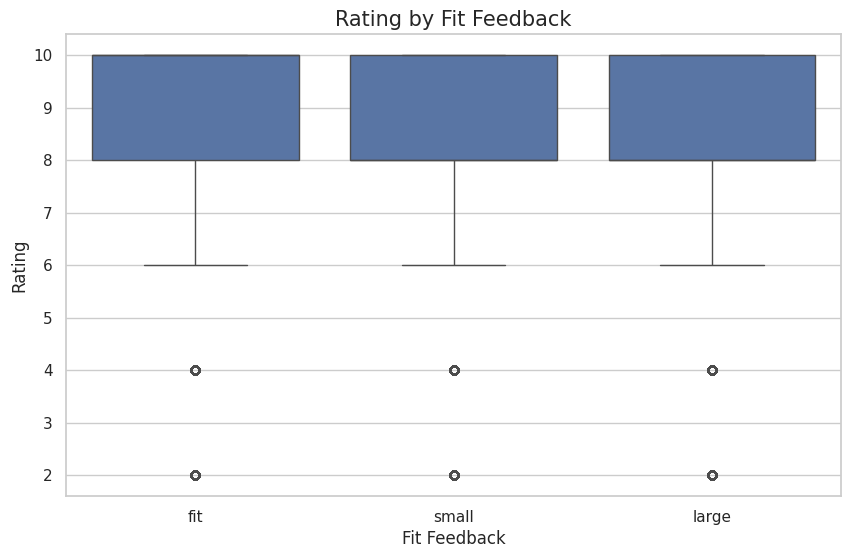


Average Rating by Fit Category:
fit: 9.31
large: 8.55
small: 8.42


In [62]:
# Rating by fit feedback
plt.figure(figsize=(10, 6))
sns.boxplot(x='fit', y='rating', data=df_mod)
plt.title('Rating by Fit Feedback', fontsize=15)
plt.xlabel('Fit Feedback', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

# Average rating by fit category
avg_rating_by_fit = df_mod.groupby('fit')['rating'].mean()
print("\nAverage Rating by Fit Category:")
for fit, avg_rating in avg_rating_by_fit.items():
    print(f"{fit}: {avg_rating:.2f}")

<Figure size 1400x800 with 0 Axes>

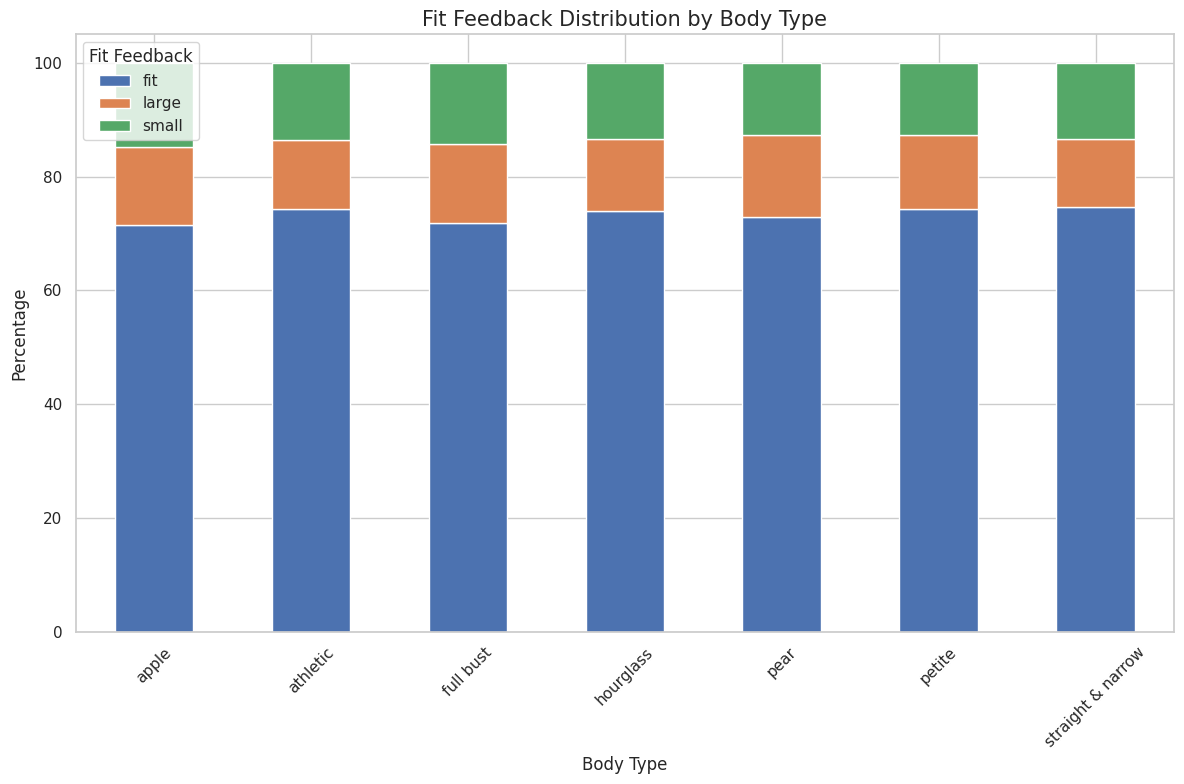

In [63]:
# # Rating by body type
# plt.figure(figsize=(14, 6))
# sns.boxplot(x='body_type', y='rating', data=df_mod)
# plt.title('Rating by Body Type', fontsize=15)
# plt.xlabel('Body Type', fontsize=12)
# plt.ylabel('Rating', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Fit feedback by body type
body_fit = pd.crosstab(df_mod['body_type'], df_mod['fit'])
body_fit_pct = body_fit.div(body_fit.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
body_fit_pct.plot(kind='bar', stacked=True)
plt.title('Fit Feedback Distribution by Body Type', fontsize=15)
plt.xlabel('Body Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Fit Feedback')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2121/3530716866.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2121/3530716866.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2121/3530716866.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2

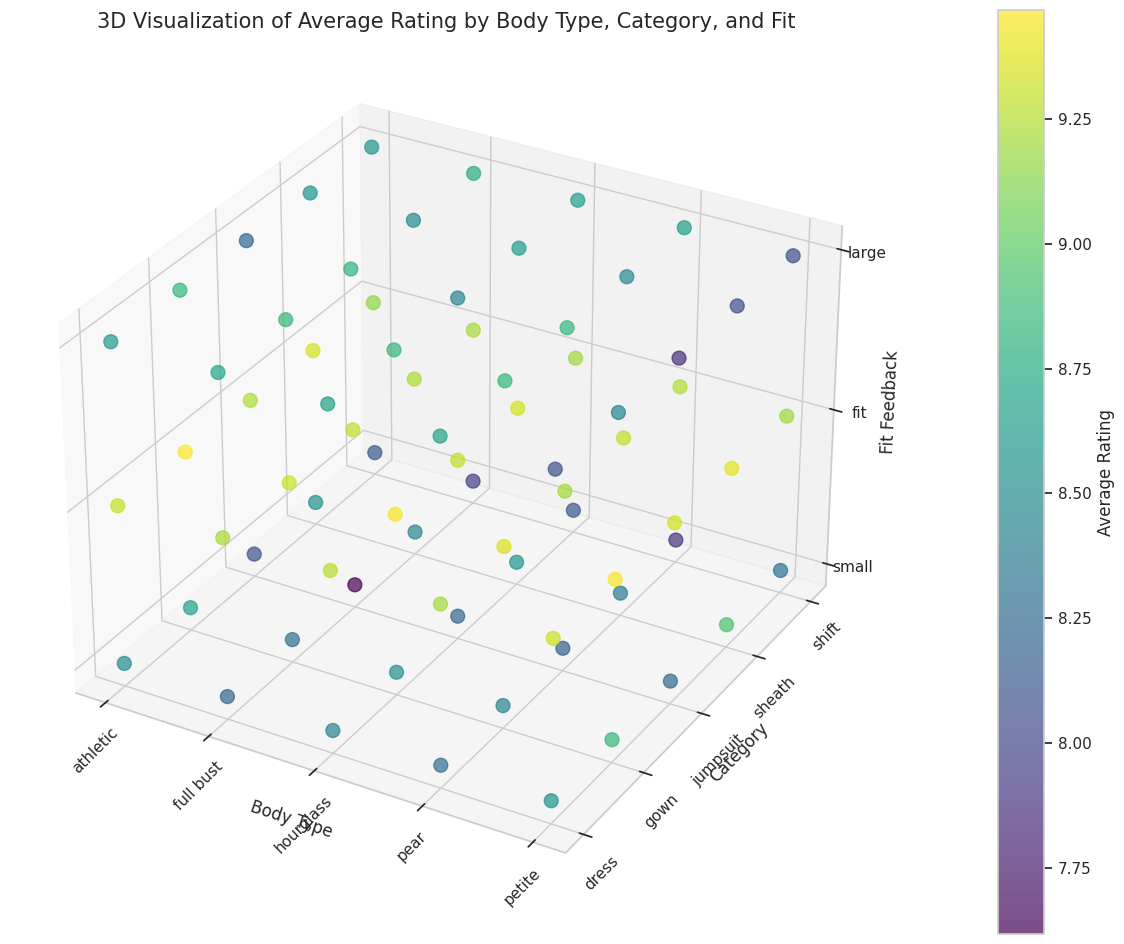

In [64]:
feedback_3d = df_mod.groupby(['body_type', 'category', 'fit'])['rating'].mean().reset_index()

# Filter to top body types and categories
top_body_types = df_mod['body_type'].value_counts().head(5).index
top_categories = df_mod['category'].value_counts().head(5).index
filtered_3d = feedback_3d[
    (feedback_3d['body_type'].isin(top_body_types)) & 
    (feedback_3d['category'].isin(top_categories))
]

# Create coding for categorical variables
body_type_code = {body: i for i, body in enumerate(filtered_3d['body_type'].unique())}
category_code = {cat: i for i, cat in enumerate(filtered_3d['category'].unique())}
fit_code = {'small': 0, 'fit': 1, 'large': 2}

filtered_3d['body_code'] = filtered_3d['body_type'].map(body_type_code)
filtered_3d['category_code'] = filtered_3d['category'].map(category_code)
filtered_3d['fit_code'] = filtered_3d['fit'].map(fit_code)

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot with color indicating rating
scatter = ax.scatter(
    filtered_3d['body_code'], 
    filtered_3d['category_code'], 
    filtered_3d['fit_code'],
    c=filtered_3d['rating'], 
    cmap='viridis', 
    s=100,
    alpha=0.7
)

ax.set_xlabel('Body Type')
ax.set_ylabel('Category')
ax.set_zlabel('Fit Feedback')
ax.set_xticks(list(body_type_code.values()))
ax.set_xticklabels(list(body_type_code.keys()), rotation=45)
ax.set_yticks(list(category_code.values()))
ax.set_yticklabels(list(category_code.keys()), rotation=45)
ax.set_zticks(list(fit_code.values()))
ax.set_zticklabels(list(fit_code.keys()))

cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Average Rating')

plt.title('3D Visualization of Average Rating by Body Type, Category, and Fit', fontsize=15)
plt.tight_layout()
plt.show()


## Time based Analysis

### Seasonal Trends of Top 5 Categories

<Figure size 1400x800 with 0 Axes>

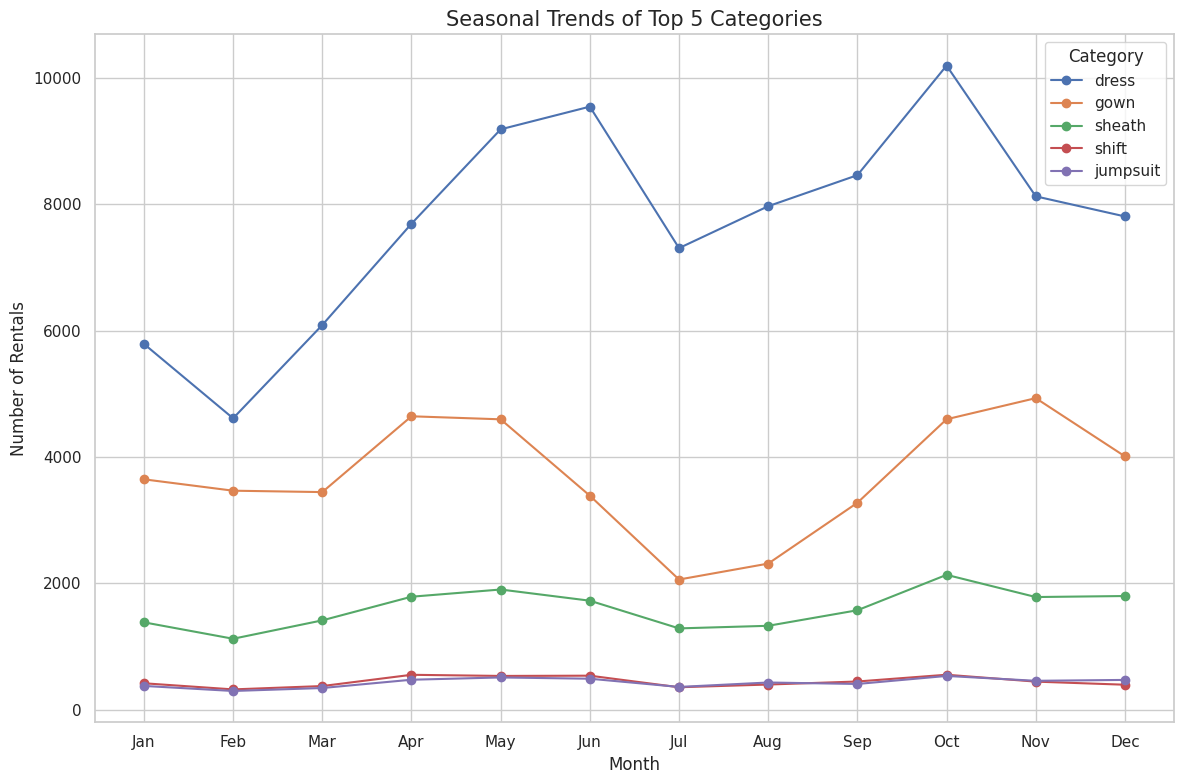

In [65]:
# Analyze seasonal trends 
df_mod['review_date'] = pd.to_datetime(df_mod['review_date'])
df_mod['month'] = df_mod['review_date'].dt.month

# Category popularity by month
category_month = pd.crosstab(df_mod['month'], df_mod['category'])

# Select top categories
top_categories = df_mod['category'].value_counts().head(5).index
category_month_filtered = category_month[top_categories]

# Category trends by month
plt.figure(figsize=(14, 8))
category_month_filtered.plot(kind='line', marker='o')
plt.title('Seasonal Trends of Top 5 Categories', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Rentals', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Category')
plt.tight_layout()
plt.show()
    
    


### Seasonal Trends of Top 5 Rental Occasions

<Figure size 1400x800 with 0 Axes>

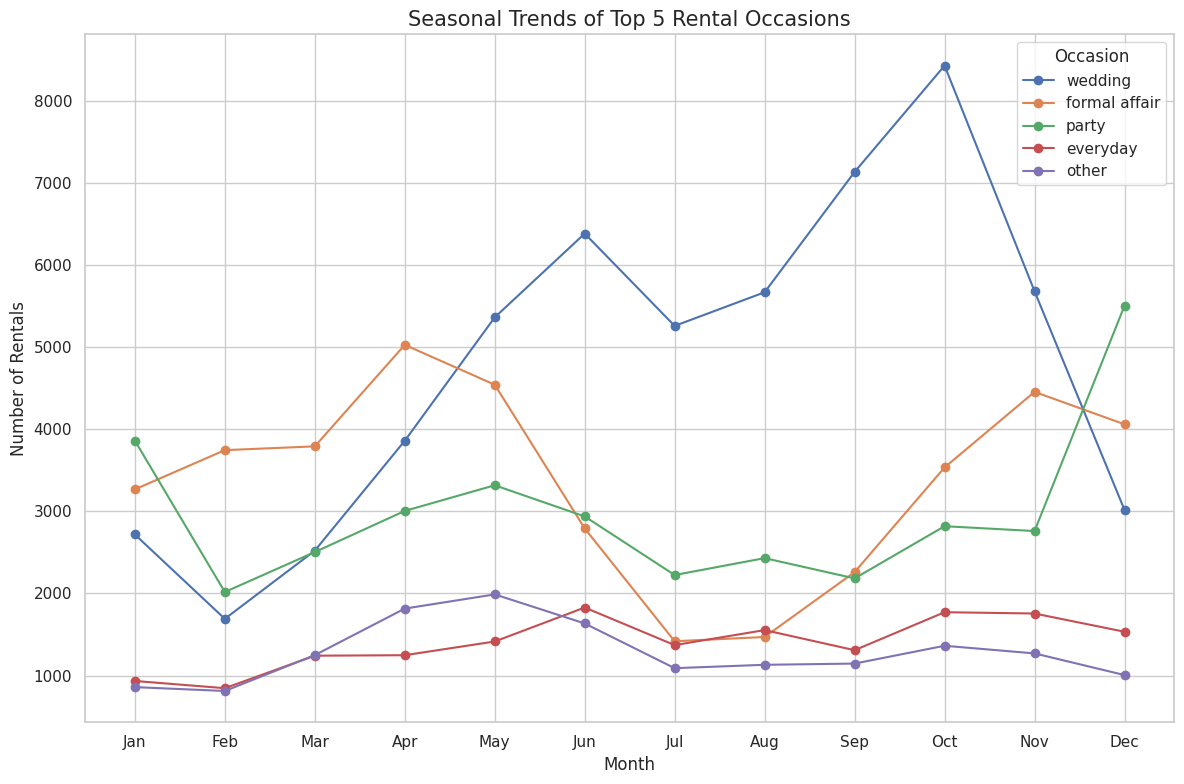

In [66]:
occasion_month = pd.crosstab(df_mod['month'], df_mod['rented_for'])

# Select top occasions
top_occasions = df_mod['rented_for'].value_counts().head(5).index
occasion_month_filtered = occasion_month[top_occasions]

# Occasion trends by month
plt.figure(figsize=(14, 8))
occasion_month_filtered.plot(kind='line', marker='o')
plt.title('Seasonal Trends of Top 5 Rental Occasions', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Rentals', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Occasion')
plt.tight_layout()
plt.show()

### Transactions over time

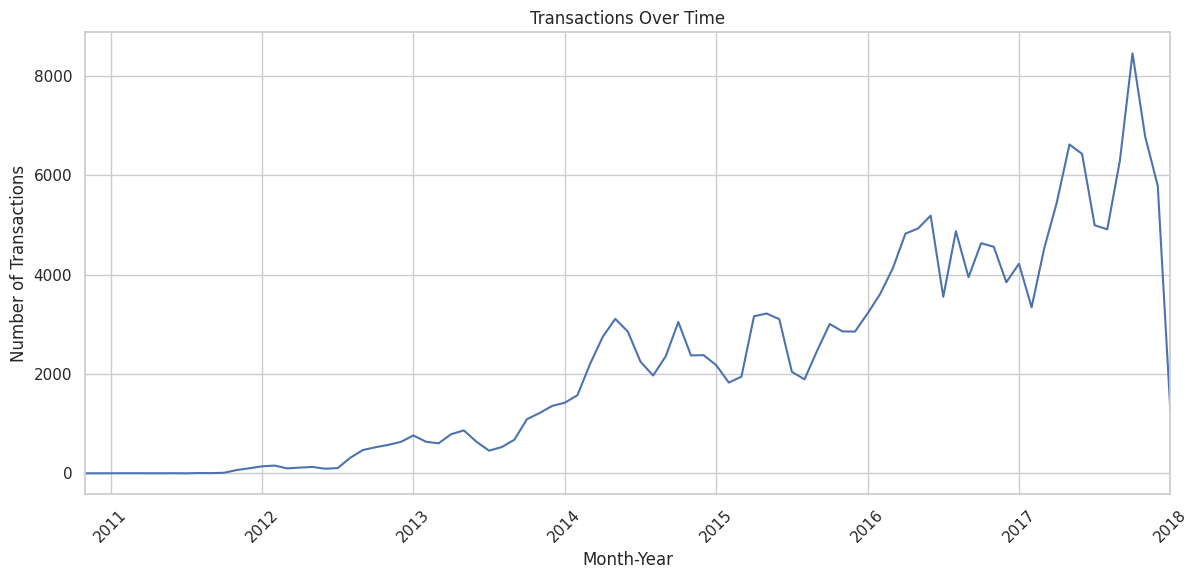

In [67]:
# Transactions over time
transactions_by_month = df_mod['month_year'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
transactions_by_month.plot(kind='line')
plt.title('Transactions Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

### Fit feedback Distribution over Time

<Figure size 1400x600 with 0 Axes>

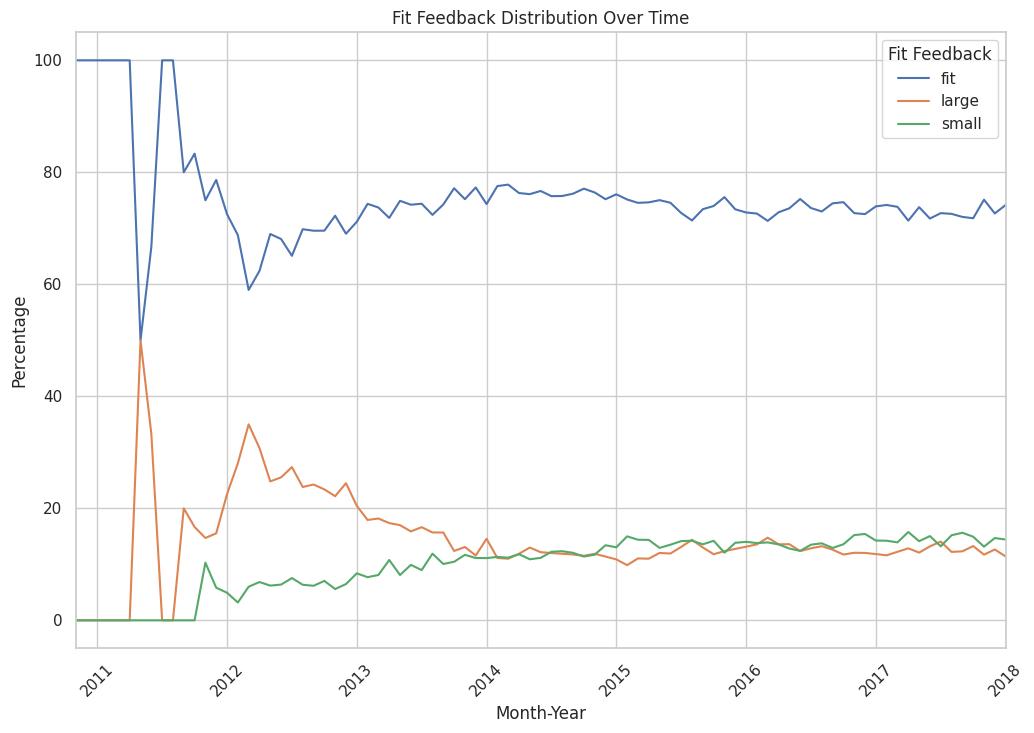

In [68]:
fit_by_month = pd.crosstab(df_mod['month_year'], df_mod['fit'])
fit_by_month_pct = fit_by_month.div(fit_by_month.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 6))
fit_by_month_pct.plot(kind='line')
plt.title('Fit Feedback Distribution Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Percentage')
plt.legend(title='Fit Feedback')
plt.xticks(rotation=45)
plt.show()


### Average Rating over the time

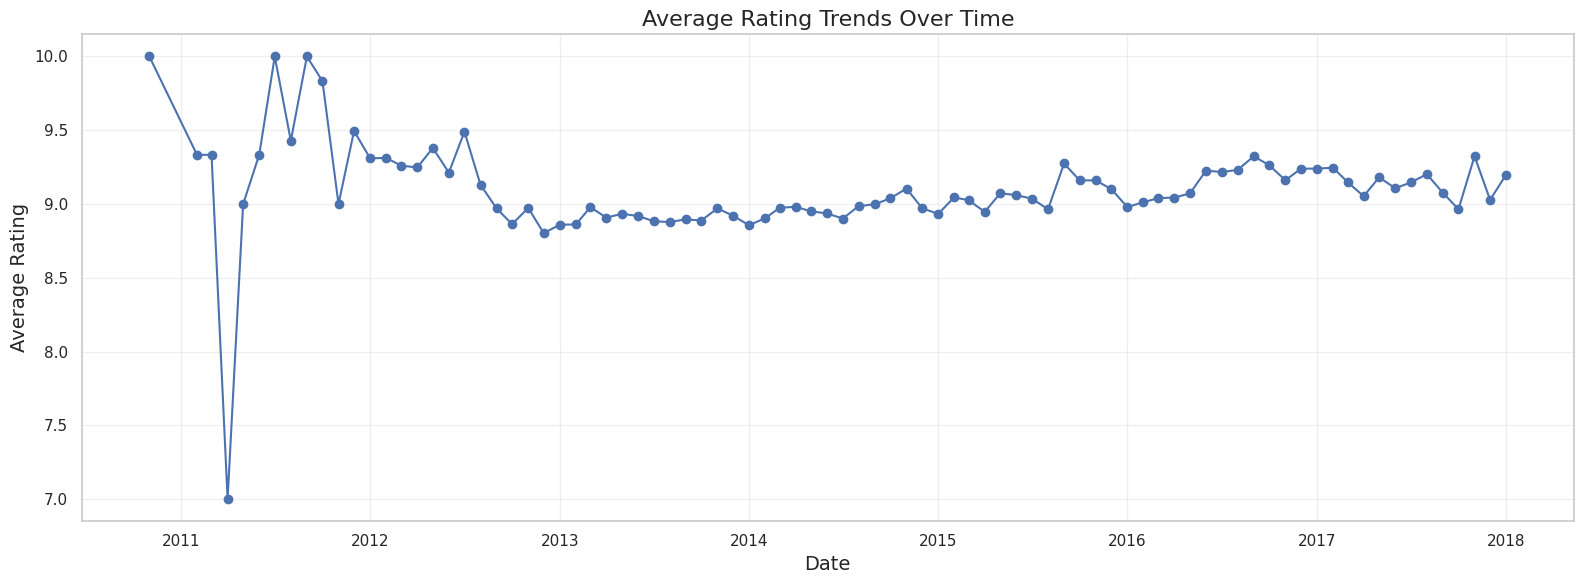

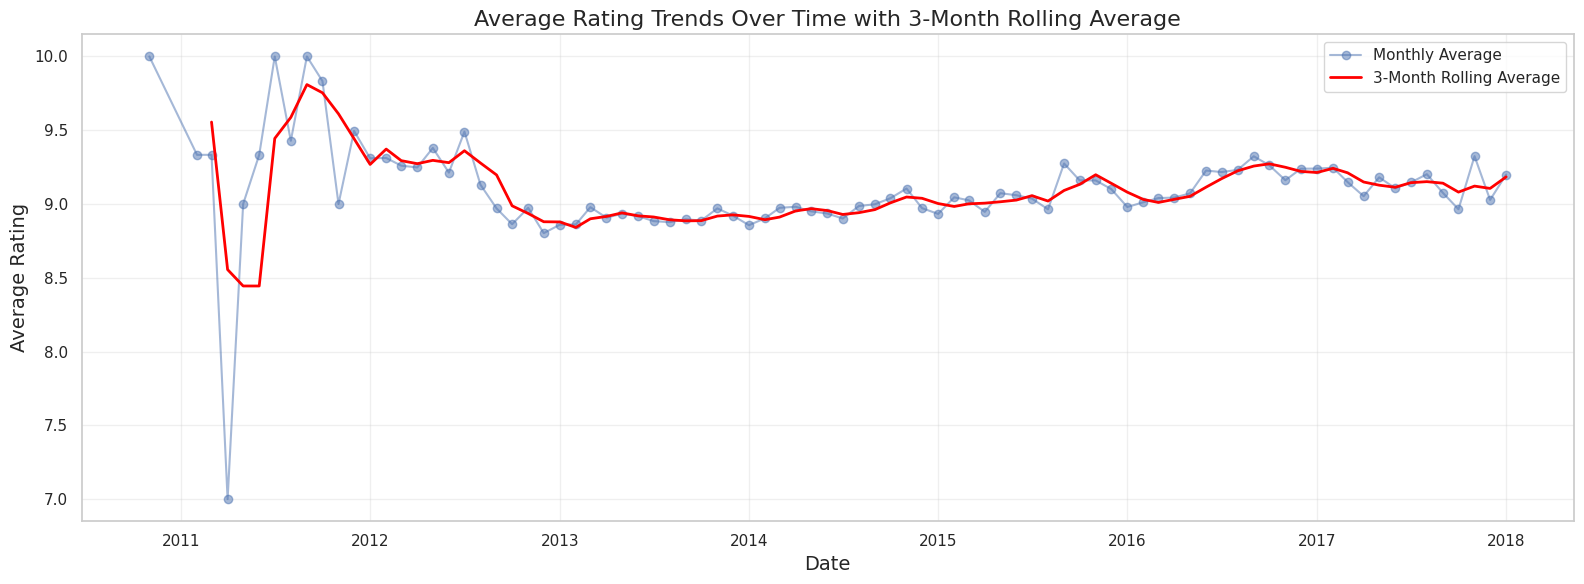

In [69]:
# Convert review_date to datetime
df_mod['year_month'] = df_mod['review_date'].dt.to_period('M')

# Calculate average rating by month
monthly_ratings = df_mod.groupby('year_month')['rating'].mean().reset_index()
monthly_ratings['year_month_dt'] = monthly_ratings['year_month'].dt.to_timestamp()

# Rating trends over time
plt.figure(figsize=(16, 6))
plt.plot(monthly_ratings['year_month_dt'], monthly_ratings['rating'], marker='o', linestyle='-')
plt.title('Average Rating Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Rolling average to smooth out fluctuations
plt.figure(figsize=(16, 6))
plt.plot(monthly_ratings['year_month_dt'], monthly_ratings['rating'], 
         alpha=0.5, marker='o', linestyle='-', label='Monthly Average')

# 3-month rolling average
rolling_avg = monthly_ratings['rating'].rolling(window=3).mean()
plt.plot(monthly_ratings['year_month_dt'], rolling_avg, 
         color='red', linewidth=2, label='3-Month Rolling Average')

plt.title('Average Rating Trends Over Time with 3-Month Rolling Average', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Average Rating over the years by Month

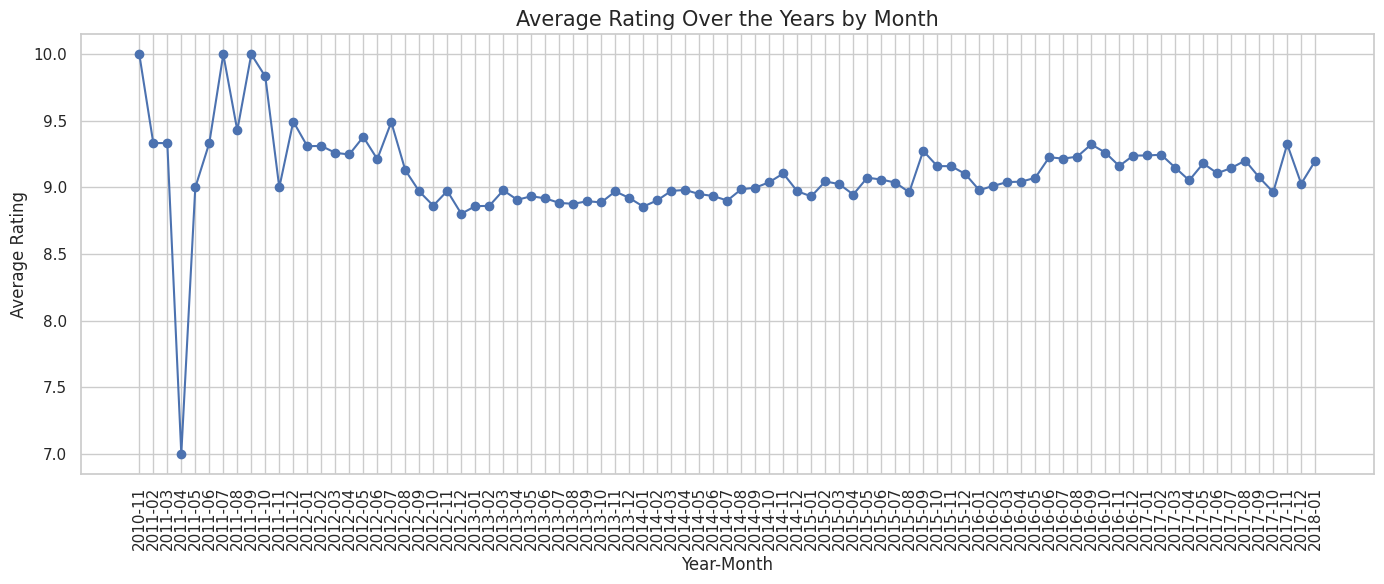

In [70]:
# Calculate average rating by month
monthly_ratings = df_mod.groupby('year_month')['rating'].mean().reset_index()

# Average ratings over the months
df_mod['year_month'] = df_mod['review_date'].dt.to_period('M')
plt.figure(figsize=(14, 6))
plt.plot(monthly_ratings['year_month'].astype(str), monthly_ratings['rating'], marker='o', linestyle='-')
plt.title('Average Rating Over the Years by Month', fontsize=15)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

### Fit Feedback by Body Type

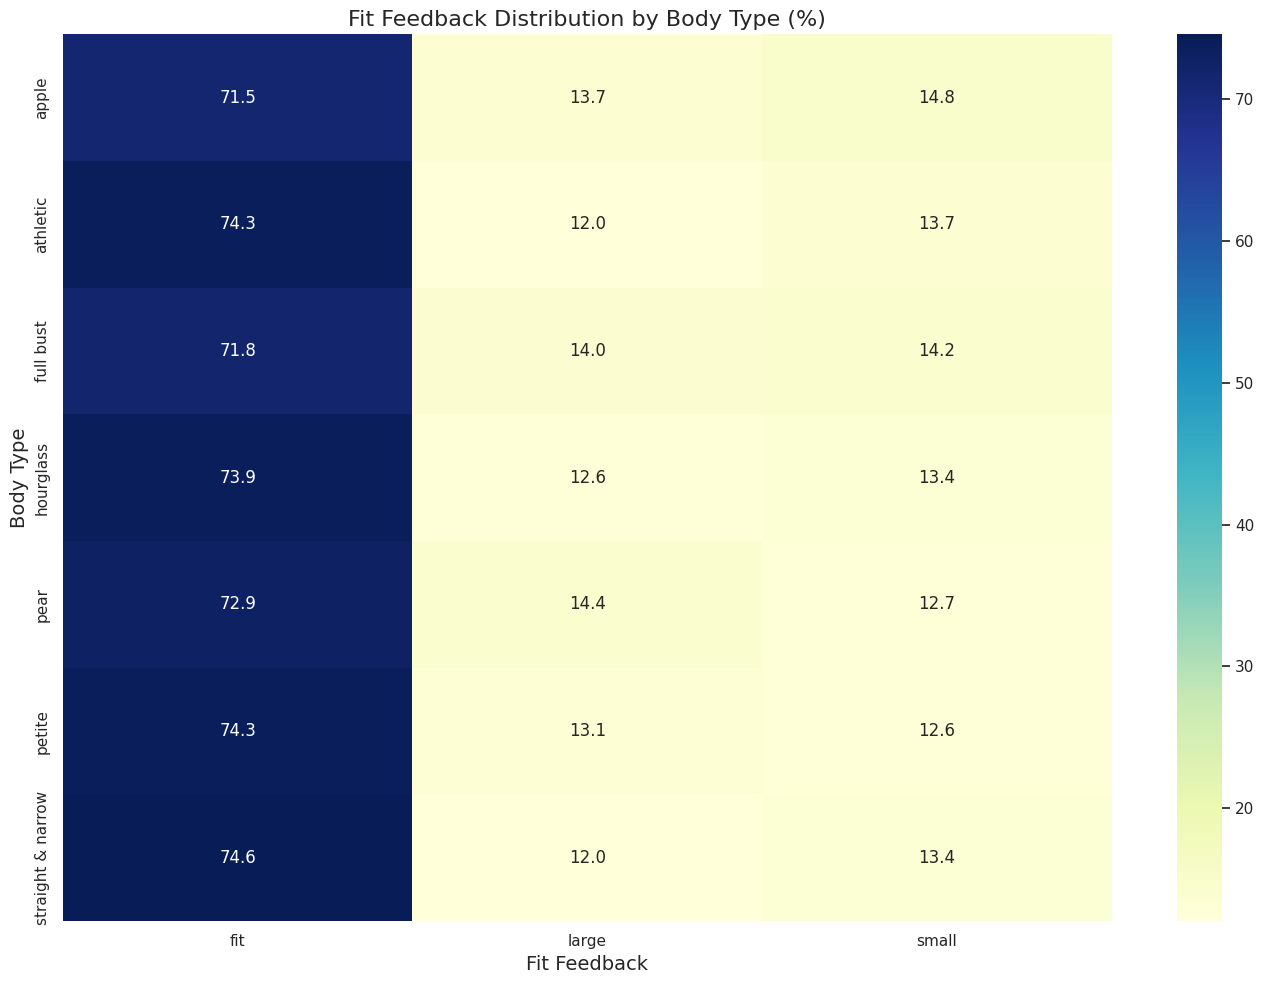

In [71]:
# Fit feedback by body type
body_fit = pd.crosstab(df_mod['body_type'], df_mod['fit'])
body_fit_pct = body_fit.div(body_fit.sum(axis=1), axis=0) * 100

# Heatmap of fit feedback by body type
plt.figure(figsize=(14, 10))
sns.heatmap(body_fit_pct, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Fit Feedback Distribution by Body Type (%)', fontsize=16)
plt.xlabel('Fit Feedback', fontsize=14)
plt.ylabel('Body Type', fontsize=14)
plt.tight_layout()
plt.show()


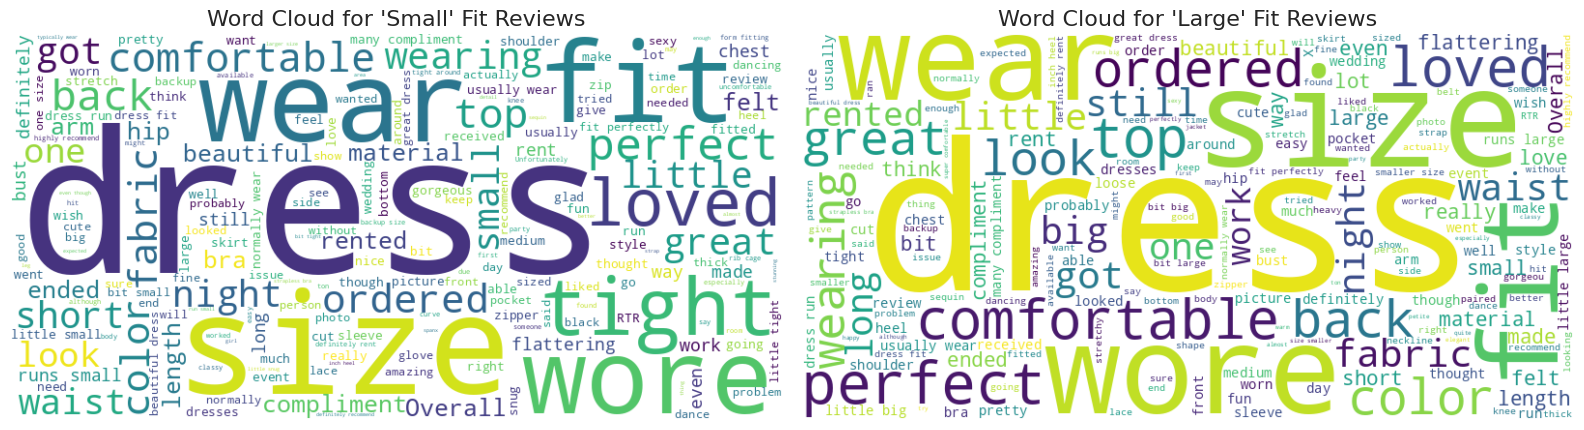

In [76]:
from wordcloud import WordCloud

# Generate word cloud for reviews mentioning "small"
small_reviews = ' '.join(df_mod[df_mod['fit'] == 'small']['review_text'].dropna())
wordcloud_small = WordCloud(width=800, height=400, background_color='white').generate(small_reviews)

# Generate word cloud for reviews mentioning "large"
large_reviews = ' '.join(df_mod[df_mod['fit'] == 'large']['review_text'].dropna())
wordcloud_large = WordCloud(width=800, height=400, background_color='white').generate(large_reviews)

# word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_small, interpolation='bilinear')
axes[0].set_title("Word Cloud for 'Small' Fit Reviews", fontsize=16)
axes[0].axis('off')

axes[1].imshow(wordcloud_large, interpolation='bilinear')
axes[1].set_title("Word Cloud for 'Large' Fit Reviews", fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()


## Review Text Analysis

### Distribution of Review Length and Sentiment Scores

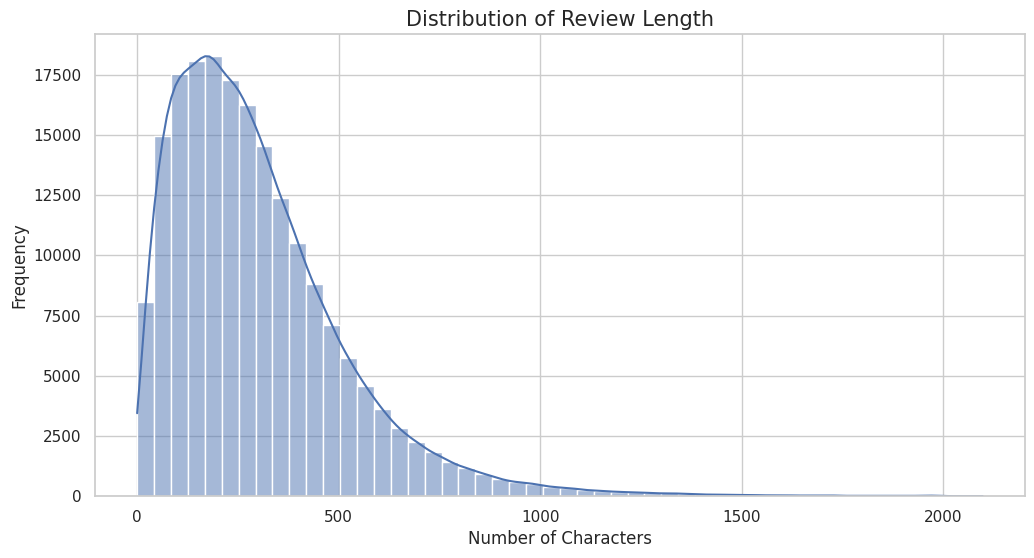

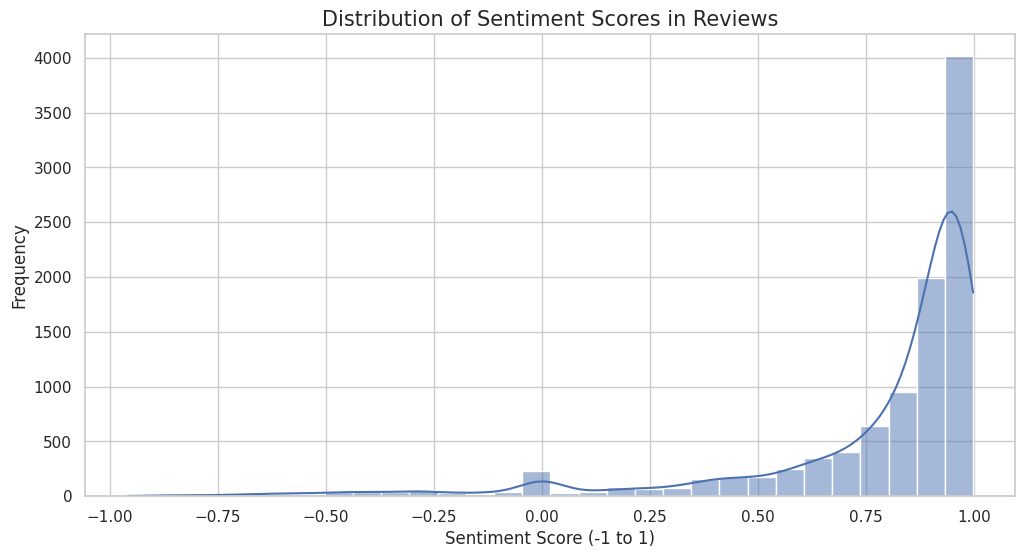

In [78]:
# Analyze review length distribution
df_mod['review_length'] = df_mod['review_text'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(df_mod['review_length'].dropna(), bins=50, kde=True)
plt.title('Distribution of Review Length', fontsize=15)
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# # Analyze review length by rating
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='rating', y='review_length', data=df_mod)
# plt.title('Review Length by Rating', fontsize=15)
# plt.xlabel('Rating', fontsize=12)
# plt.ylabel('Review Length (characters)', fontsize=12)
# plt.show()


# Sample a subset of reviews for sentiment analysis
sample_reviews = df_mod['review_text'].dropna().sample(10000, random_state=42)
sentiment_scores = sample_reviews.apply(lambda x: sia.polarity_scores(x)['compound'])

plt.figure(figsize=(12, 6))
sns.histplot(sentiment_scores, bins=30, kde=True)
plt.title('Distribution of Sentiment Scores in Reviews', fontsize=15)
plt.xlabel('Sentiment Score (-1 to 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


/tmp/ipykernel_2121/101205690.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




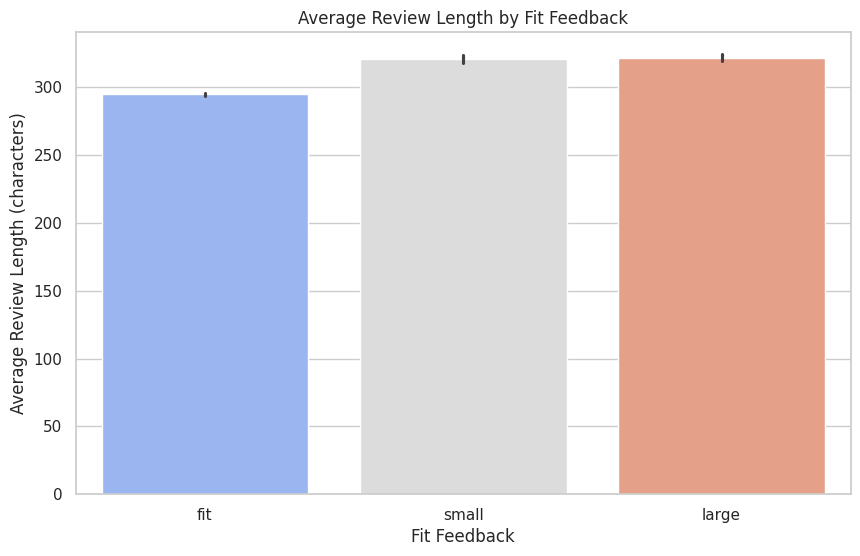

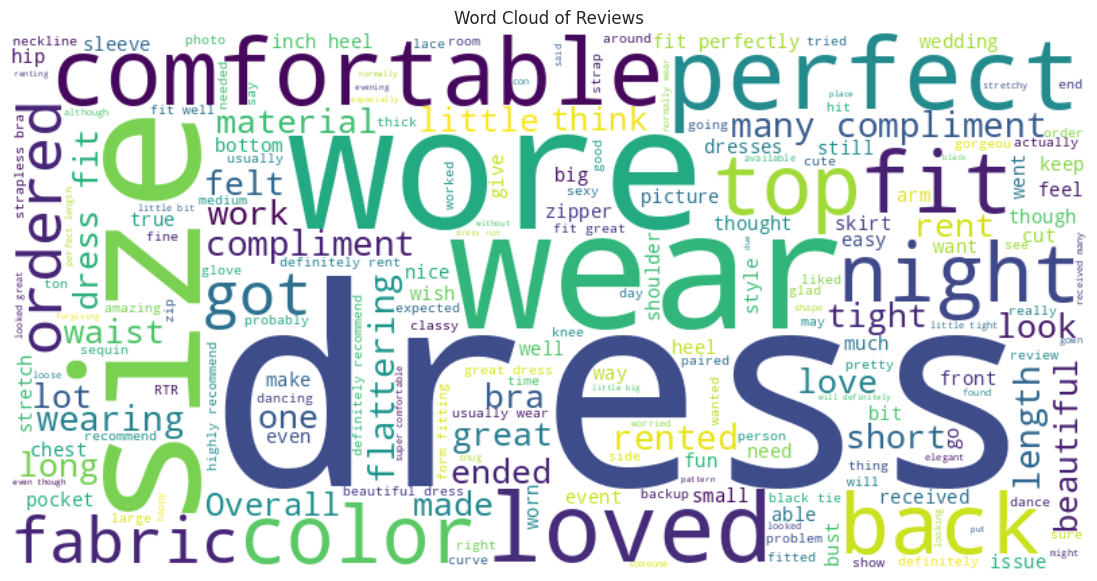

In [79]:
plt.figure(figsize=(10, 6))

# Mean Review length per fit category
sns.barplot(x='fit', y='review_length', data=df_mod, estimator=lambda x: x.mean(), palette="coolwarm")

plt.title('Average Review Length by Fit Feedback')
plt.xlabel('Fit Feedback')
plt.ylabel('Average Review Length (characters)')
plt.show()


try:
    from wordcloud import WordCloud
    
    # Combine all reviews into a single text
    all_reviews = ' '.join(df_mod['review_text'].dropna())
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_reviews)
    
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Reviews')
    plt.show()
except ImportError:
    print("WordCloud package not available. Install with: pip install wordcloud")


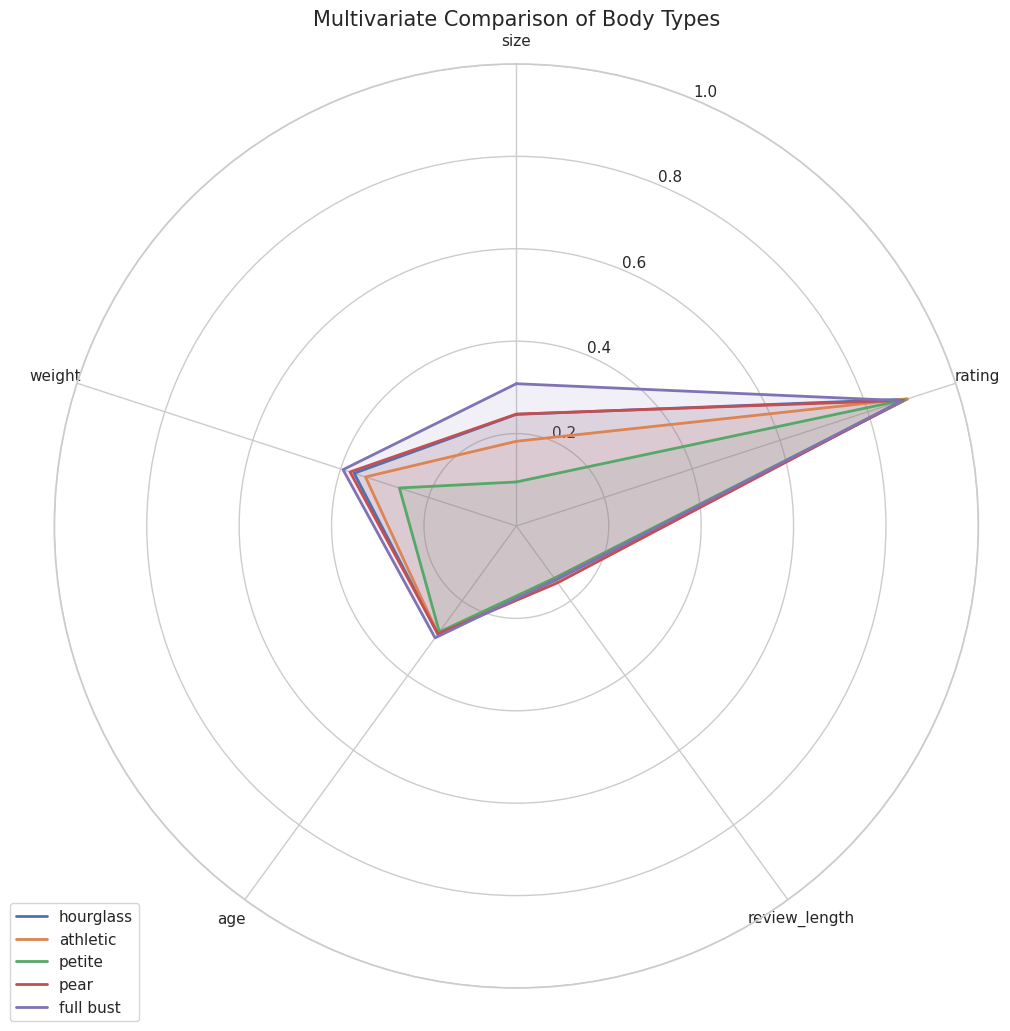

In [80]:
# Get top body types
top_body_types = df_mod['body_type'].value_counts().head(5).index.tolist()

radar_vars = ['size', 'rating', 'review_length', 'age', 'weight']
radar_vars = [var for var in radar_vars if var in df_mod.columns]

if len(radar_vars) > 2:
    # Calculate mean for each body type and variable
    means = {}
    for body_type in top_body_types:
        body_type_data = df_mod[df_mod['body_type'] == body_type]
        means[body_type] = [body_type_data[var].mean() for var in radar_vars]
    
    # Normalize data for radar chart
    normalized_means = {}
    for body_type, values in means.items():
        normalized_means[body_type] = []
        for i, var in enumerate(radar_vars):
            min_val = df_mod[var].min()
            max_val = df_mod[var].max()
            normalized_means[body_type].append((values[i] - min_val) / (max_val - min_val))
    
    # Radar chart
    angles = np.linspace(0, 2*np.pi, len(radar_vars), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
    
    for body_type, values in normalized_means.items():
        values += values[:1]  # Close the loop
        ax.plot(angles, values, linewidth=2, label=body_type)
        ax.fill(angles, values, alpha=0.1)
  
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), radar_vars)
    ax.set_ylim(0, 1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Multivariate Comparison of Body Types', fontsize=15)
    plt.show()


In [81]:
# # Analyze review length distribution
# df_mod['review_length'] = df_mod['review_text'].str.len()
# plt.figure(figsize=(12, 6))
# sns.histplot(df_mod['review_length'].dropna(), bins=50, kde=True)
# plt.title('Distribution of Review Length', fontsize=15)
# plt.xlabel('Number of Characters', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.show()

# # Analyze review length by rating
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='rating', y='review_length', data=df_mod)
# plt.title('Review Length by Rating', fontsize=15)
# plt.xlabel('Rating', fontsize=12)
# plt.ylabel('Review Length (characters)', fontsize=12)
# plt.show()

# sia = SentimentIntensityAnalyzer()

# sample_reviews = df_mod['review_text'].dropna().sample(1000, random_state=42)
# sentiment_scores = sample_reviews.apply(lambda x: sia.polarity_scores(x)['compound'])

# plt.figure(figsize=(12, 6))
# sns.histplot(sentiment_scores, bins=30, kde=True)
# plt.title('Distribution of Sentiment Scores in Reviews', fontsize=15)
# plt.xlabel('Sentiment Score (-1 to 1)', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.show()

## Revenue Optimization

In [82]:
# Group orders by user and month_year
order_categories = df_mod.groupby(['user_id', 'month_year'])['category'].apply(lambda x: list(set(x))).reset_index()
# Get list of unique categories
all_categories = df_mod['category'].dropna().unique()

cooccurrence = pd.DataFrame(0, index=all_categories, columns=all_categories, dtype=int)

In [83]:
for _, row in order_categories.iterrows():
    cats = row['category']
    for i in range(len(cats)):
        for j in range(i, len(cats)):
            cat1 = cats[i]
            cat2 = cats[j]
            if cat1 == cat2:
                cooccurrence.loc[cat1, cat1] += 1
            else:
                cooccurrence.loc[cat1, cat2] += 1
                cooccurrence.loc[cat2, cat1] += 1


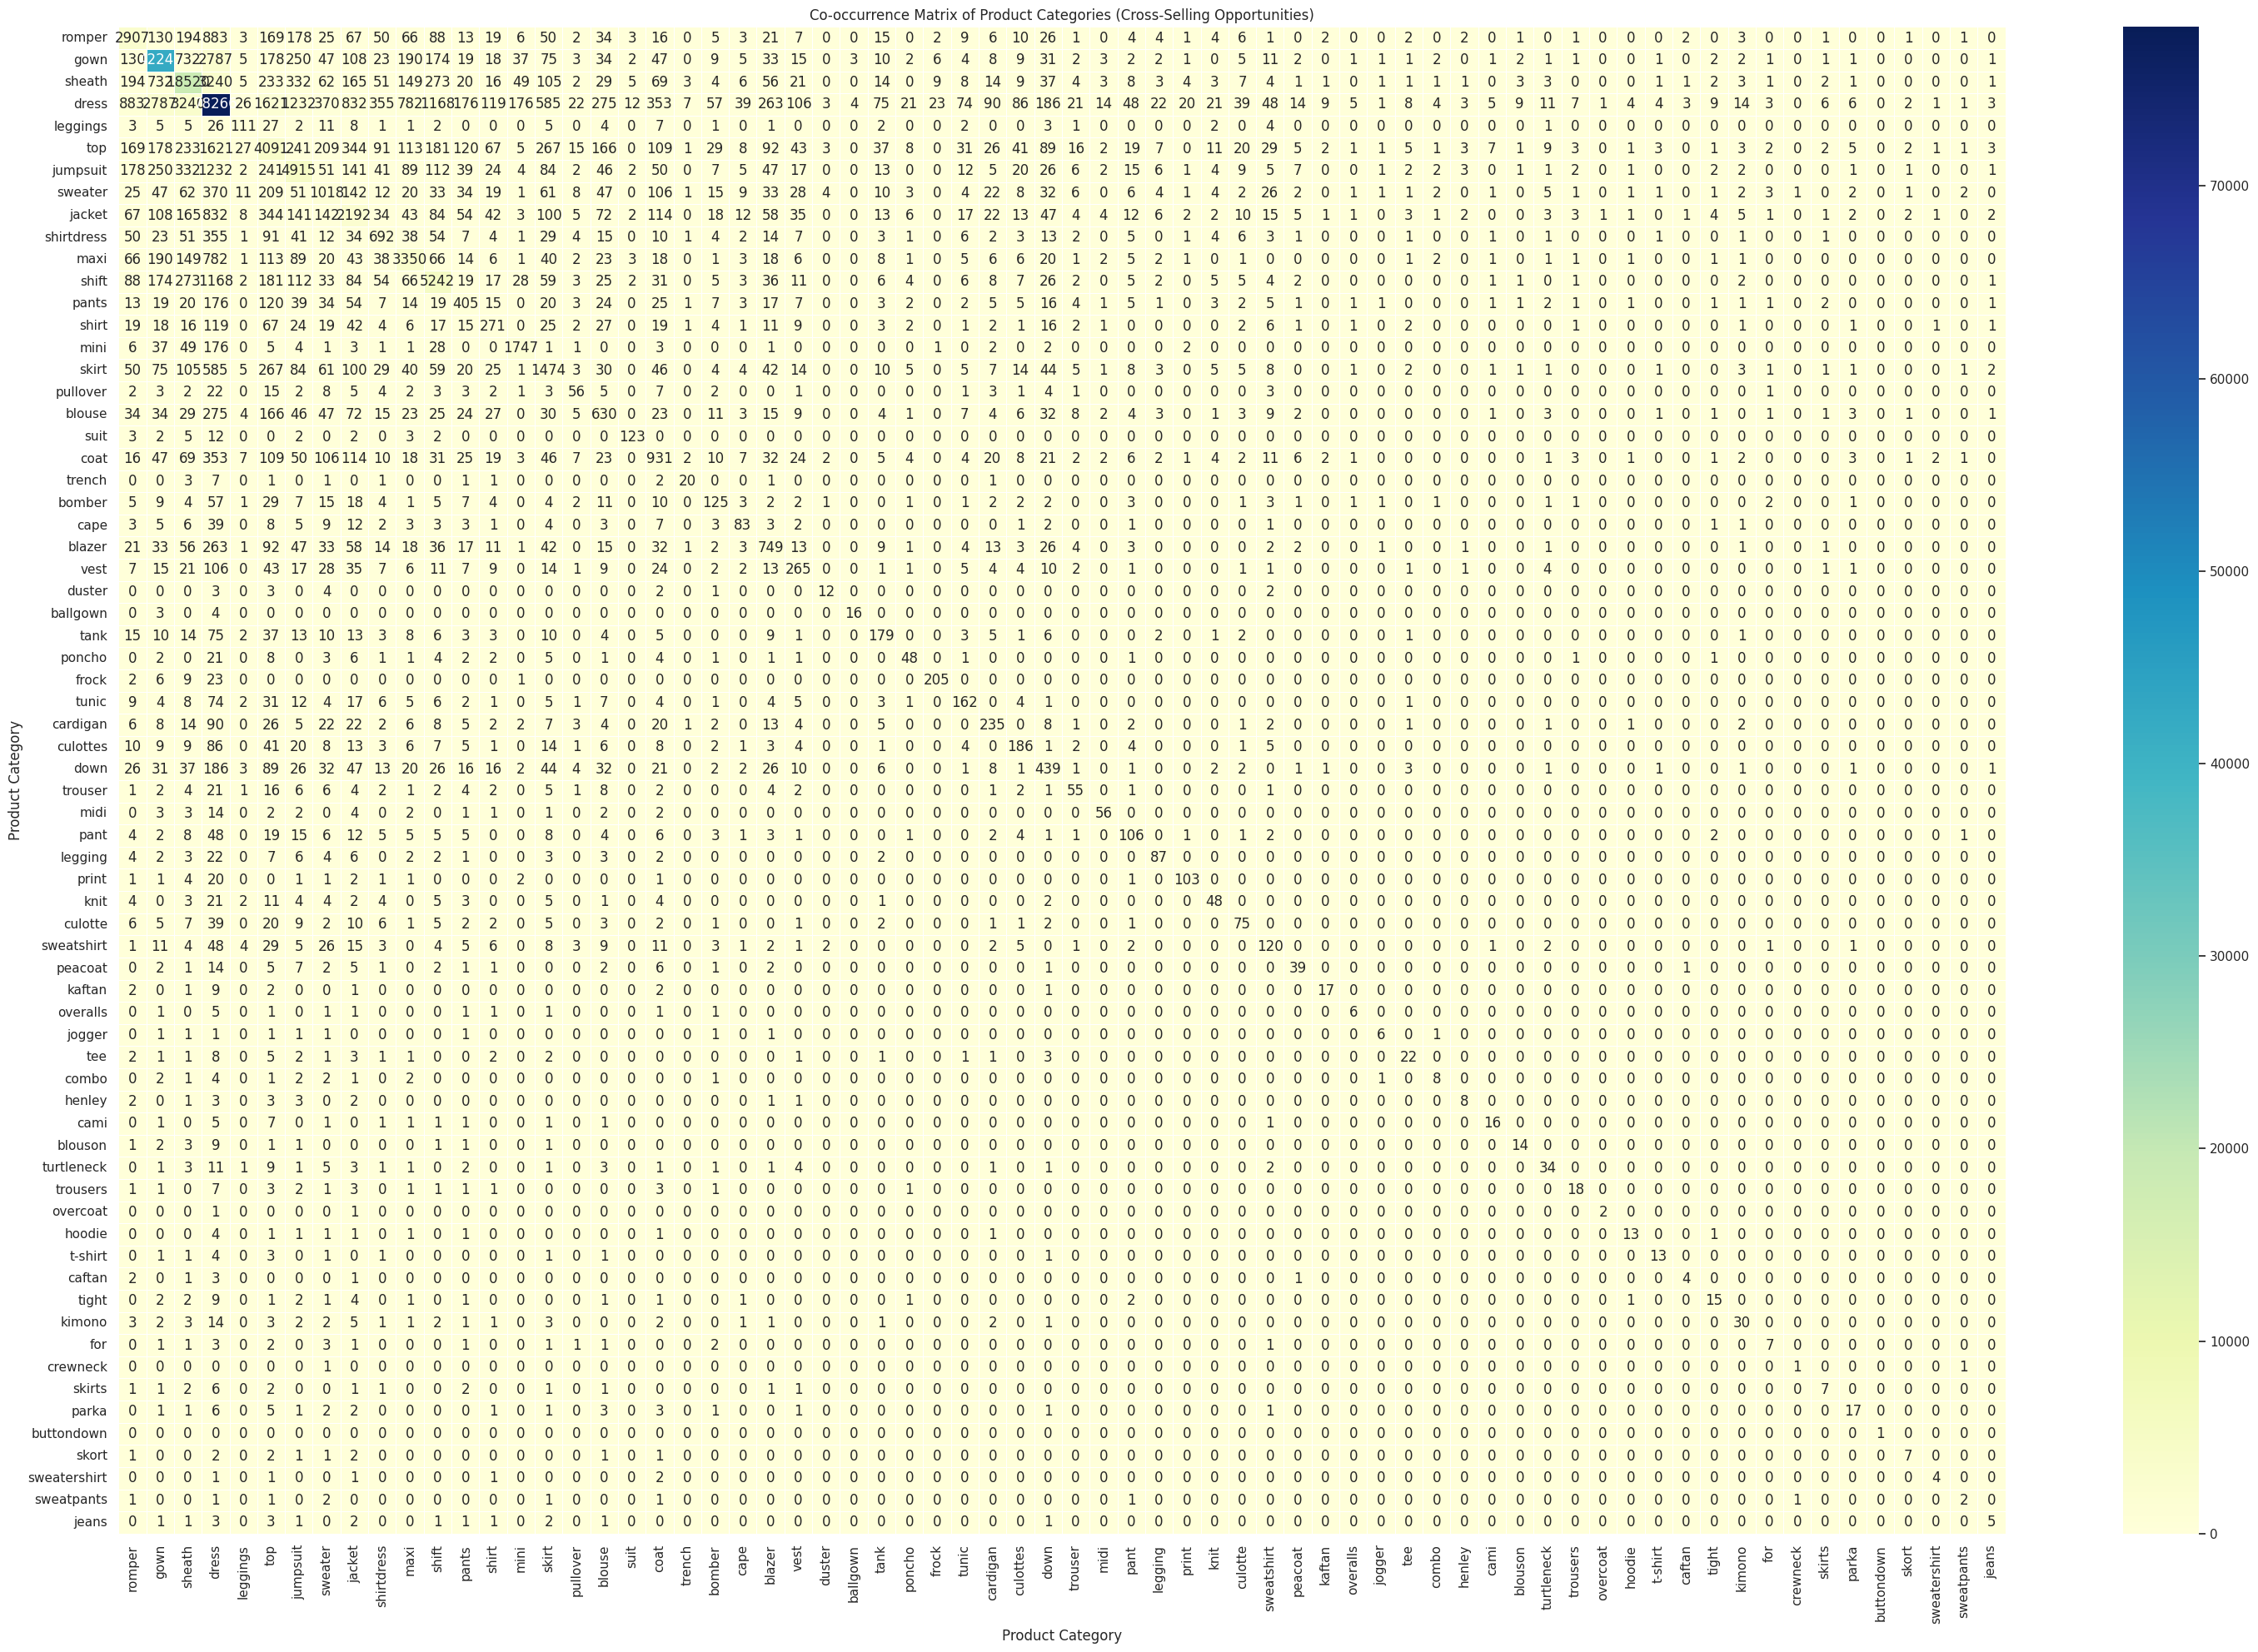

In [84]:
plt.figure(figsize=(30, 20))
sns.heatmap(cooccurrence, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title('Co-occurrence Matrix of Product Categories (Cross-Selling Opportunities)')
plt.xlabel('Product Category')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


## Customer Segmentation Profiability Analysis

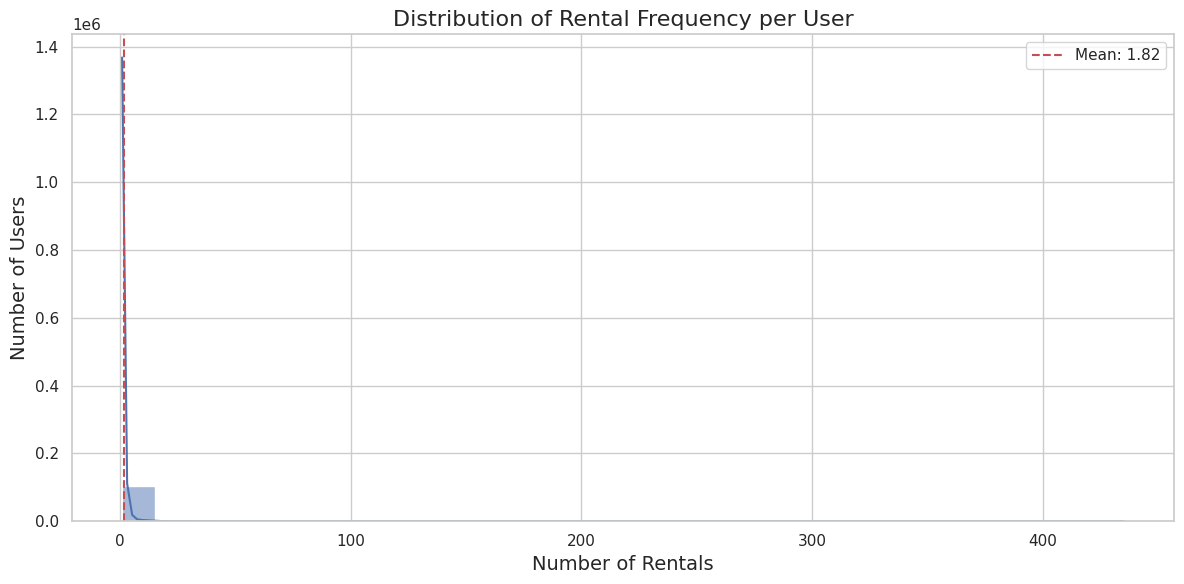

Rental Frequency Segment Distribution (%):
1-time renters    68.070777
2-3 rentals       23.456252
4-5 rentals        4.747516
6-10 rentals       2.659821
11+ rentals        1.065634
Name: segment, dtype: float64


In [85]:
# Calculate rental frequency per user
user_rental_frequency = df_mod['user_id'].value_counts().reset_index()
user_rental_frequency.columns = ['user_id', 'rental_count']

# Rental frequency
plt.figure(figsize=(12, 6))
sns.histplot(user_rental_frequency['rental_count'], bins=30, kde=True)
plt.title('Distribution of Rental Frequency per User', fontsize=16)
plt.xlabel('Number of Rentals', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.axvline(user_rental_frequency['rental_count'].mean(), color='r', linestyle='--', 
            label=f'Mean: {user_rental_frequency["rental_count"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Segment users into groups - rental frequency
user_rental_frequency['segment'] = pd.cut(
    user_rental_frequency['rental_count'], 
    bins=[0, 1, 3, 5, 10, np.inf], 
    labels=['1-time renters', '2-3 rentals', '4-5 rentals', '6-10 rentals', '11+ rentals']
)

segment_distribution = user_rental_frequency['segment'].value_counts(normalize=True) * 100
print("Rental Frequency Segment Distribution (%):")
print(segment_distribution)

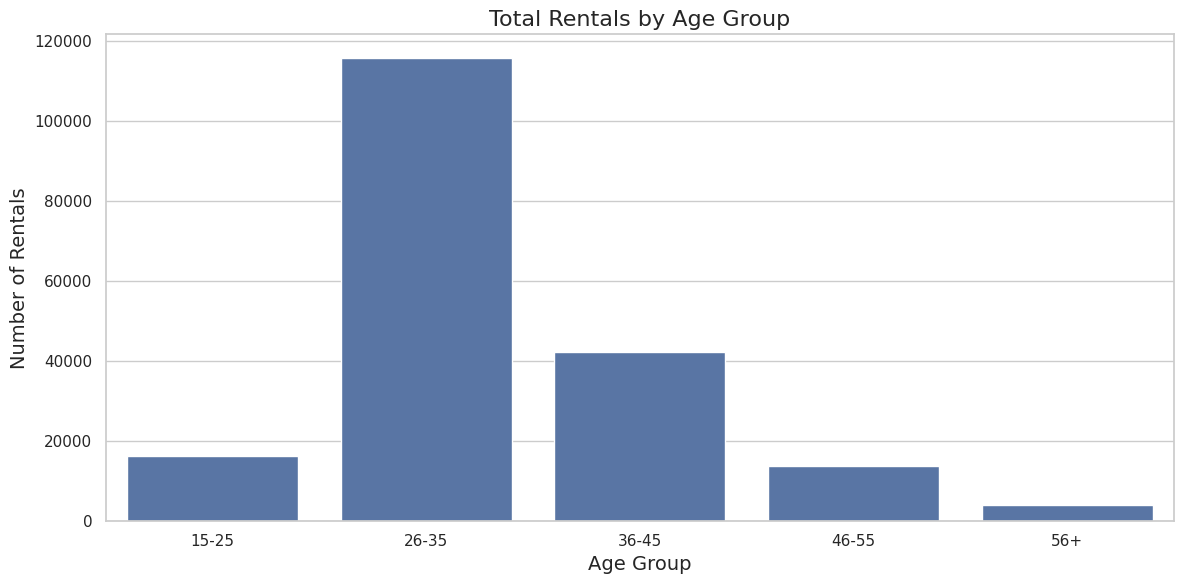

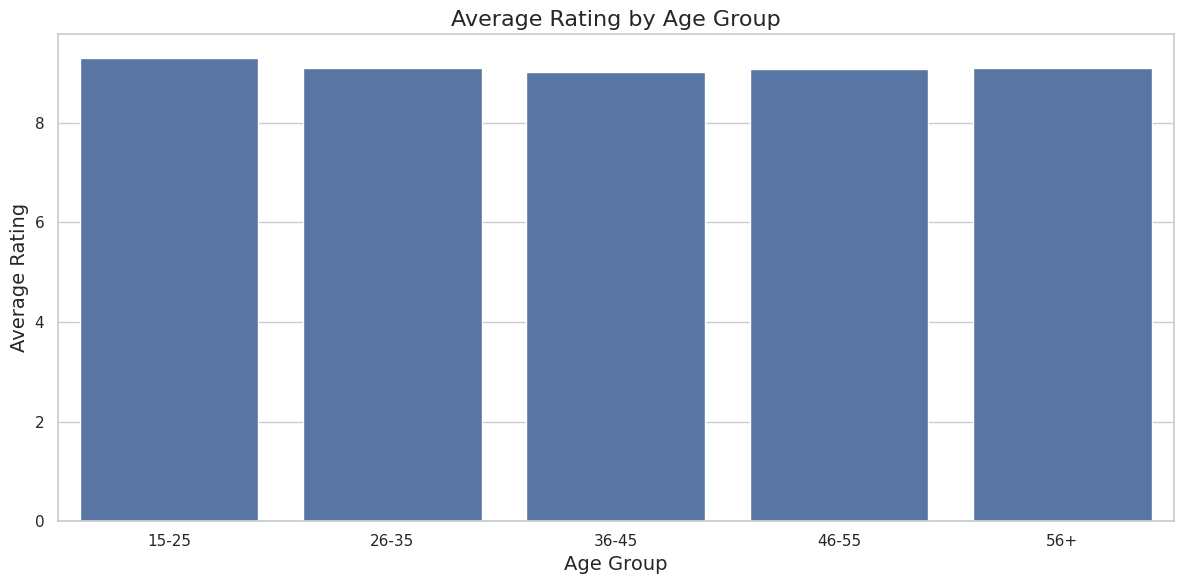

In [86]:
# Group data by age group and calculate average rentals and ratings
age_group_analysis = df_mod.groupby('age_group').agg(
    total_rentals=('user_id', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Total rentals by age group
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='total_rentals', data=age_group_analysis)
plt.title('Total Rentals by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.tight_layout()
plt.show()

# Average rating by age group
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='avg_rating', data=age_group_analysis)
plt.title('Average Rating by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.tight_layout()
plt.show()


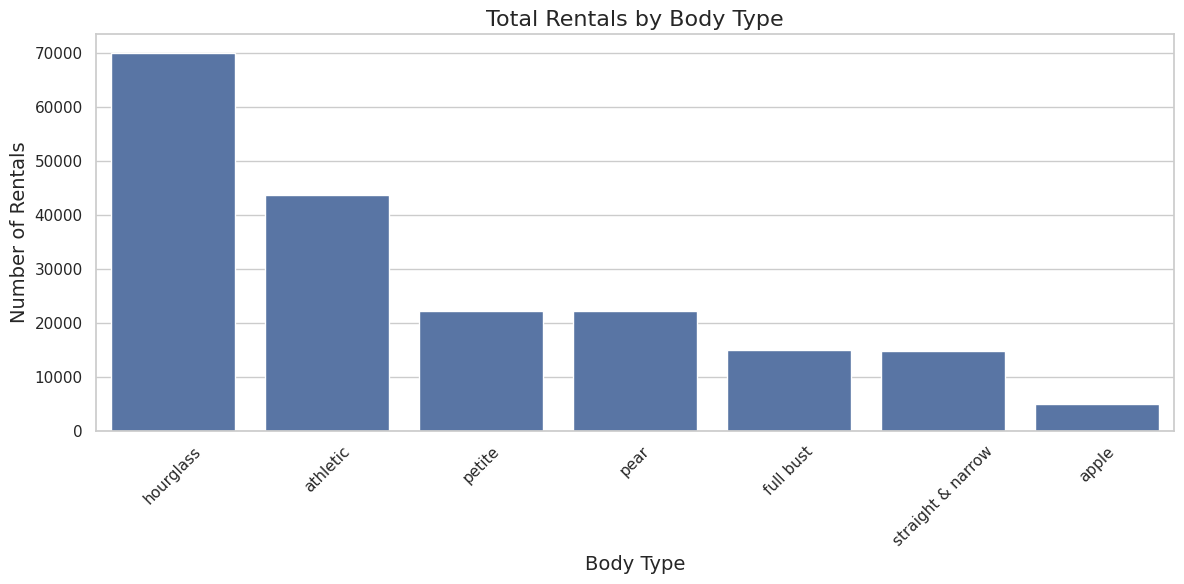

In [87]:
# Group data by body type and calculate total rentals and average ratings
body_type_analysis = df_mod.groupby('body_type').agg(
    total_rentals=('user_id', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Total rentals by body type
plt.figure(figsize=(12, 6))
sns.barplot(x='body_type', y='total_rentals', data=body_type_analysis.sort_values(by='total_rentals', ascending=False))
plt.title('Total Rentals by Body Type', fontsize=16)
plt.xlabel('Body Type', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




### Category Preferences by Customer Segment (Rental Count)

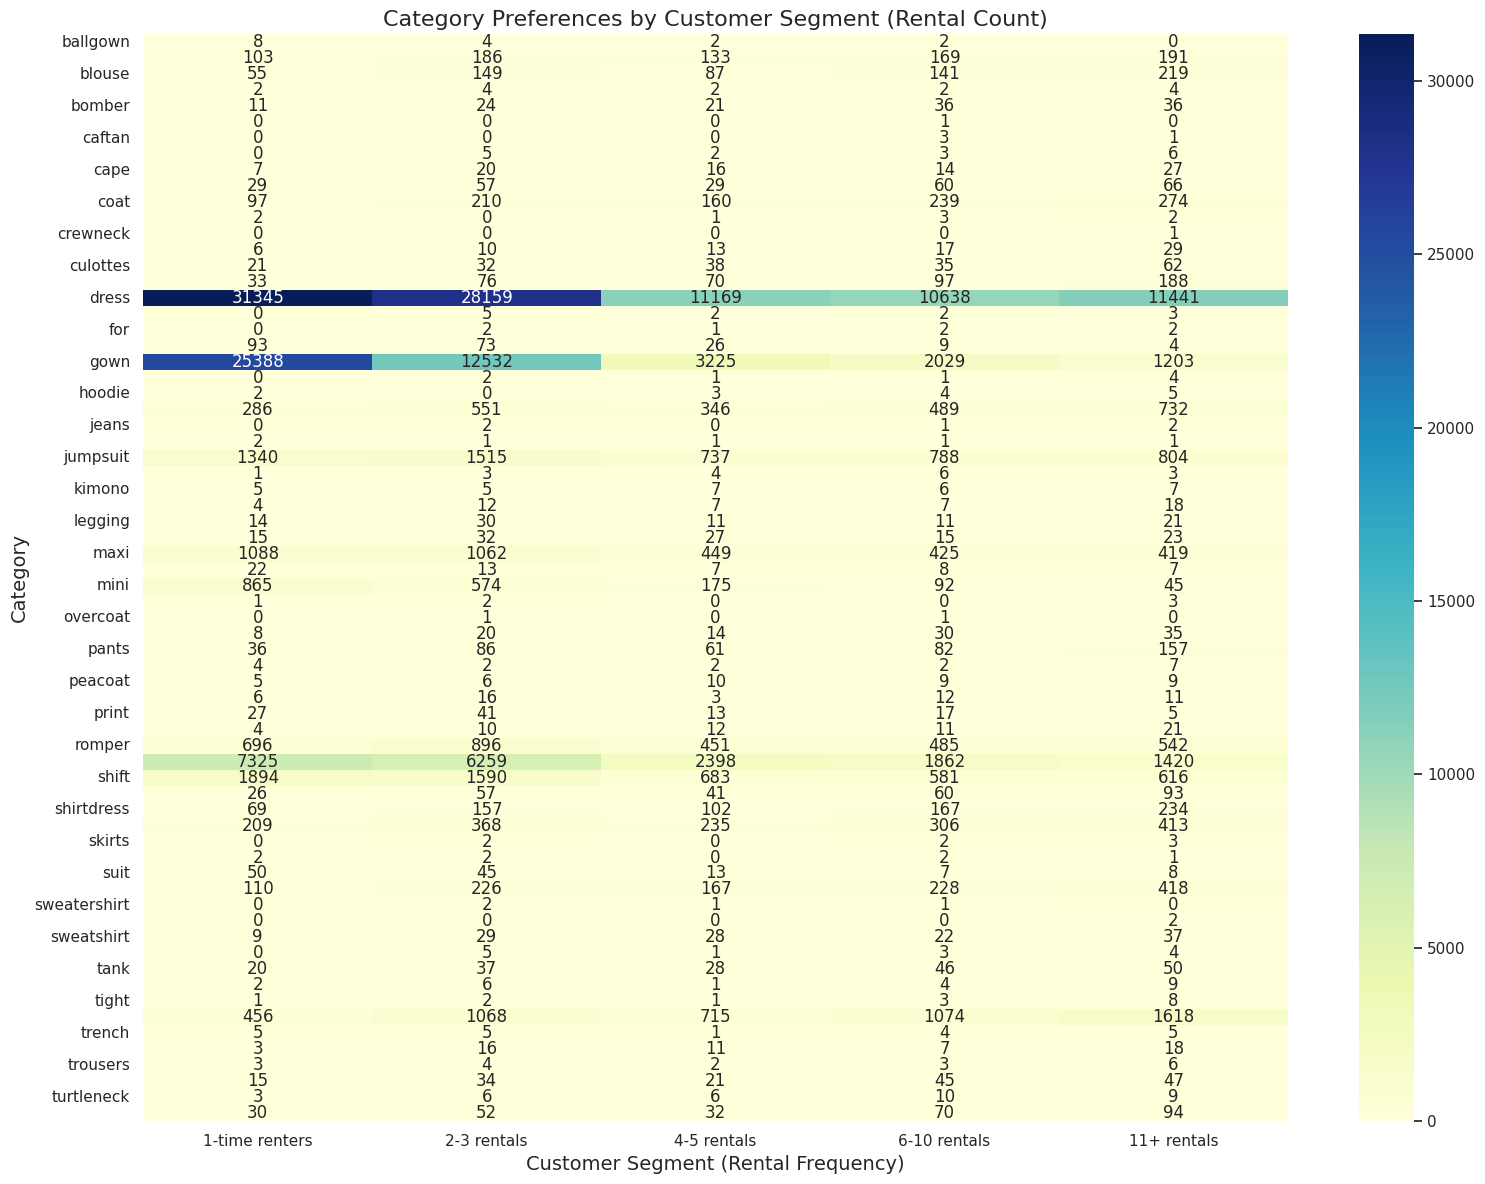

In [88]:
# Merge user rental frequency 
df_segmented = df_mod.merge(user_rental_frequency[['user_id', 'segment']], on='user_id')

# Group data by segment and category
category_segment_analysis = df_segmented.groupby(['segment', 'category']).size().reset_index(name='rental_count')

# Pivot table 
category_segment_pivot = category_segment_analysis.pivot(index='category', columns='segment', values='rental_count').fillna(0)

# Heatmap of category preferences by segment
plt.figure(figsize=(16, 12))
sns.heatmap(category_segment_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Category Preferences by Customer Segment (Rental Count)', fontsize=16)
plt.xlabel('Customer Segment (Rental Frequency)', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.tight_layout()
plt.show()


### Rental Occasions by Age Group (Rental Count)

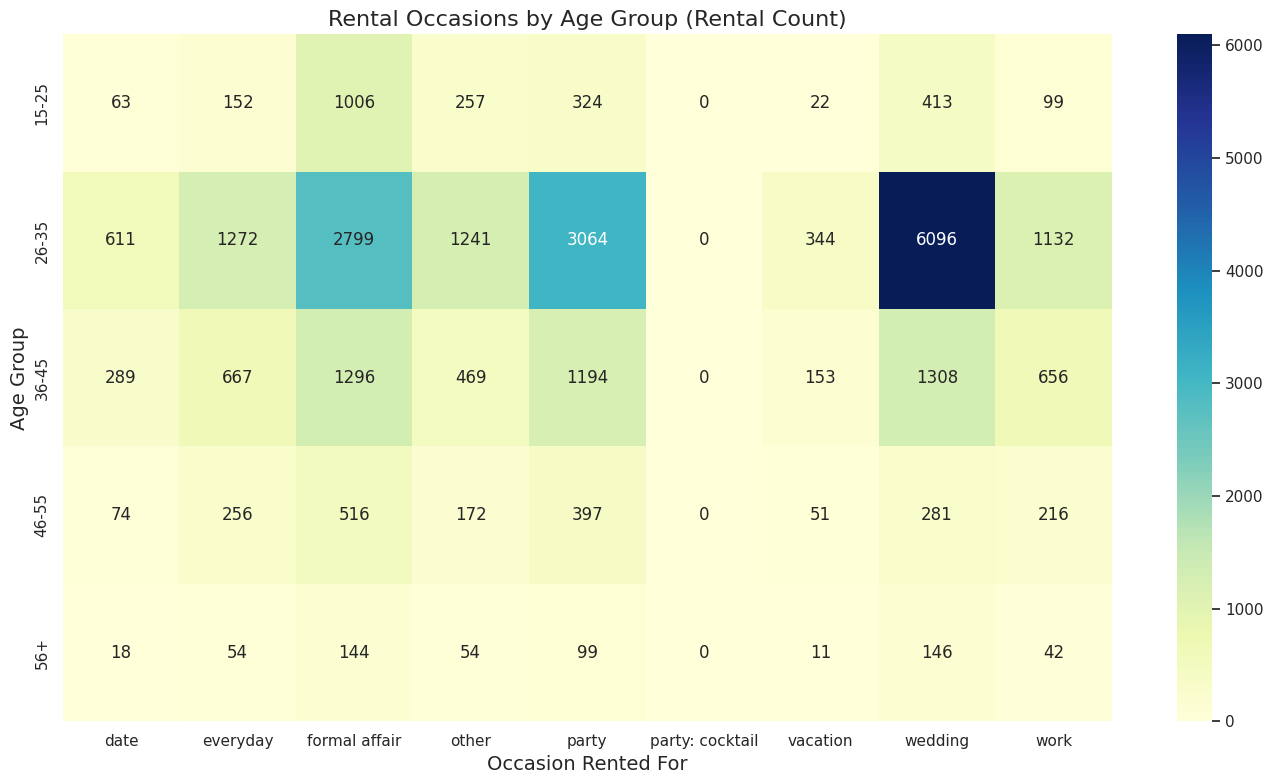

In [89]:
# Group data by age group, body type, and occasion
occasion_analysis = df_mod.groupby(['age_group', 'body_type', 'rented_for']).size().reset_index(name='rental_count')

# Pivot table 
occasion_pivot = occasion_analysis.pivot_table(index=['age_group'], columns=['rented_for'], values='rental_count').fillna(0)

# Heatmap of rental occasions by age group
plt.figure(figsize=(14, 8))
sns.heatmap(occasion_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Rental Occasions by Age Group (Rental Count)', fontsize=16)
plt.xlabel('Occasion Rented For', fontsize=14)
plt.ylabel('Age Group', fontsize=14)
plt.tight_layout()
plt.show()


### Monthly Rental Trends by Customer Segment (Rental Count)

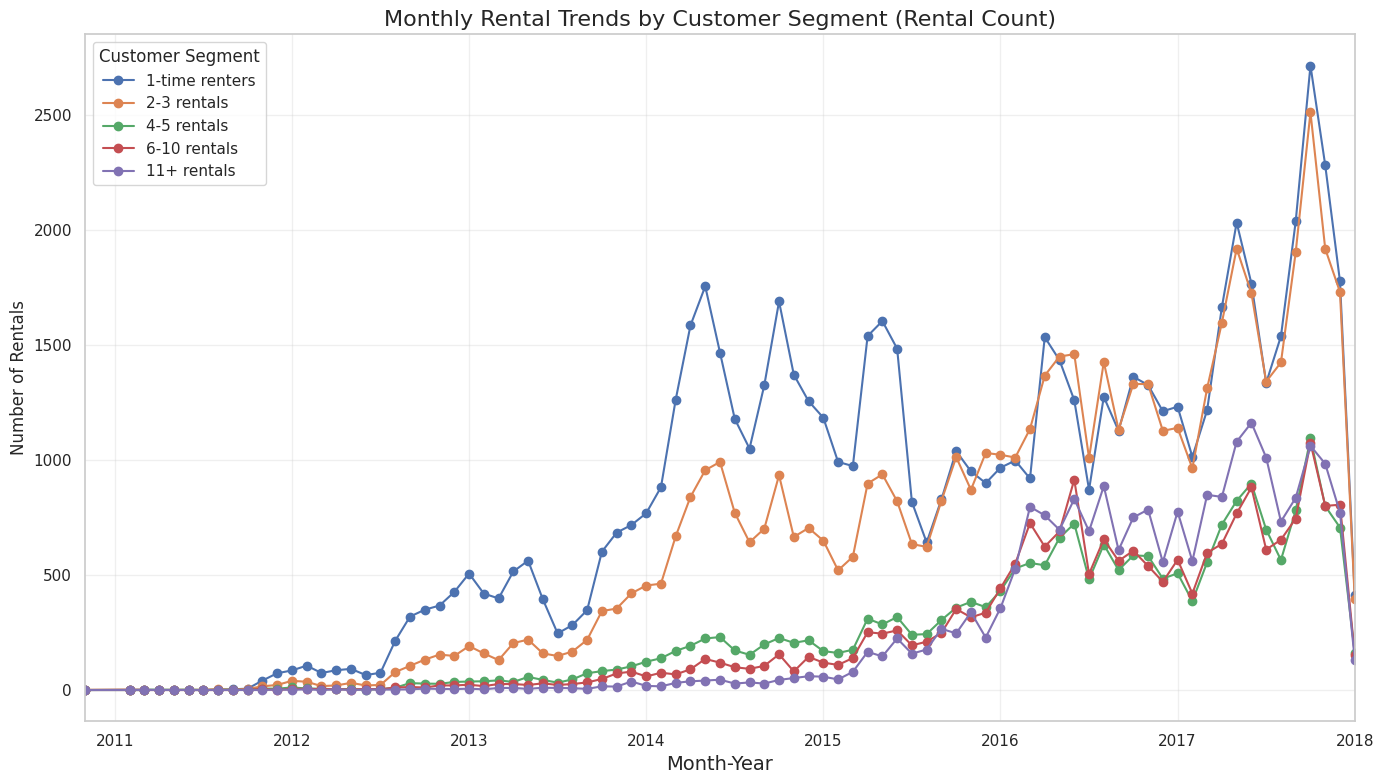

In [90]:
# Aggregate rentals over time for each segment
time_series_segment = df_segmented.groupby(['month_year', 'segment']).size().reset_index(name='rental_count')

# Pivot table 
time_series_pivot = time_series_segment.pivot(index='month_year', columns='segment', values='rental_count').fillna(0)

# Time series trends for each segment
time_series_pivot.plot(figsize=(14, 8), marker='o')
plt.title('Monthly Rental Trends by Customer Segment (Rental Count)', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Number of Rentals')
plt.legend(title='Customer Segment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Occasion based marketing calendar Development

In [91]:
df_mod['review_date'] = pd.to_datetime(df_mod['review_date'])

# Extract month and year for aggregation
df_mod['month_year'] = df_mod['review_date'].dt.to_period('M')

# Aggregate rentals by occasion and month_year
occasion_time_series = df_mod.groupby(['month_year', 'rented_for']).size().reset_index(name='rental_count')

# Pivot table 
occasion_pivot = occasion_time_series.pivot(index='month_year', columns='rented_for', values='rental_count').fillna(0)


### Rental Reason Trends by Occasion Over Time

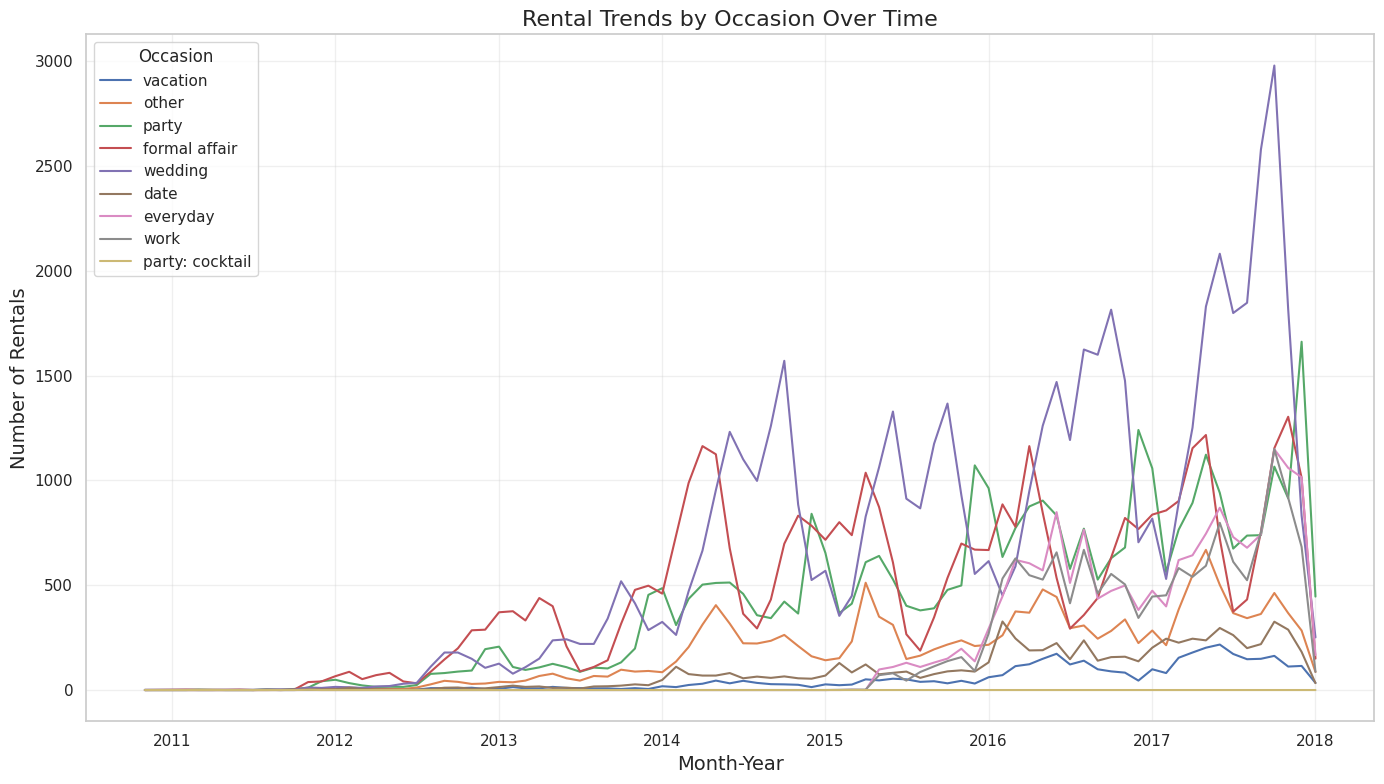

In [92]:
# Time series trends for each occasion
plt.figure(figsize=(14, 8))
for occasion in df_mod['rented_for'].dropna().unique():
    plt.plot(occasion_pivot.index.to_timestamp(), occasion_pivot[occasion], label=occasion)

plt.title('Rental Trends by Occasion Over Time', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Number of Rentals', fontsize=14)
plt.legend(title='Occasion')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Seasonal Trends in Rental Reason

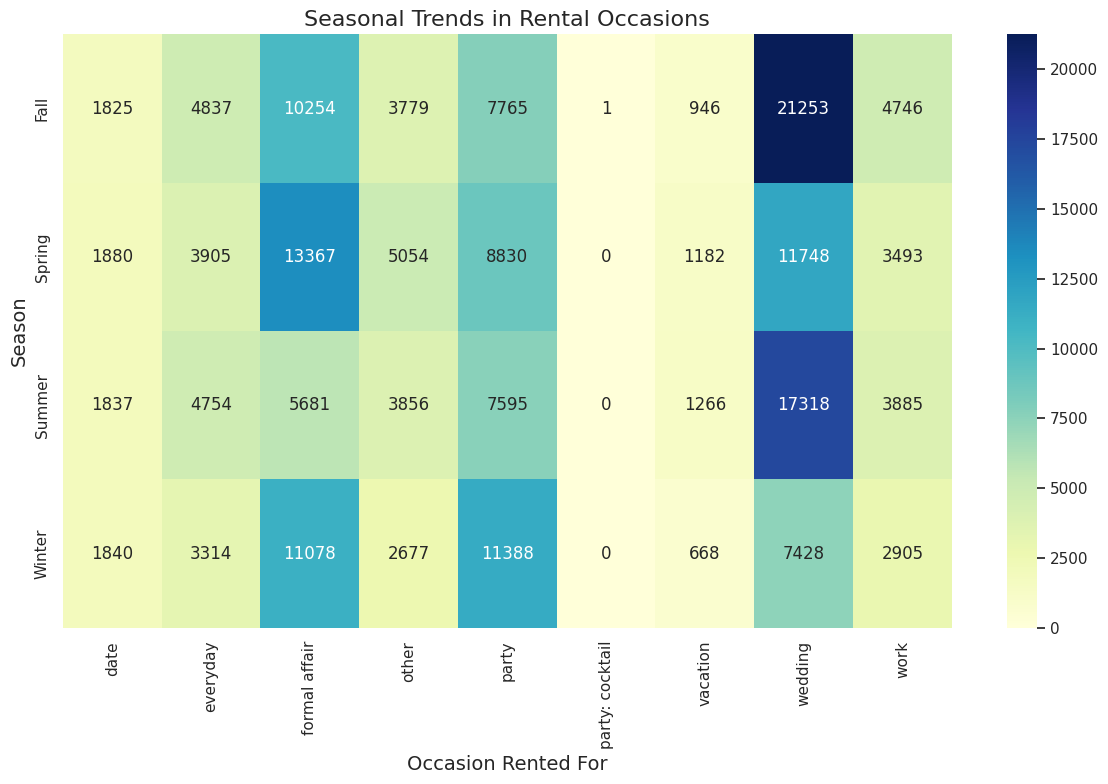

In [93]:
# Map months to seasons
df_mod['season'] = df_mod['review_date'].dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Aggregate rentals by season and occasion
season_occasion = df_mod.groupby(['season', 'rented_for']).size().reset_index(name='rental_count')

# Pivot table 
season_occasion_pivot = season_occasion.pivot(index='season', columns='rented_for', values='rental_count').fillna(0)

# Heatmap of seasonal trends by occasion
plt.figure(figsize=(12, 8))
sns.heatmap(season_occasion_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Seasonal Trends in Rental Occasions', fontsize=16)
plt.xlabel('Occasion Rented For', fontsize=14)
plt.ylabel('Season', fontsize=14)
plt.tight_layout()
plt.show()


### Rental Trends by Occasion 26-35 Age Group)

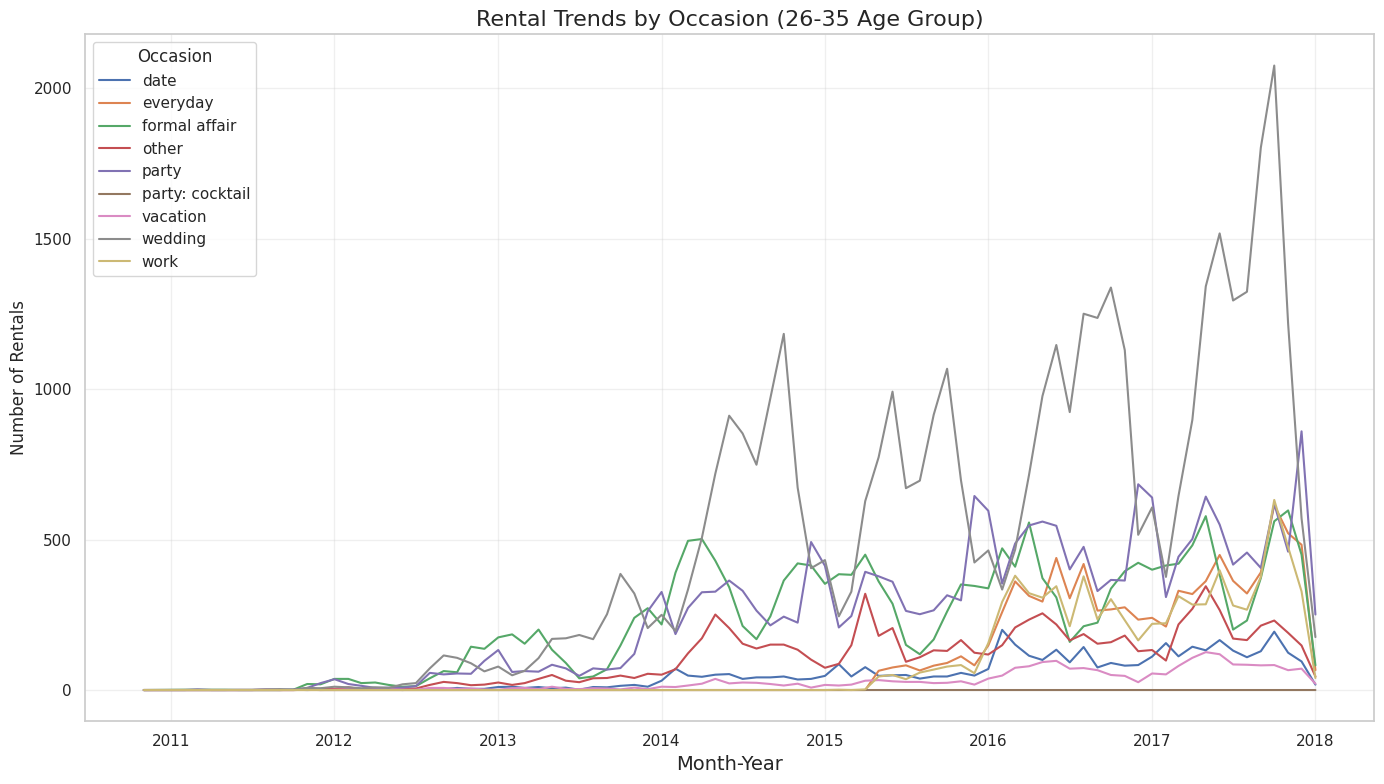

In [94]:
# df_mod['review_date'] = pd.to_datetime(df_mod['review_date'])

# Extract month and year for aggregation
df_mod['month_year'] = df_mod['review_date'].dt.to_period('M')

# Group data by age group, rented_for, and month_year
age_occasion_time_series = df_mod.groupby(['age_group', 'month_year', 'rented_for']).size().reset_index(name='rental_count')

# Pivot table
age_occasion_pivot = age_occasion_time_series.pivot_table(
    index=['month_year'], 
    columns=['age_group', 'rented_for'], 
    values='rental_count'
).fillna(0)

age_occasion_time_series['month_year'] = age_occasion_time_series['month_year'].dt.to_timestamp()

# Trends for "26-35" age group
age_group_to_plot = "26-35"
filtered_data = age_occasion_time_series[age_occasion_time_series['age_group'] == age_group_to_plot]

plt.figure(figsize=(14, 8))
for occasion in filtered_data['rented_for'].unique():
    subset = filtered_data[filtered_data['rented_for'] == occasion]
    plt.plot(subset['month_year'], subset['rental_count'],  label=occasion)

plt.title(f'Rental Trends by Occasion ({age_group_to_plot} Age Group)', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Number of Rentals')
plt.legend(title='Occasion')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Rental Trends by Occasion - Dress Category

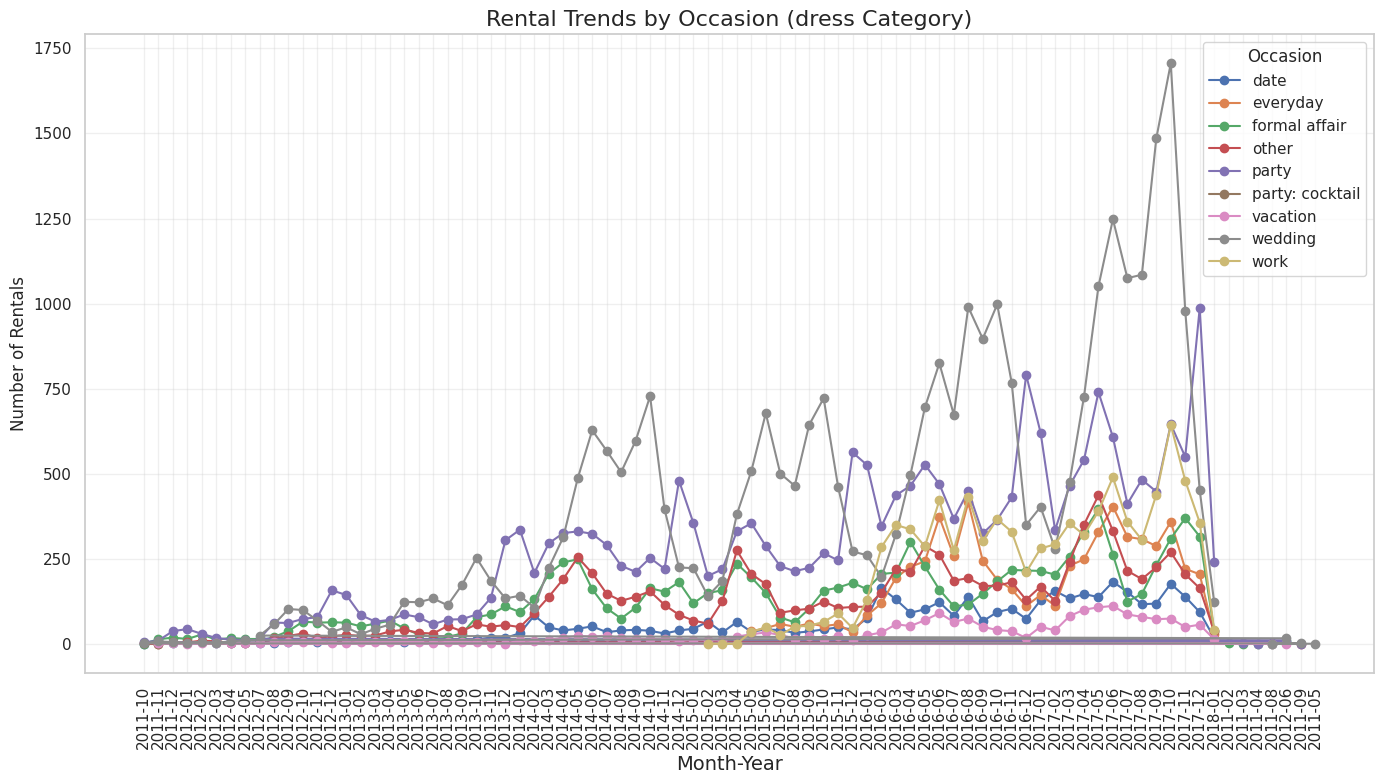

In [95]:
# Group data by category, rented_for, and month_year
category_occasion_time_series = df_mod.groupby(['category', 'rented_for', 'month_year']).size().reset_index(name='rental_count')

# Pivot table 
category_occasion_pivot = category_occasion_time_series.pivot_table(
    index=['month_year'], 
    columns=['category'], 
    values='rental_count'
).fillna(0)

category_occasion_time_series['month_year'] = category_occasion_time_series['month_year'].astype(str)

category_to_plot = "dress"
filtered_category_data = category_occasion_time_series[category_occasion_time_series['category'] == category_to_plot]

plt.figure(figsize=(14, 8))
for occasion in filtered_category_data['rented_for'].unique():
    subset = filtered_category_data[filtered_category_data['rented_for'] == occasion]
    plt.plot(subset['month_year'], subset['rental_count'], marker='o', label=occasion)

plt.title(f'Rental Trends by Occasion ({category_to_plot} Category)', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Number of Rentals')
plt.legend(title='Occasion')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Customer Retention

In [96]:
# Rental frequency per user
user_rental_frequency = df_mod['user_id'].value_counts().reset_index()
user_rental_frequency.columns = ['user_id', 'rental_count']

# Classify customers as one-time or repeat renters
user_rental_frequency['customer_type'] = np.where(user_rental_frequency['rental_count'] > 1, 'Repeat', 'One-Time')

df_customer_type = df_mod.merge(user_rental_frequency[['user_id', 'customer_type']], on='user_id')


### Average Rating by Customer Type

/tmp/ipykernel_2121/1260261255.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




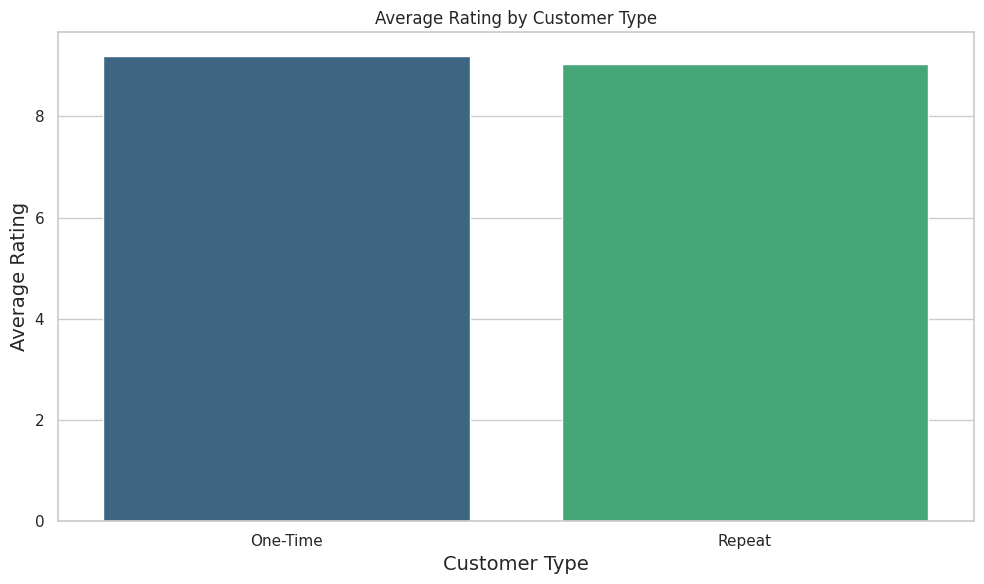

In [97]:
# Average rating by customer type
rating_by_customer_type = df_customer_type.groupby('customer_type')['rating'].mean().reset_index()

# Average rating by customer type
plt.figure(figsize=(10, 6))
sns.barplot(x='customer_type', y='rating', data=rating_by_customer_type, palette='viridis')
plt.title('Average Rating by Customer Type')
plt.xlabel('Customer Type', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.tight_layout()
plt.show()


### Fit Feedback Distribution by Customer Type

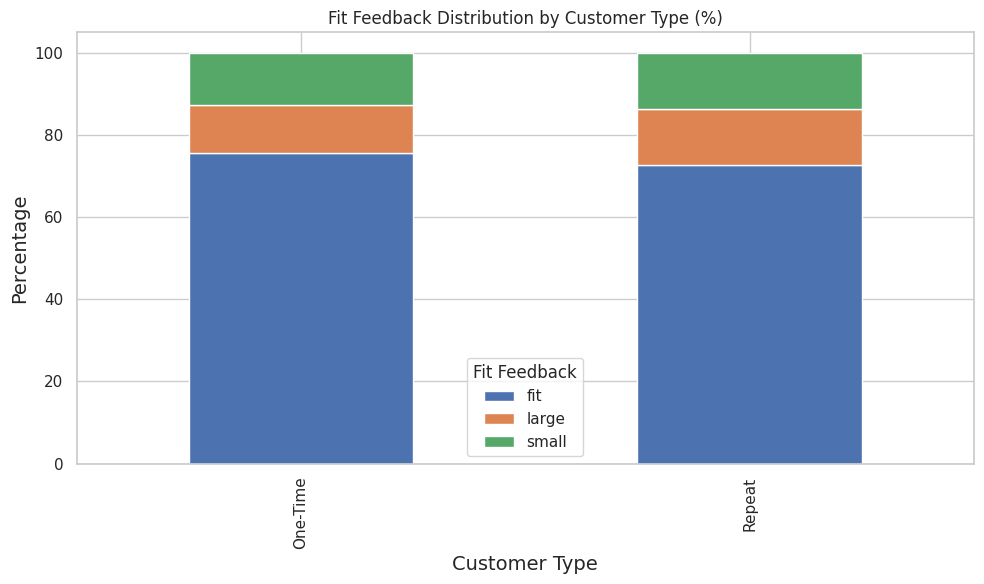

In [98]:
# Fit feedback distribution by customer type
fit_by_customer_type = pd.crosstab(df_customer_type['customer_type'], df_customer_type['fit'], normalize='index') * 100

# Fit feedback distribution
fit_by_customer_type.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fit Feedback Distribution by Customer Type (%)')
plt.xlabel('Customer Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Fit Feedback')
plt.tight_layout()
plt.show()


### Retention Rates by Age Group

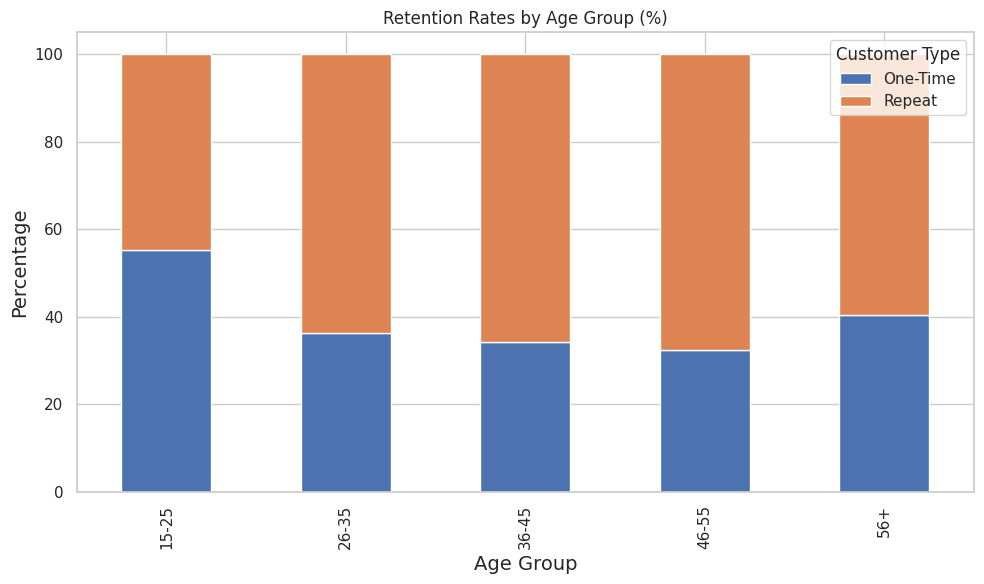

In [99]:
# Rental count by age group and customer type
age_group_retention = pd.crosstab(df_customer_type['age_group'], df_customer_type['customer_type'], normalize='index') * 100

# Age group retention distribution
age_group_retention.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Retention Rates by Age Group (%)')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()


### Retention Rates by Body Type

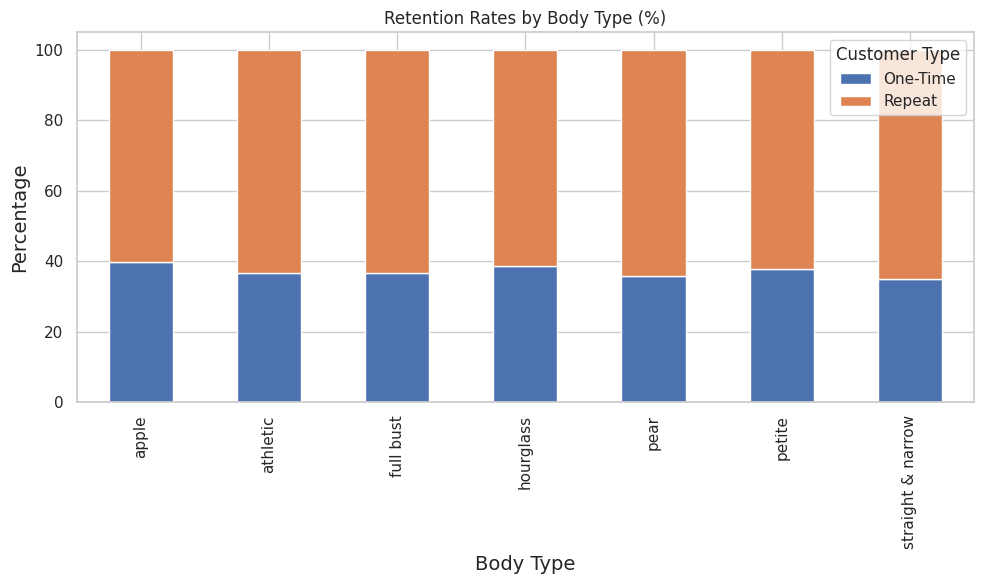

In [100]:
# Rental count by body type and customer type
body_type_retention = pd.crosstab(df_customer_type['body_type'], df_customer_type['customer_type'], normalize='index') * 100

# Body type retention distribution
body_type_retention.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Retention Rates by Body Type (%)')
plt.xlabel('Body Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()


### Retention Rates by Rental Occasion 

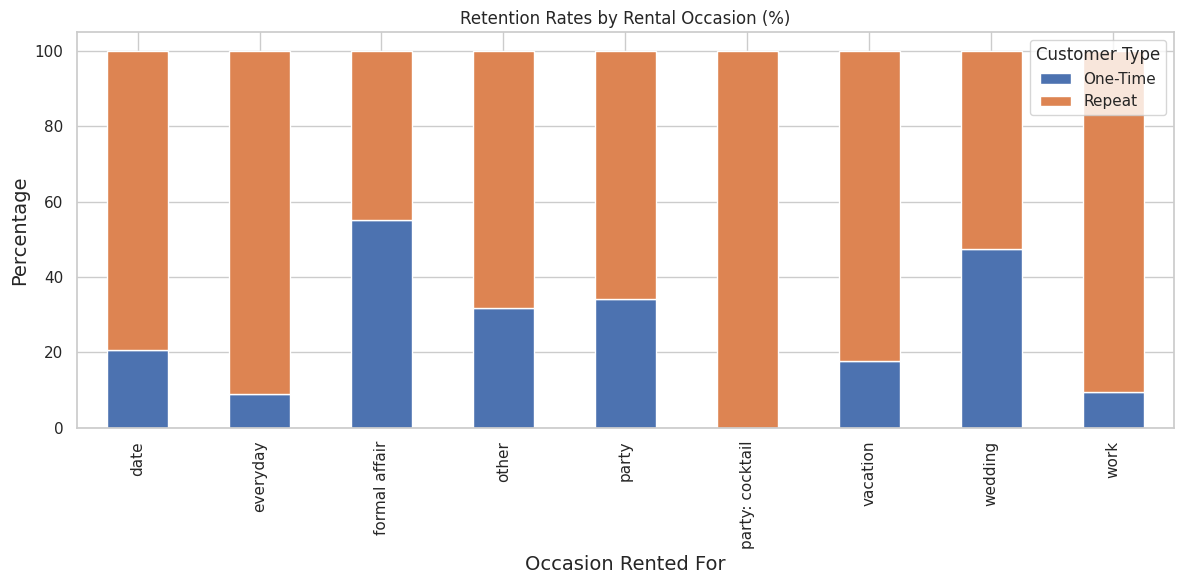

In [101]:
# Rental count by occasion and customer type
occasion_retention = pd.crosstab(df_customer_type['rented_for'], df_customer_type['customer_type'], normalize='index') * 100

# Occasion retention distribution
occasion_retention.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Retention Rates by Rental Occasion (%)')
plt.xlabel('Occasion Rented For', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Customer Type')
plt.tight_layout()
plt.show()


### Monthly Rental Trends by Customer Type (Rental Count)

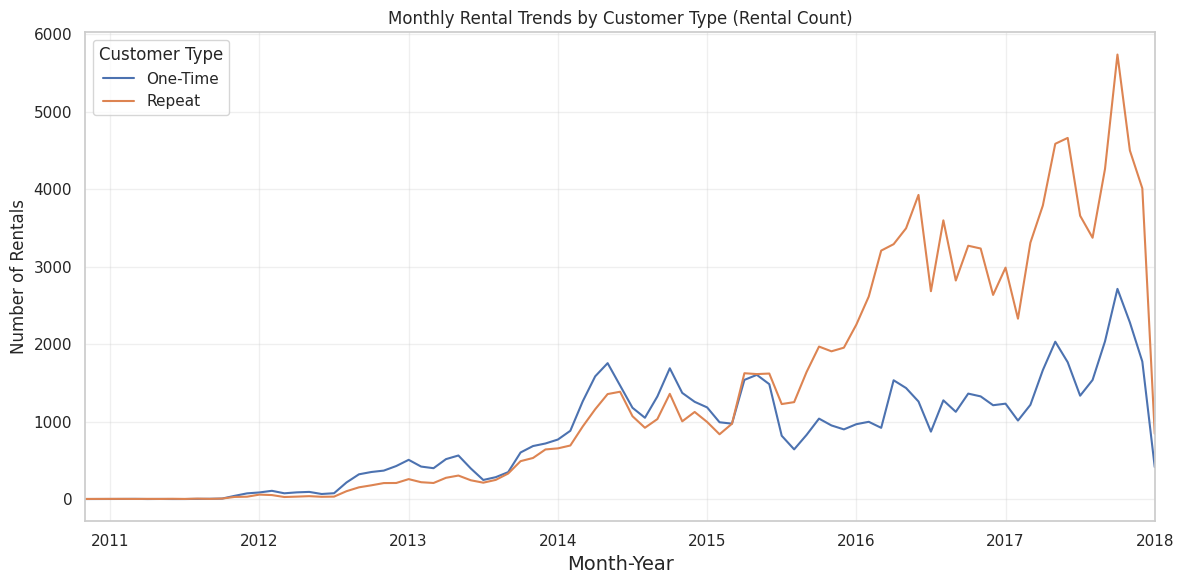

In [102]:
# Aggregate rentals by month_year and customer type
monthly_retention = df_customer_type.groupby(['month_year', 'customer_type']).size().reset_index(name='rental_count')

# Pivot table 
monthly_retention_pivot = monthly_retention.pivot(index='month_year', columns='customer_type', values='rental_count').fillna(0)

# Time series trends for each customer type
monthly_retention_pivot.plot(figsize=(12, 6))
plt.title('Monthly Rental Trends by Customer Type (Rental Count)')
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Number of Rentals')
plt.legend(title='Customer Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a59e35e6-ffff-4b08-97a9-b33ef5463cd6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>